# Summary of Task Completion

Tasks 1 and 2, along with Extension Tasks 1 and 2, are completed in this Jupyter Notebook.
Task 3 is completed in the Report.

# Sound identification

In this mini project you will try and identify various types of sounds. This project can be considered as part image classifciation and part sequence modelling.

![Some of the images in spectrogram format](esc50.gif)



There are 2000 different sounds available covering 50 different categories. The different targets (labels), named categories and the number of sounds in each category are listed below.

|Target | Category | Count |
|---------|---------|-------|
| 0 | airplane | 40 |
| 1 | breathing | 40 |
| 2 | brushing_teeth | 40 |
| 3 | can_opening | 40 |
| 4 | car_horn | 40 |
| 5 | cat | 40 |
| 6 | chainsaw | 40 |
| 7 | chirping_birds | 40 |
| 8 | church_bells | 40 |
| 9 | clapping | 40 |
| 10 | clock_alarm | 40 |
| 11 | clock_tick | 40 |
| 12 | coughing | 40 |
| 13 | cow | 40 |
| 14 | crackling_fire | 40 |
| 15 | crickets | 40 |
| 16 | crow | 40 |
| 17 | crying_baby | 40 |
| 18 | dog | 40 |
| 19 | door_wood_creaks | 40 |
| 20 | door_wood_knock | 40 |
| 21 | drinking_sipping | 40 |
| 22 | engine | 40 |
| 23 | fireworks | 40 |
| 24 | footsteps | 40 |
| 25 | frog | 40 |
| 26 | glass_breaking | 40 |
| 27 | hand_saw | 40 |
| 28 | helicopter | 40 |
| 29 | hen | 40 |
| 30 | insects | 40 |
| 31 | keyboard_typing | 40 |
| 32 | laughing | 40 |
| 33 | mouse_click | 40 |
| 34 | pig | 40 |
| 35 | pouring_water | 40 |
| 36 | rain | 40 |
| 37 | rooster | 40 |
| 38 | sea_waves | 40 |
| 39 | sheep | 40 |
| 40 | siren | 40 |
| 41 | sneezing | 40 |
| 42 | snoring | 40 |
| 43 | thunderstorm | 40 |
| 44 | toilet_flush | 40 |
| 45 | train | 40 |
| 46 | vacuum_cleaner | 40 |
| 47 | washing_machine | 40 |
| 48 | water_drops | 40 |
| 49 | wind | 40 |


## Data description
The data comes in the form of short WAV files, in the code below we show how you can convert the WAV file into a spectrogram which is a plot of frequency vs time. For more details you can see the [dataset decription](https://doi.org/10.1145/2733373.2806390).

## Machine learning tasks
1. Develop a machine learning algorithm that can classify the sounds in terms of the 50 original categories using only the spectrogram images.
2. Develop a machine learning algorithm that can classify the sounds in terms of the 50 original categories using only the waveforms.
3. Determine which of the categories are easiest and hardest to separate.

## Potential extension tasks
1. Use an appropriate technique to determine how to group the 50 categories into a smaller number of super-categories
2. Develop a machine learning algorithm that can classify the sounds in terms of the super categories
3. Record some sounds of your own (or find suitable sounds otherwise) and test how well your model can categorise the new sounds.
4. Develop a generative network that can create fake sounds from one or more of the categories.


## Things to remember
Investigate the shape of the data. For example are all of the recordings the same length? think about what techniques might be well suited to clustering the sounds into the super-categories (if you choose to do the optional task).

In [1]:
# Import relevant libraries
import librosa # librosa is a helper library for reading audo files
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow import keras
import os
import scipy.signal

# For easier and cleaner Neural Network code importing layers
from keras.models import Sequential
from keras.layers import ReLU, Dense, Conv1D, Conv2D, SeparableConv2D, Input
from keras.layers import Resizing, Dropout, BatchNormalization, Flatten, Reshape
from keras.layers import MaxPooling1D, GlobalAveragePooling2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import LabelEncoder

import seaborn as sns # for visualisation
from collections import defaultdict # used for concatenating dictionaries

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # for splitting data into training and testing sets
from sklearn.metrics import confusion_matrix #for evaluation of classification

2025-04-02 05:47:41.893678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Function to load the metadata from the CSV file
def getMeta():
    return pd.read_csv('sounds.csv')

# Function to load an audio signal from a .wav file
def getSignal(fileName):
    return librosa.load(fileName, sr=44100)[0] # load the audio file (sample rate 44100 Hz)

# Function to extract a mel spectrogram from an audio signal
def getSpect(signal):
    # convert the raw waveform into a mel spectrogram
    spec = librosa.feature.melspectrogram(y=signal, sr=44100, n_fft=2205, hop_length=441)
    # converts amplitude values to decibels for better visualisation and model performance
    spec = librosa.power_to_db(spec)
    return spec

# Combine everything: load audio file and extract its spectrogram
def getSignalSpect(meta,number):
    recording=meta['filename'][number]
    signal = getSignal('audio/'+recording)
    return signal, getSpect(signal)

# Load the metadata CSV file into a DataFrame
meta=getMeta()

In [4]:
# Metadata summary and class distribution
print("There are a total of",meta['category'].size,"sounds")
categories = meta[['category']].value_counts() #Count the instances of each value
print("Coming from",categories.size,"categories")
print("So each category has",meta['category'].size//categories.size,"sounds")
print("In the meta data we have",meta.columns)
#print(meta.iloc[5])

There are a total of 2000 sounds
Coming from 50 categories
So each category has 40 sounds
In the meta data we have Index(['filename', 'fold', 'target', 'category', 'esc10', 'src_file', 'take'], dtype='object')


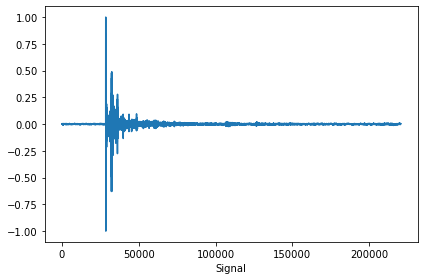

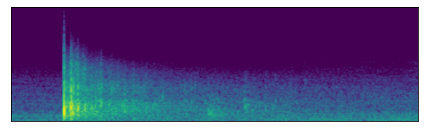

In [5]:
# Visualising raw audio waveform and corresponding spectrogram
signal,spect=getSignalSpect(meta,20)
fig,ax =plt.subplots()
ax.plot(np.arange(signal.shape[0]),signal)
ax.set_xlabel("Sample Number")
ax.set_xlabel("Signal")
fig.tight_layout()

fig,ax =plt.subplots() 
ax.imshow(spect, origin='lower', interpolation=None, cmap='viridis', aspect=1.1)
#ax.set_title(f'{category} - {recording}', fontsize=11)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
fig.tight_layout()

# Task 1: Develop a machine learning algorithm that can classify the sounds in terms of the 50 original categories using only the spectrogram images.

## So, first of all, let's extract the spectrogram images

In [35]:
# File paths
signal_file_path = '/Users/xeniaodintsova/Desktop/ML_Project/'
meta_file_path = '/Users/xeniaodintsova/Desktop/ML_Project/sounds.csv'

# Labels
labels = np.array(meta['target'])

# Class Names
class_names = np.unique(meta['category'])

# Total number of audio files in the dataset (should be 2000)
num_samples = len(meta)

# Target shape for spectrograms
spec_height = 128     # number of mel bands (frequency bins)
spec_width = 500      # number of time steps we want to standardise to

# Preallocate memory for speed and efficiency:
# Create a numpy array to hold all spectrograms; shape will be (num_samples, height, width)
spectrograms = np.zeros((num_samples, spec_height, spec_width), dtype=np.float32)

# Create a numpy array to hold labels (numeric class targets)
labels = np.zeros((num_samples,), dtype=np.int32)

# Loop through all audio files, extracting spectrograms
for i in range(num_samples):
    try:
        filename = meta['filename'][i]
        signal = getSignal('audio/' + filename) # obtain the waveform
        spec = getSpect(signal)  # extract mel spectrogram from the signal, with shape (128, time_steps)

        # Resize spectrogram to a fixed width (500 time steps):
        # If it's too short, pad with zeros:
        if spec.shape[1] < spec_width:
            pad_width = spec_width - spec.shape[1]
            spec = np.pad(spec, ((0, 0), (0, pad_width)), mode='constant')

        # If it's too long, crop it:
        elif spec.shape[1] > spec_width:
            spec = spec[:, :spec_width]

        spectrograms[i] = spec # store the final spectrogram in our preallocated array

        # Store the corresponding label from the metadata
        labels[i] = meta['target'][i]  # also store the corresponding label from the metadata
                                    # can be changed to 'category' if using class names

    except Exception as e:
        print(f"Error processing {filename}: {e}") # for any errors that happen during processing

# Check that the shapes are as expected
print(spectrograms.shape) # expected: (2000, 128, 500)
print(labels.shape) # expected: (2000,)

(2000, 128, 500)
(2000,)


In [36]:
# Split the spectrogram images into training and validation (testing) data sets
images_train, images_test, labels_train, labels_test = train_test_split(spectrograms, labels, test_size=0.2, random_state=42)

# Add channel dimension (prepare for CNN input)
images_train = images_train[..., np.newaxis]  # expected shape: (1600, 128, 500, 1)
images_test = images_test[..., np.newaxis]    # expected shape: (400, 128, 500, 1)

# Check that the split is as expected
print(images_train.shape)
print(images_test.shape)

(1600, 128, 500, 1)
(400, 128, 500, 1)


## Define a Convolutional Neural Network (CNN)

In [96]:
def CNN(input_shape):
  model = keras.Sequential()

  # Input layer and resizing to a standard shape
  model.add(Input(shape=input_shape))
  model.add(keras.layers.Resizing(64, 128))  # resize the data to 64×128

  # 1st convolutional block: Conv2D + MaxPooling
  model.add(Conv2D(64, (3, 3), activation='relu'))  # 64 filters, 3x3 kernel
  model.add(MaxPooling2D(2, 2))  # 2x2 max pooling

  # 2nd convolutional block
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(2, 2))

  # 3rd convolutional block
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D(2, 2))

  # 4th convolutional block
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D(2, 2))

  # Flatten the feature maps into a 1D vector
  model.add(Flatten())

  # Fully connected (dense) layers for classification
  model.add(Dense(100, activation='relu'))    # Hidden dense layer
  model.add(Dense(50, activation='softmax'))  # Output layer for 50 classes

  # Compile the model with Adam optimizer and accuracy metric
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.summary()

  return model

## Define Functions for Metrics Visualisation and Extraction

### 1. Plot loss and accuracy over the history of model training
### 2. Plot the confusion matrix
### 3. Extract metrics from accuracy, precision and recall for each of the sound classes

In [9]:
def plot_loss_acc(history, subtitle):
    """
    Plots the training and validation loss and accuracy of a Keras model.

    Parameters:
    - history: A Keras History object containing the model's training history.
    - subtitle: String for the figure's global title.

    The function creates a 1x2 subplot: the left plot shows loss and the right plot shows accuracy.
    """

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    # Plotting the loss
    ax[0].plot(history.history['val_loss'], label='Testing Loss')
    ax[0].plot(history.history['loss'], label='Training Loss')
    ax[0].set_title('Training and Testing Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Plotting the accuracy
    ax[1].plot(history.history['val_accuracy'], label='Testing Accuracy')
    ax[1].plot(history.history['accuracy'], label='Training Accuracy')
    ax[1].set_title('Training and Testing Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    fig.suptitle(subtitle, fontsize=16)

    plt.tight_layout()
    plt.show()

In [10]:
def plot_confusion_matrix(y_true, y_pred, class_names, cmap='PuRd', metrics=False):
    """
    Plots a confusion matrix using seaborn's heatmap and optionally returns metrics.

    Parameters:
    - y_true: True labels (ground truth)
    - y_pred: Predicted labels from your model
    - class_names: List of class names corresponding to label indices
    - cmap: Color map for the heatmap
    - metrics: If True, returns accuracy, precision, recall, quantity per class

    Returns:
    - If metrics=True: (accuracy, recall, precision, quantity) as dictionaries
    """

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalise the matrix (optional — not displayed here, just computed)
    cm_sum = cm.sum(axis=1, keepdims=True)
    cm_sum[cm_sum == 0] = 1  # Prevent division by zero
    cm_normalized = cm.astype('float') / cm_sum

    # Create the plot
    fig = plt.figure(figsize=(20, 20), dpi=150)

    # Plot the raw confusion matrix with annotations
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, annot_kws={'size': 10},xticklabels=class_names, 
                yticklabels=class_names, cbar_kws={"shrink": 0.82}, linewidths=0.1, linecolor='gray')

    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Close the figure (frees up memory if run in a loop)
    plt.close(fig)

    # Return metrics per class if requested
    if metrics:
        label_accuracy = {}
        label_precision = {}
        label_recall = {}
        label_quantity = {}

        # Total number of true instances per class (row sum)
        label_quantity = dict(zip(range(cm.shape[0]), np.sum(cm, axis=1)))

        # Loop through each class and calculate metrics
        for label in range(cm.shape[0]):
            true_positive = cm[label, label]
            predicted_total = np.sum(cm[:, label])  # how often this class was predicted
            actual_total = np.sum(cm[label, :])     # how often this class occurred

            # Avoid division by zero
            precision = true_positive / predicted_total if predicted_total > 0 else 0
            recall = true_positive / actual_total if actual_total > 0 else 0
            accuracy = true_positive / actual_total if actual_total > 0 else 0

            # Save results in dictionaries
            label_precision[label] = precision
            label_recall[label] = recall
            label_accuracy[label] = accuracy

        return label_accuracy, label_recall, label_precision, label_quantity

In [11]:
def extract_metrics(class_names, label_accuracy, label_recall, label_precision, label_quantity):
    """
    Converts classification metrics into a pandas DataFrame (with class names as index).

    Parameters:
    - class_names (list): List of class names in the same order as model output indices.
    - label_accuracy (dict): Accuracy values per class index.
    - label_recall (dict): Recall values per class index.
    - label_precision (dict): Precision values per class index.
    - label_quantity (dict): Number of samples per class index.

    Returns:
    - df (DataFrame): Unsorted metrics table.
    - df_sorted (DataFrame): Table sorted by accuracy (ascending).
    """

    # Create a mapping from class index (e.g., 0–49) to actual class name
    label_map_dict = {i: class_names[i] for i in range(len(class_names))}

    # Replace class indices with class names in each metric dictionary
    label_accuracy_new = {label_map_dict[k]: m for k, m in label_accuracy.items()}
    label_precision_new = {label_map_dict[k]: m for k, m in label_precision.items()}
    label_recall_new = {label_map_dict[k]: m for k, m in label_recall.items()}
    label_quantity_new = {label_map_dict[k]: m for k, m in label_quantity.items()}

    # Combine all metrics into a single dictionary using defaultdict
    # Each key = class name, value = list of [accuracy, precision, recall, quantity]
    dd = defaultdict(list)

    for metric_dict in [label_accuracy_remapped, label_precision_remapped, label_recall_remapped, 
                        label_quantity_remapped]:
        for label, value in metric_dict.items():
            dd[label].append(value)

    # Convert to regular dictionary for further processing
    metric_dict = dict(dd)

    # Turn the dictionary into a list of rows (one per class)
    # Round accuracy, precision, and recall to 2 decimal places for readability
    data_for_df = [
        {
            'Category': label,
            'Accuracy': round(values[0], 2),
            'Precision': round(values[1], 2),
            'Recall': round(values[2], 2),
            'Quantity': values[3]
        }
        for label, values in metric_dict.items()
    ]

    # Create the DataFrame
    df = pd.DataFrame(data_for_df)
    df.set_index('Category', inplace=True)

    # Create a sorted (by accuracy) version of the DataFrame
    df_sorted = df.sort_values('Accuracy')

    # Display in notebook
    print("Full Metrics Table:")
    display(df)

    print("Sorted by Accuracy (lowest to highest):")
    display(df_sorted)

    return df, df_sorted

## Method 0: No Augmentation
### Here we train the original CNN model, and afterwards evaluate its performance on the test set and plot the confusion matrix

In [13]:
model = CNN((128,500,1))
history = model.fit(images_train, labels_train, batch_size=32,
                    epochs = 30, validation_data = (images_test, labels_test), verbose = 1)

print("🎉 Model trained successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 64, 128, 1)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 126, 64)       640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 61, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 28, 128)      


📊 Test Loss: 4.0371
✅ Test Accuracy: 0.5575



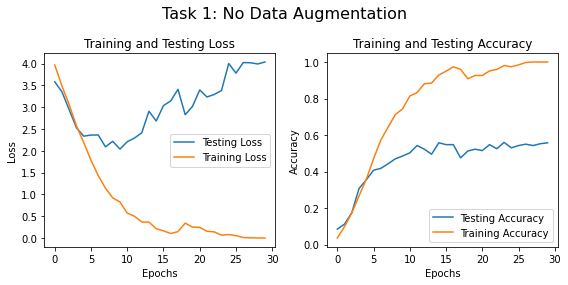

13/13 [==============================] - 2s 132ms/step


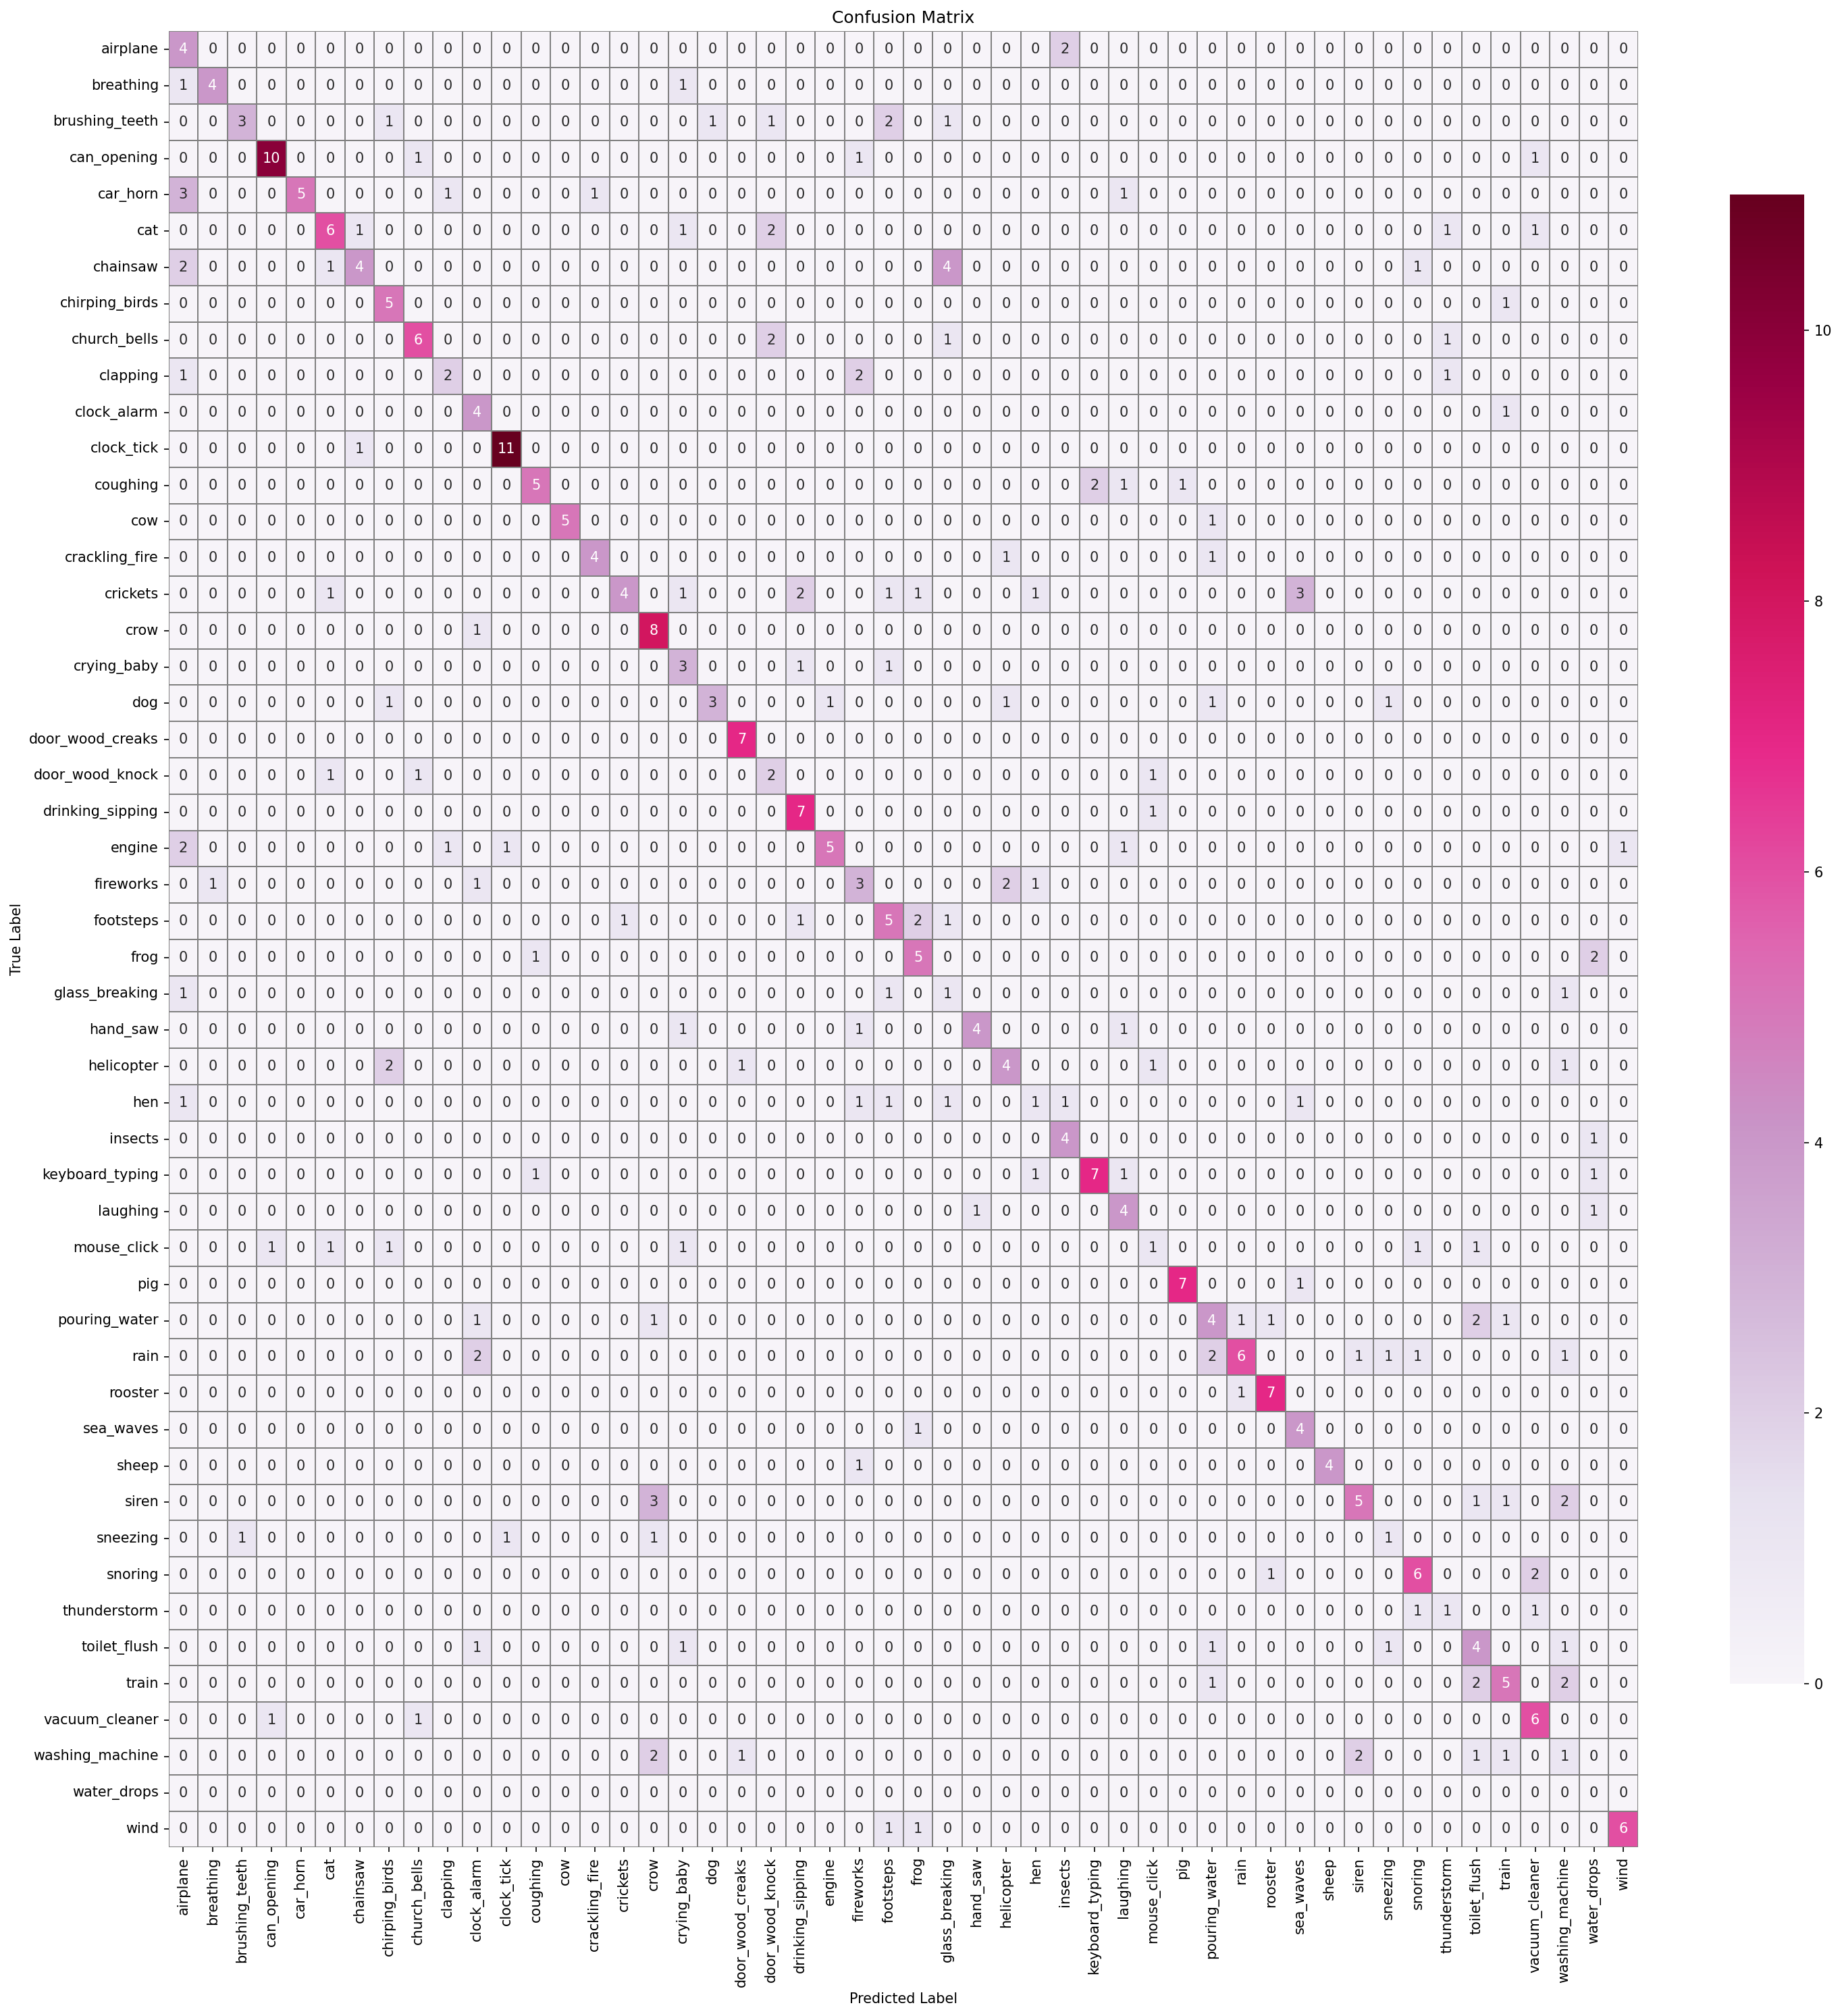

In [14]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(images_test, labels_test, verbose=0)
print(f"\n📊 Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}\n")

# Plot training & validation loss/accuracy curves
plot_loss_acc(history, 'Task 1: No Data Augmentation')

# Predict class probabilities on the test set
labels_prob_pred = model.predict(images_test)

#Convert predicted probabilities to class indices
labels_pred = np.argmax(labels_prob_pred, axis=1)

# Extract class names from metadata
class_names = np.unique(meta['category'])

#Plot confusion matrix
plot_confusion_matrix(labels_test, labels_pred, class_names)

After approximately 10 epochs, the validation (testing) loss is increasing, which means that the model starts overfitting the training data. According to the currently available literature, this likely happens due to insufficient data, so let's try data augmentation!

## Method 1: Use a Random Pitch Shift

### Define some functions (for start) to augment the data: pitch shifting, time strethcing 

In [94]:
def random_pitch_shift(y, sr, min_steps=-2, max_steps=2):
    """
    Randomly shifts the pitch of the audio.
    """
    n_steps = random.uniform(min_steps, max_steps)
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

def random_time_stretch(y, sr, min_rate=0.8, max_rate=1.2):
    """
    Randomly stretches the time of the audio.
    """
    rate = random.uniform(min_rate, max_rate)
    return librosa.effects.time_stretch(y, rate=rate)

### First, we process the audio files by splitting them into training and testing datasets, applying random pitch shifts to the training audios, and preparing all audio files for input into our CNN

In [103]:
# Define the local path to the folder containing the original audio files
audio_file_path = '/Users/xeniaodintsova/Desktop/ML_Project/audio'

# FIRST split the metadata into training and testing sets!!!
# We want to augment only the training data, then test our model on the original data!
meta_train, meta_test = train_test_split(meta, test_size=0.2, random_state=42, stratify=meta['target'])

# Define spectrogram shape
spect_height = 128
spect_width = 500

# Process TRAINING DATA WITH AUGMENTATION:
train_spectrograms = []
train_labels = []

print("Processing training data: original and with an augmentation...\n")

for index, row in meta_train[['filename', 'target']].iterrows():
    filename = row['filename']
    label = row['target']
    audio_path = os.path.join(audio_file_path, filename)
    
    try:
        y, sr = librosa.load(audio_path, sr=44100)
    
        # ORIGINAL VERSION OF THE DATA
        spect_orig = getSpect(y)
        if spect_orig.shape[1] < spect_width:
            pad = spect_width - spect_orig.shape[1]
            spect_orig = np.pad(spect_orig, ((0, 0), (0, pad)), mode='constant')
        else:
            spect_orig = spect_orig[:, :spect_width]

        train_spectrograms.append(spect_orig)
        train_labels.append(label)

        # AUGMENTED VERSION OF THE DATA
        y_aug = random_pitch_shift(y, sr)

        spect_aug = getSpect(y_aug)
        if spect_aug.shape[1] < spect_width:
            pad = spect_width - spect_aug.shape[1]
            spect_aug = np.pad(spect_aug, ((0, 0), (0, pad)), mode='constant')
        else:
            spect_aug = spect_aug[:, :spect_width]

        train_spectrograms.append(spect_aug)
        train_labels.append(label)

        print(f"✓ Train {index + 1}/{len(meta_train)}: {filename} (original + augmented)")

    except Exception as e:
        print(f"Error in train file {filename}: {e}")
    
    # TESTING DATA: ORIGINAL ONLY
test_spectrograms = []
test_labels = []

print("\nProcessing testing data (original only)...\n")

for index, row in meta_test[['filename', 'target']].iterrows():
    filename = row['filename']
    label = row['target']
    path = os.path.join(audio_file_path, filename)

    try:
        y, sr = librosa.load(path)

        spect = getSpect(y)
        if spect.shape[1] < spect_width:
            pad = spect_width - spect.shape[1]
            spect = np.pad(spect, ((0, 0), (0, pad)), mode='constant')
        else:
            spect = spect[:, :spect_width]

        test_spectrograms.append(spect)
        test_labels.append(label)

        print(f"✓ Test {index + 1}/{len(meta_test)}: {filename}")

    except Exception as e:
        print(f"Error in test file {filename}: {e}")

# Convert to arrays and expand dimensions
train_spectrograms = np.array(train_spectrograms, dtype=np.float32)[..., np.newaxis]
train_labels = np.array(train_labels)

test_spectrograms = np.array(test_spectrograms, dtype=np.float32)[..., np.newaxis]
test_labels = np.array(test_labels)

# Normalise the spectrograms
train_spectrograms = train_spectrograms / np.max(np.abs(train_spectrograms), axis=(1,2,3), keepdims=True)
test_spectrograms = test_spectrograms / np.max(np.abs(test_spectrograms), axis=(1,2,3), keepdims=True)

print("\n✅ Data processing complete!")
print(f"Train set shape: {train_spectrograms.shape} (should be 2x original train size)")
print(f"Test set shape: {test_spectrograms.shape} (unchanged)")

Processing training data: original and with an augmentation...

✓ Train 596/1600: 2-173607-A-39.wav (original + augmented)
✓ Train 881/1600: 3-123086-A-28.wav (original + augmented)
✓ Train 1800/1600: 5-212181-A-38.wav (original + augmented)
✓ Train 699/1600: 2-70367-A-33.wav (original + augmented)
✓ Train 672/1600: 2-60794-A-26.wav (original + augmented)
✓ Train 1915/1600: 5-242932-B-26.wav (original + augmented)
✓ Train 81/1600: 1-18755-B-4.wav (original + augmented)
✓ Train 1808/1600: 5-213836-A-9.wav (original + augmented)
✓ Train 326/1600: 1-69165-A-34.wav (original + augmented)
✓ Train 1098/1600: 3-170015-A-0.wav (original + augmented)
✓ Train 1238/1600: 4-132383-B-2.wav (original + augmented)
✓ Train 514/1600: 2-120586-A-6.wav (original + augmented)
✓ Train 1496/1600: 4-195451-A-44.wav (original + augmented)
✓ Train 1876/1600: 5-233019-A-31.wav (original + augmented)
✓ Train 320/1600: 1-67152-A-17.wav (original + augmented)
✓ Train 659/1600: 2-54086-A-43.wav (original + augmente

### Now let's train our CNN, then evaluate its performance on the test dataset and plot the confusion matrix

In [97]:
model = CNN((128,500,1))

model.fit(train_spectrograms, train_labels, epochs=64, batch_size=66,
          validation_data=(test_spectrograms, test_labels), verbose=1)

print("🎉 Model trained successfully!")

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_37 (Resizing)      (None, 64, 128, 1)        0         
                                                                 
 conv2d_131 (Conv2D)         (None, 62, 126, 64)       640       
                                                                 
 max_pooling2d_131 (MaxPooli  (None, 31, 63, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_132 (Conv2D)         (None, 29, 61, 64)        36928     
                                                                 
 max_pooling2d_132 (MaxPooli  (None, 14, 30, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_133 (Conv2D)         (None, 12, 28, 128)     


📊 Test Loss: 10.0762
✅ Test Accuracy: 0.2400



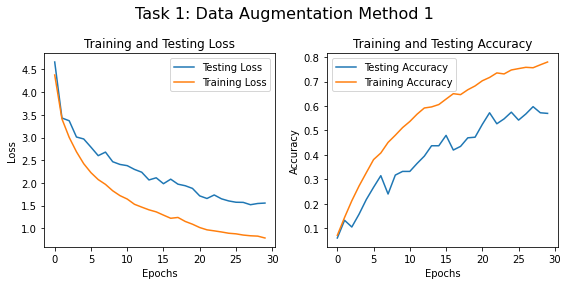

13/13 [==============================] - 2s 90ms/step


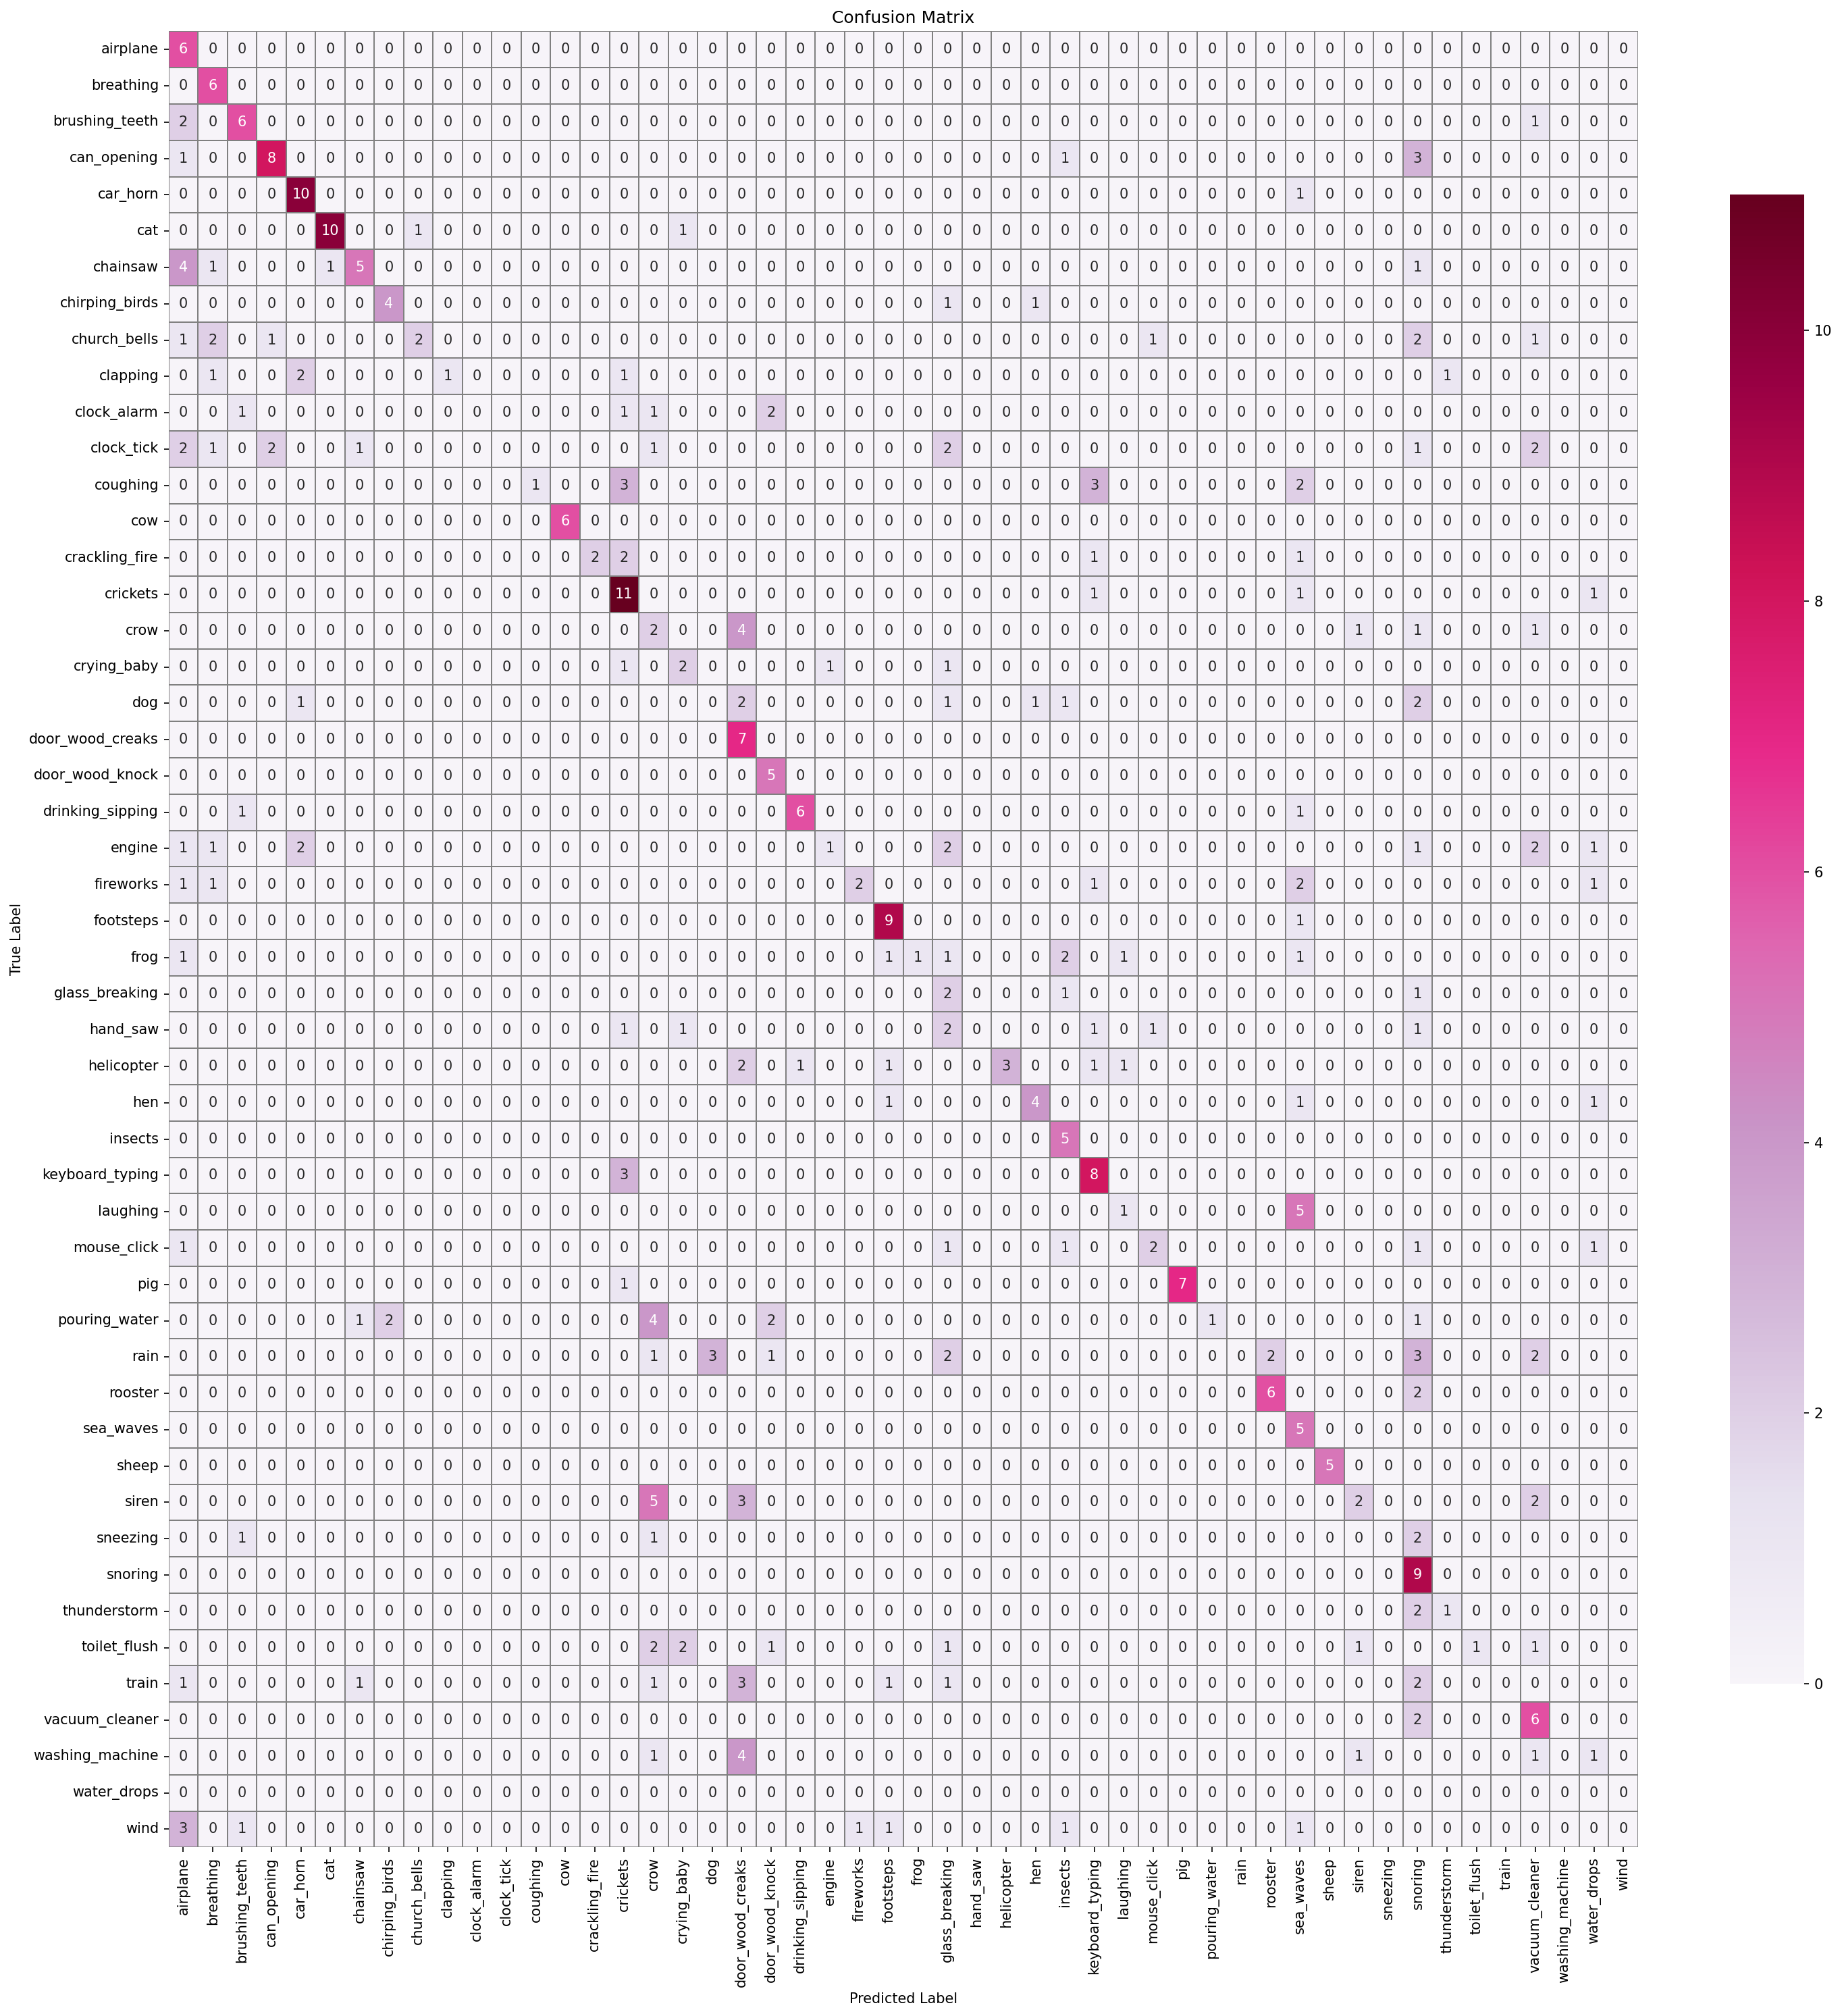

In [98]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(test_spectrograms, test_labels, verbose=0)
print(f"\n📊 Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}\n")

# Plot training & validation loss/accuracy curves
plot_loss_acc(history, 'Task 1: Data Augmentation Method 1')

# Predict class probabilities on the test set
predicted_probabilities = model.predict(test_spectrograms)

# Convert predicted probabilities to class indices
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Extract class names from metadata
class_names = np.unique(meta['category'])

# Plot confusion matrix
plot_confusion_matrix(test_labels, predicted_classes, class_names)

This result highlights the limitations of the current model architecture. Despite using pitch-shifted data for augmentation, the network begins to overfit after just a few epochs and fails to generalise effectively. Test accuracy drops significantly (from ~56% to ~24%), while test loss increases sharply (from ~4 to over 10), indicating that the model cannot cope with the added variability. The confusion matrix further confirms this, showing a large number of misclassifications—underscoring the need for a more robust CNN architecture when using augmentation techniques.

## But before we move on...

### Let's define a function here, for splitting the audios into training and testing datasets, applying the chosen augentation technique ONLY to the training data, and preparing all audios for input into a CNN model
### (since we will be repeating this process many times)

In [99]:
def process_data(meta, audio_file_path, augmentation_function,
                 spect_height=128, spect_width=500, test_size=0.2, random_state=42):
    """
    Splits metadata, applies the given augmentation function to training data only,
    and converts all audio files into mel spectrograms of fixed size.

    Parameters:
        meta (DataFrame): Metadata with 'filename' and 'target' columns.
        audio_file_path (str): Path to the folder with original audio files.
        augmentation_function (function): Function(y, sr) → augmented y (always applied to training).
        spect_height (int): Height of spectrogram (default 128).
        spect_width (int): Width of spectrogram (default 500).
        test_size (float): Proportion of test samples.
        random_state (int): Seed for reproducibility.

    Returns:
        train_spectrograms, train_labels, test_spectrograms, test_labels: Preprocessed datasets.
    """

    # Define the local path to the folder containing the original audio files
    audio_file_path = '/Users/xeniaodintsova/Desktop/ML_Project/audio'

    # Split metadata
    meta_train, meta_test = train_test_split(meta, test_size=test_size, random_state=random_state,
                                             stratify=meta['target'])
    
    
    # Process TRAINING DATA WITH AUGMENTATION:
    train_spectrograms = []
    train_labels = []

    print("Processing training data: original and with an augmentation...\n")

    for index, row in meta_train[['filename', 'target']].iterrows():
        filename = row['filename']
        label = row['target']
        audio_path = os.path.join(audio_file_path, filename)
    
        try:
            y, sr = librosa.load(audio_path, sr=44100)
    
            # ORIGINAL VERSION OF THE DATA
            spect_orig = getSpect(y)
            if spect_orig.shape[1] < spect_width:
                pad = spect_width - spect_orig.shape[1]
                spect_orig = np.pad(spect_orig, ((0, 0), (0, pad)), mode='constant')
            else:
                spect_orig = spect_orig[:, :spect_width]

            train_spectrograms.append(spect_orig)
            train_labels.append(label)

            # AUGMENTED VERSION OF THE DATA
            y_aug = random_pitch_shift(y, sr)

            spect_aug = getSpect(y_aug)
            if spect_aug.shape[1] < spect_width:
                pad = spect_width - spect_aug.shape[1]
                spect_aug = np.pad(spect_aug, ((0, 0), (0, pad)), mode='constant')
            else:
                spect_aug = spect_aug[:, :spect_width]

            train_spectrograms.append(spect_aug)
            train_labels.append(label)

            print(f"✓ Train {index + 1}/{len(meta_train)}: {filename} (original + augmented)")

        except Exception as e:
            print(f"Error in train file {filename}: {e}")
    
        # TESTING DATA: ORIGINAL ONLY
    test_spectrograms = []
    test_labels = []

    print("\nProcessing testing data (original only)...\n")

    for index, row in meta_test[['filename', 'target']].iterrows():
        filename = row['filename']
        label = row['target']
        path = os.path.join(audio_file_path, filename)

        try:
            y, sr = librosa.load(path)

            spect = getSpect(y)
            if spect.shape[1] < spect_width:
                pad = spect_width - spect.shape[1]
                spect = np.pad(spect, ((0, 0), (0, pad)), mode='constant')
            else:
                spect = spect[:, :spect_width]

            test_spectrograms.append(spect)
            test_labels.append(label)

            print(f"✓ Test {index + 1}/{len(meta_test)}: {filename}")

        except Exception as e:
            print(f"Error in test file {filename}: {e}")

    # Convert to arrays and expand dimensions
    train_spectrograms = np.array(train_spectrograms, dtype=np.float32)[..., np.newaxis]
    train_labels = np.array(train_labels)

    test_spectrograms = np.array(test_spectrograms, dtype=np.float32)[..., np.newaxis]
    test_labels = np.array(test_labels)

    # Normalise the spectrograms
    train_spectrograms = train_spectrograms / np.max(np.abs(train_spectrograms), axis=(1,2,3), keepdims=True)
    test_spectrograms = test_spectrograms / np.max(np.abs(test_spectrograms), axis=(1,2,3), keepdims=True)

    print("\n✅ Data processing complete!")
    print(f"Train set shape: {train_spectrograms.shape} (should be 2x original train size)")
    print(f"Test set shape: {test_spectrograms.shape} (unchanged)")
    
    return train_spectrograms, train_labels, test_spectrograms, test_labels

## Define an Optimised Convolutional Neural Network

In [104]:
def OptimisedCNN(input_shape):
    model = keras.Sequential()

    # Input and resizing
    model.add(Input(shape=input_shape))
    model.add(keras.layers.Resizing(64, 128))  # resize to 64x128 (HxW)

    # Block 1: Conv + BN + ReLU + MaxPool + Dropout
    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 2
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 3
    model.add(Conv2D(128, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(150, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(50, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model

### Let's now reattempt Method 1 with the optimised CNN model 

In [105]:
model = OptimisedCNN((128,500,1))

model.fit(train_spectrograms, train_labels, epochs=30, batch_size=64,
          validation_data=(test_spectrograms, test_labels), verbose=1)

print("🎉 Model trained successfully!")

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_39 (Resizing)      (None, 64, 128, 1)        0         
                                                                 
 conv2d_138 (Conv2D)         (None, 62, 126, 32)       320       
                                                                 
 batch_normalization_72 (Bat  (None, 62, 126, 32)      128       
 chNormalization)                                                
                                                                 
 activation_54 (Activation)  (None, 62, 126, 32)       0         
                                                                 
 max_pooling2d_138 (MaxPooli  (None, 31, 63, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_139 (Conv2D)         (None, 29, 61, 64)      


📊 Test Loss: 2.0469
✅ Test Accuracy: 0.5175



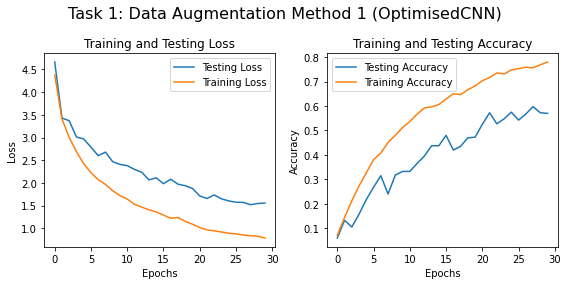

13/13 [==============================] - 1s 39ms/step


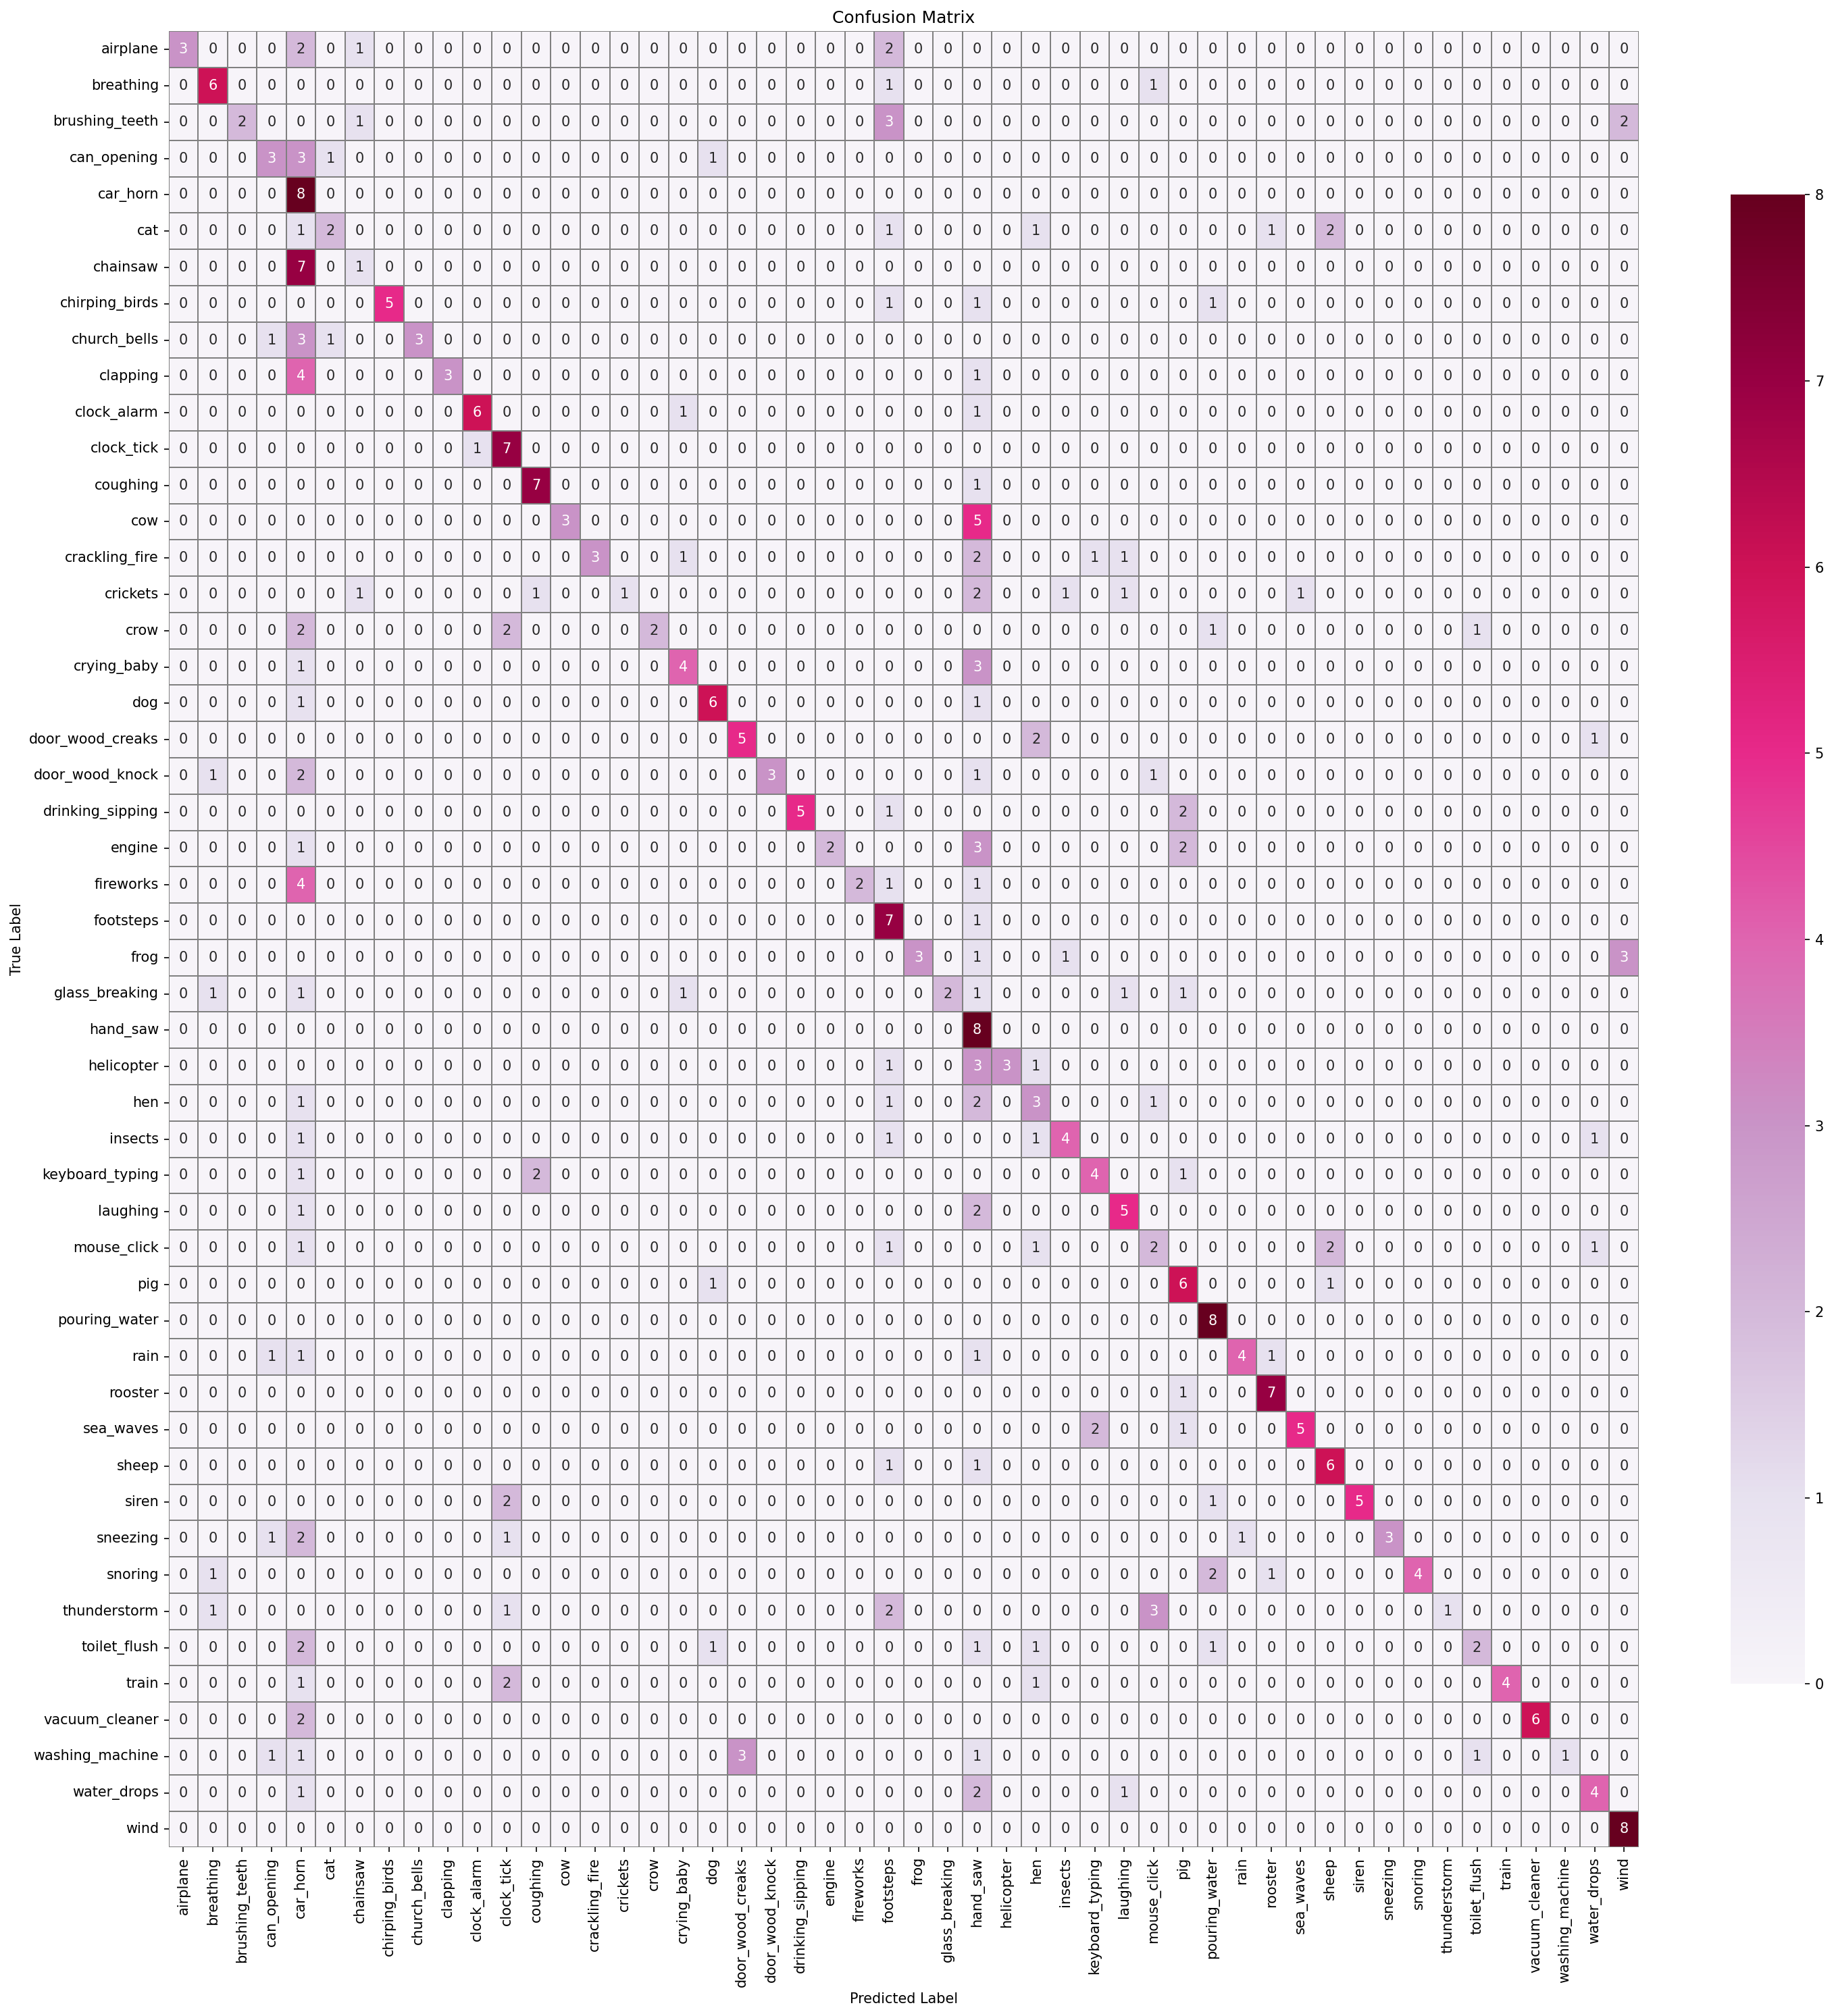

In [109]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(test_spectrograms, test_labels, verbose=0)
print(f"\n📊 Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}\n")

# Plot training & validation loss/accuracy curves
plot_loss_acc(history, 'Task 1: Data Augmentation Method 1 (OptimisedCNN)')

# Predict class probabilities on the test set
predicted_probabilities = model.predict(test_spectrograms)

# Convert predicted probabilities to class indices
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Extract class names from metadata
class_names = np.unique(meta['category'])

# Plot confusion matrix
plot_confusion_matrix(test_labels, predicted_classes, class_names)

In the case of the optimised CNN trained on pitch-shifted data, test accuracy reaches ~52%, compared to ~24% in the original CNN, and test loss drops from ~4.0 to ~1.6. This suggests significantly better generalisation. However, overfitting is still present, as the gap between training and testing performance remains wide. To address this, further improvements in CNN architecture (such as increasing dropout and introducing a learning rate scheduler) could help stabilise learning and reduce test loss.

## Define a Further Optimised Convolutional Neural Network
### with Added Learning Rate Scheduler & Increased Dropout

In [110]:
# Define the learning rate scheduler
def learning_rate_schedule(epoch, lr):
    if epoch < 20:
        return 0.001
    else:
        return 0.0005 # fine-tuning phase
    
# Create the callback object
lr_scheduler = LearningRateScheduler(learning_rate_schedule)

# Further optimised CNN architecture
def FurtherOptimisedCNN(input_shape):
    model = keras.Sequential()

    # Input and resizing
    model.add(Input(shape=input_shape))
    model.add(keras.layers.Resizing(64, 128))  # resize to 64x128 (HxW)

    # Block 1: Conv + BN + ReLU + MaxPool + Dropout
    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 2
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))  # slightly increased dropout here

    # Block 3
    model.add(Conv2D(128, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dropout(0.6))
    model.add(Dense(125, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.7))  # increased dropout here too
    model.add(Dense(50, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model, lr_scheduler

In [111]:
train_spectrograms, train_labels, test_spectrograms, test_labels = process_data(meta, audio_file_path, 
                                        augmentation_function=random_pitch_shift, spect_height=128, 
                                        spect_width=500, test_size=0.2, random_state=42)

Processing training data: original and with an augmentation...

✓ Train 596/1600: 2-173607-A-39.wav (original + augmented)
✓ Train 881/1600: 3-123086-A-28.wav (original + augmented)
✓ Train 1800/1600: 5-212181-A-38.wav (original + augmented)
✓ Train 699/1600: 2-70367-A-33.wav (original + augmented)
✓ Train 672/1600: 2-60794-A-26.wav (original + augmented)
✓ Train 1915/1600: 5-242932-B-26.wav (original + augmented)
✓ Train 81/1600: 1-18755-B-4.wav (original + augmented)
✓ Train 1808/1600: 5-213836-A-9.wav (original + augmented)
✓ Train 326/1600: 1-69165-A-34.wav (original + augmented)
✓ Train 1098/1600: 3-170015-A-0.wav (original + augmented)
✓ Train 1238/1600: 4-132383-B-2.wav (original + augmented)
✓ Train 514/1600: 2-120586-A-6.wav (original + augmented)
✓ Train 1496/1600: 4-195451-A-44.wav (original + augmented)
✓ Train 1876/1600: 5-233019-A-31.wav (original + augmented)
✓ Train 320/1600: 1-67152-A-17.wav (original + augmented)
✓ Train 659/1600: 2-54086-A-43.wav (original + augmente

In [122]:
# Train the further optimised CNN model
model, lr_scheduler = FurtherOptimisedCNN((128, 500, 1))

history = model.fit(train_spectrograms, train_labels, validation_data=(test_spectrograms, test_labels),
                    epochs=30, batch_size=64, callbacks=[lr_scheduler], verbose=1)

print("🎉 Model trained successfully!")

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_48 (Resizing)      (None, 64, 128, 1)        0         
                                                                 
 conv2d_165 (Conv2D)         (None, 62, 126, 32)       320       
                                                                 
 batch_normalization_108 (Ba  (None, 62, 126, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_81 (Activation)  (None, 62, 126, 32)       0         
                                                                 
 max_pooling2d_165 (MaxPooli  (None, 31, 63, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_166 (Conv2D)         (None, 29, 61, 64)      


📊 Test Loss: 1.4480
✅ Test Accuracy: 0.6175



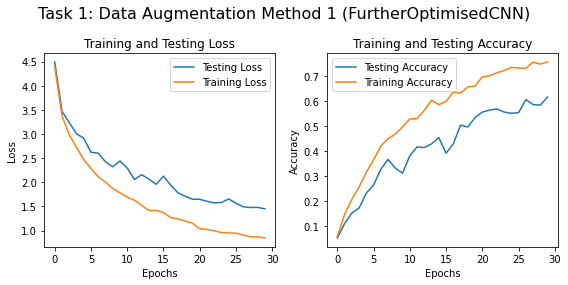

13/13 [==============================] - 2s 56ms/step


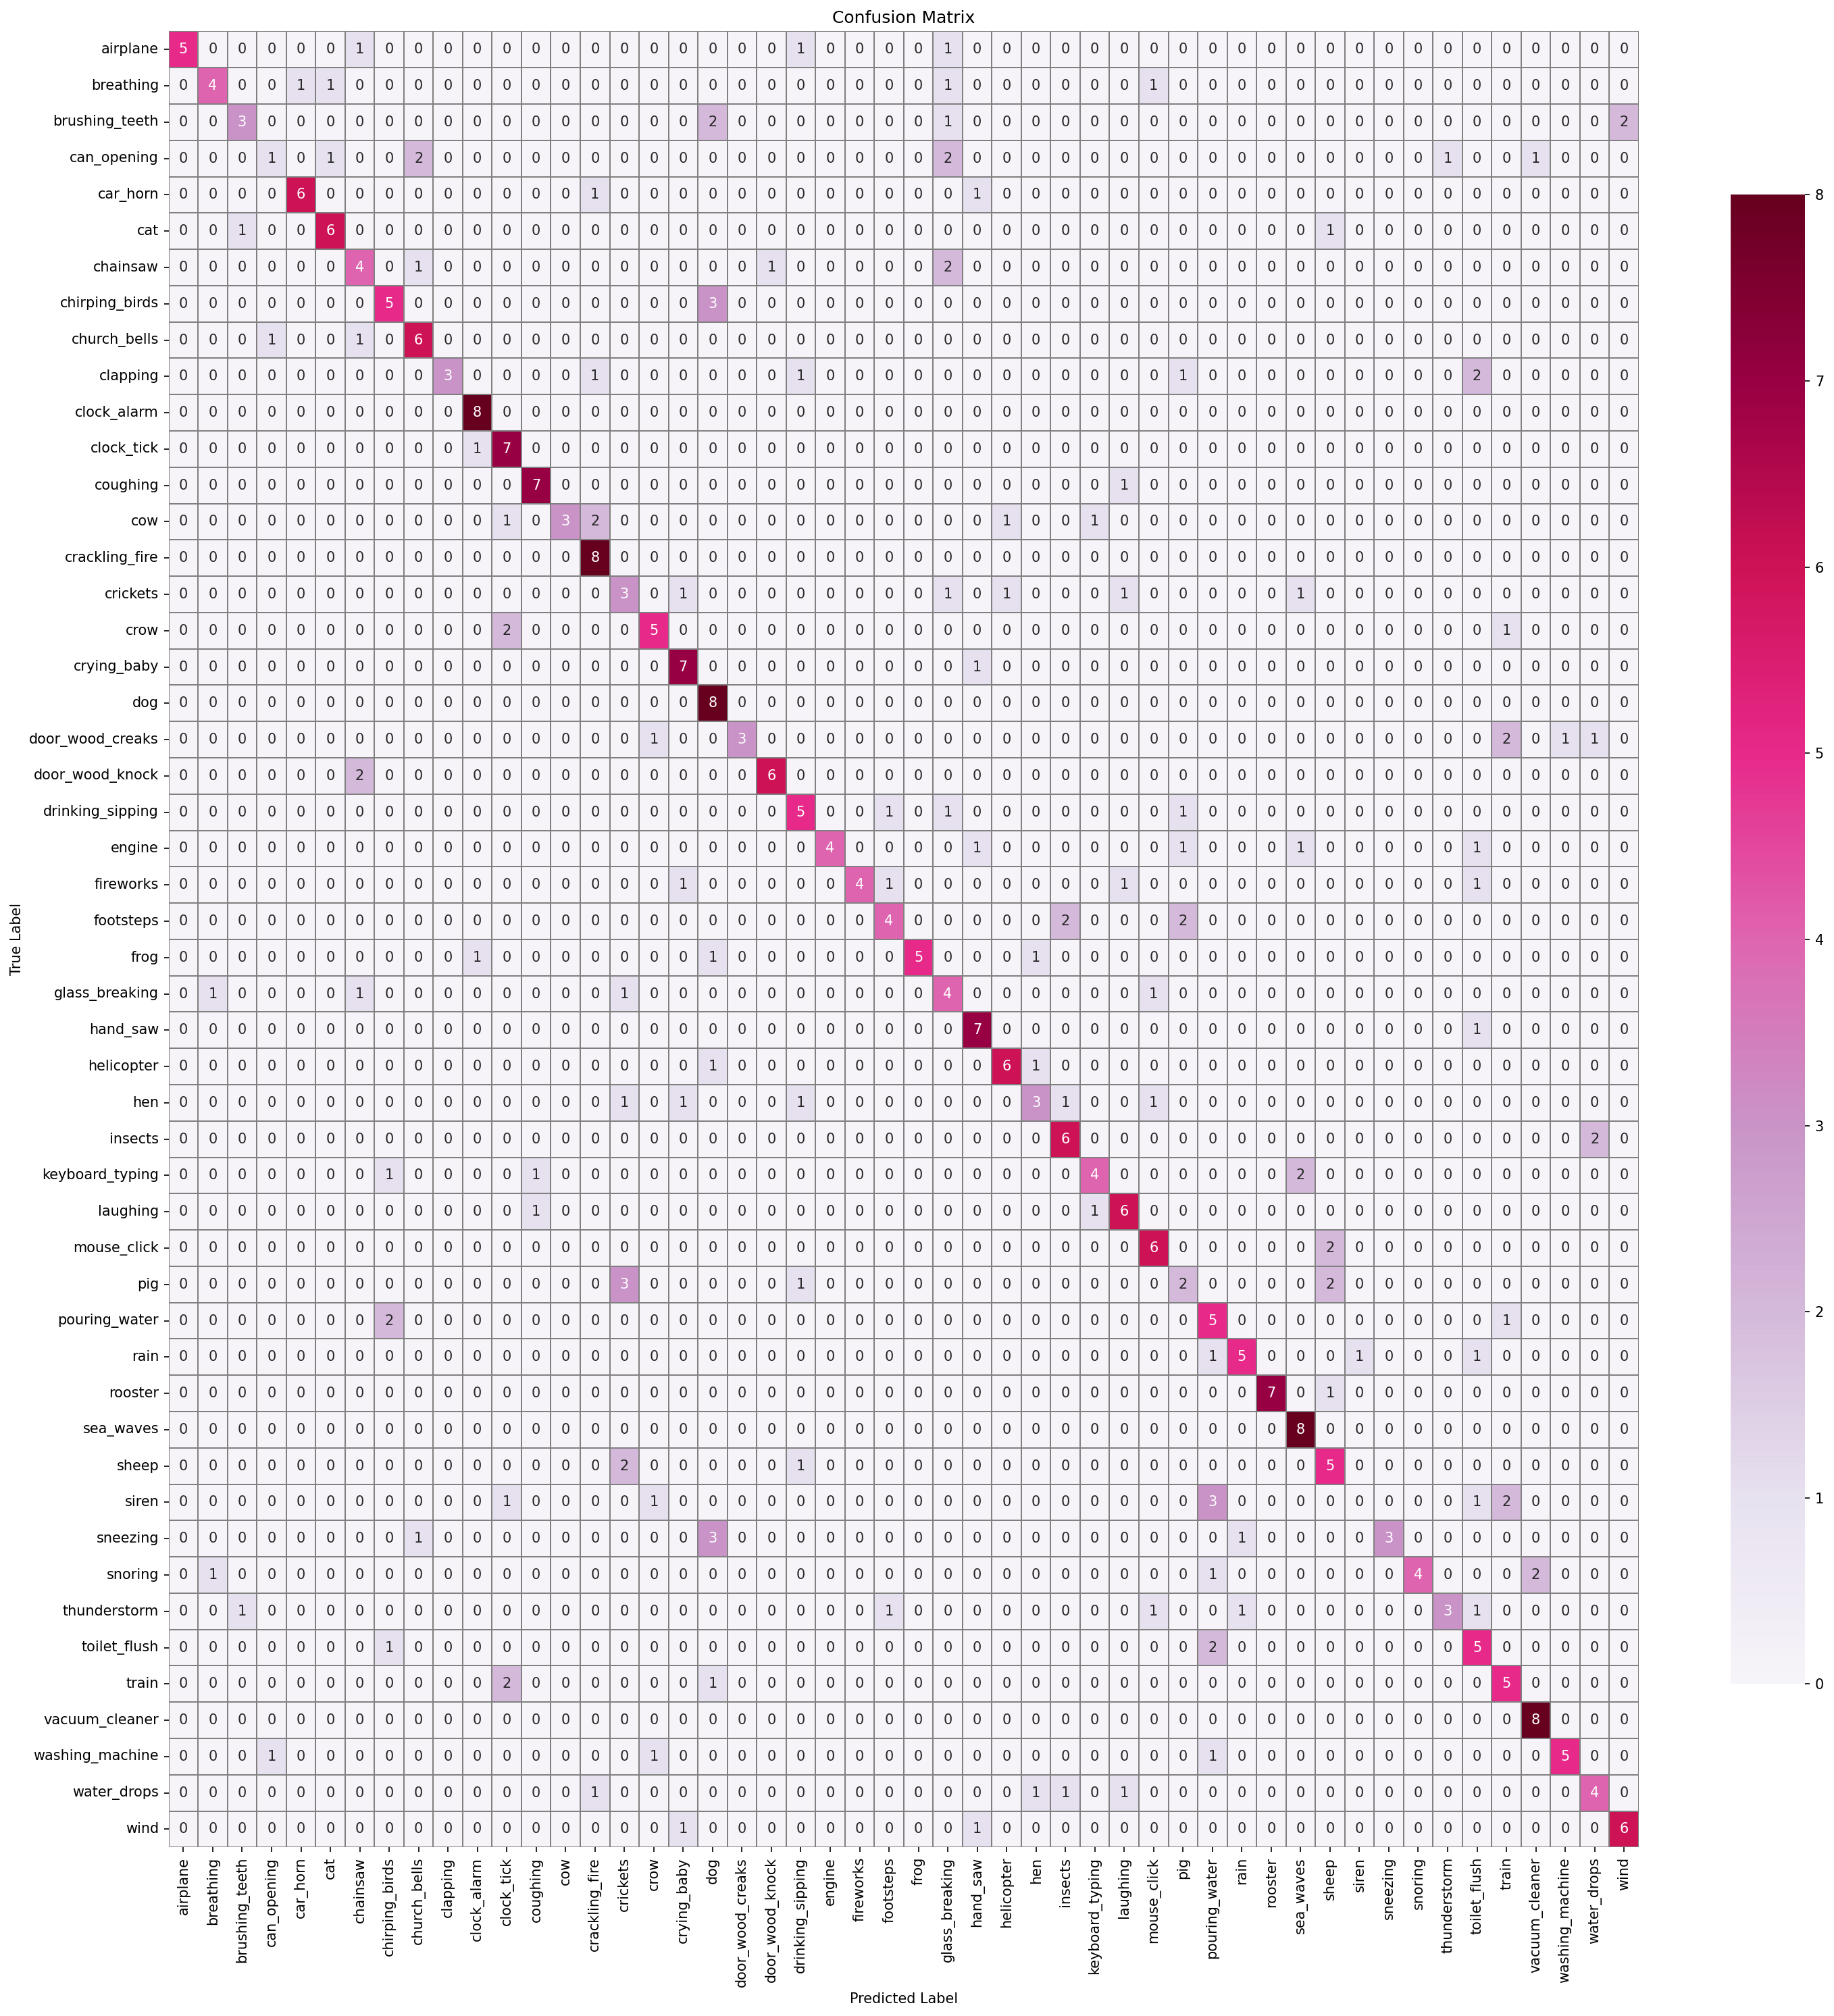

In [123]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(test_spectrograms, test_labels, verbose=0)
print(f"\n📊 Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}\n")

# Plot training & validation loss/accuracy curves
plot_loss_acc(history, 'Task 1: Data Augmentation Method 1 (FurtherOptimisedCNN)')

# Predict class probabilities on the test set
predicted_probabilities = model.predict(test_spectrograms)

# Convert predicted probabilities to class indices
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Extract class names from metadata
class_names = np.unique(meta['category'])

# Plot confusion matrix
plot_confusion_matrix(test_labels, predicted_classes, class_names)

The Further Optimised CNN outperforms the previous Optimised CNN both in accuracy and generalisation. The test accuracy improves from 51.8% to 61.8%, and test loss drops from 2.05 to 1.45, reflecting better performance and more confident predictions. The learning curves also show reduced overfitting and a more consistent training pattern, while the confusion matrix indicates fewer misclassifications. 

These results suggest that adjustments like introducing a learning rate schedule and increasing dropout were effective in stabilising training and boosting generalisation.

Let's more on to applying time stretches now!

## Method 2: Use a Random Time Stretch


In [8]:
train_spectrograms, train_labels, test_spectrograms, test_labels = process_data(meta, audio_file_path, 
                                    augmentation_function=random_time_stretch, spect_height=128, 
                                        spect_width=500, test_size=0.2, random_state=42)

### Try optimised CNN model first?

In [139]:
# Train the optimised CNN model
model = OptimisedCNN((128,500,1))
model.fit(train_spectrograms, train_labels, epochs=50, batch_size=64,
          validation_data=(test_spectrograms, test_labels), verbose=1)

print("🎉 Model trained successfully!")

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_30 (Resizing)      (None, 64, 128, 1)        0         
                                                                 
 conv2d_90 (Conv2D)          (None, 62, 126, 32)       320       
                                                                 
 batch_normalization_101 (Ba  (None, 62, 126, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_78 (Activation)  (None, 62, 126, 32)       0         
                                                                 
 max_pooling2d_90 (MaxPoolin  (None, 31, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_91 (Conv2D)          (None, 29, 61, 64)      


📊 Test Loss: 1.7389
✅ Test Accuracy: 0.5625



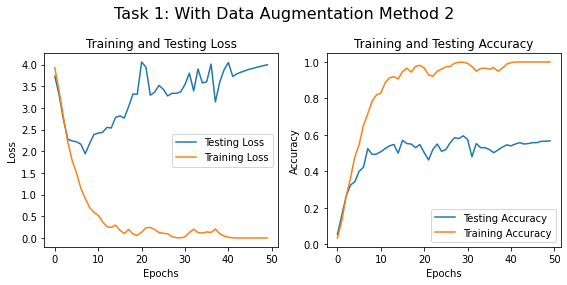

13/13 [==============================] - 1s 53ms/step


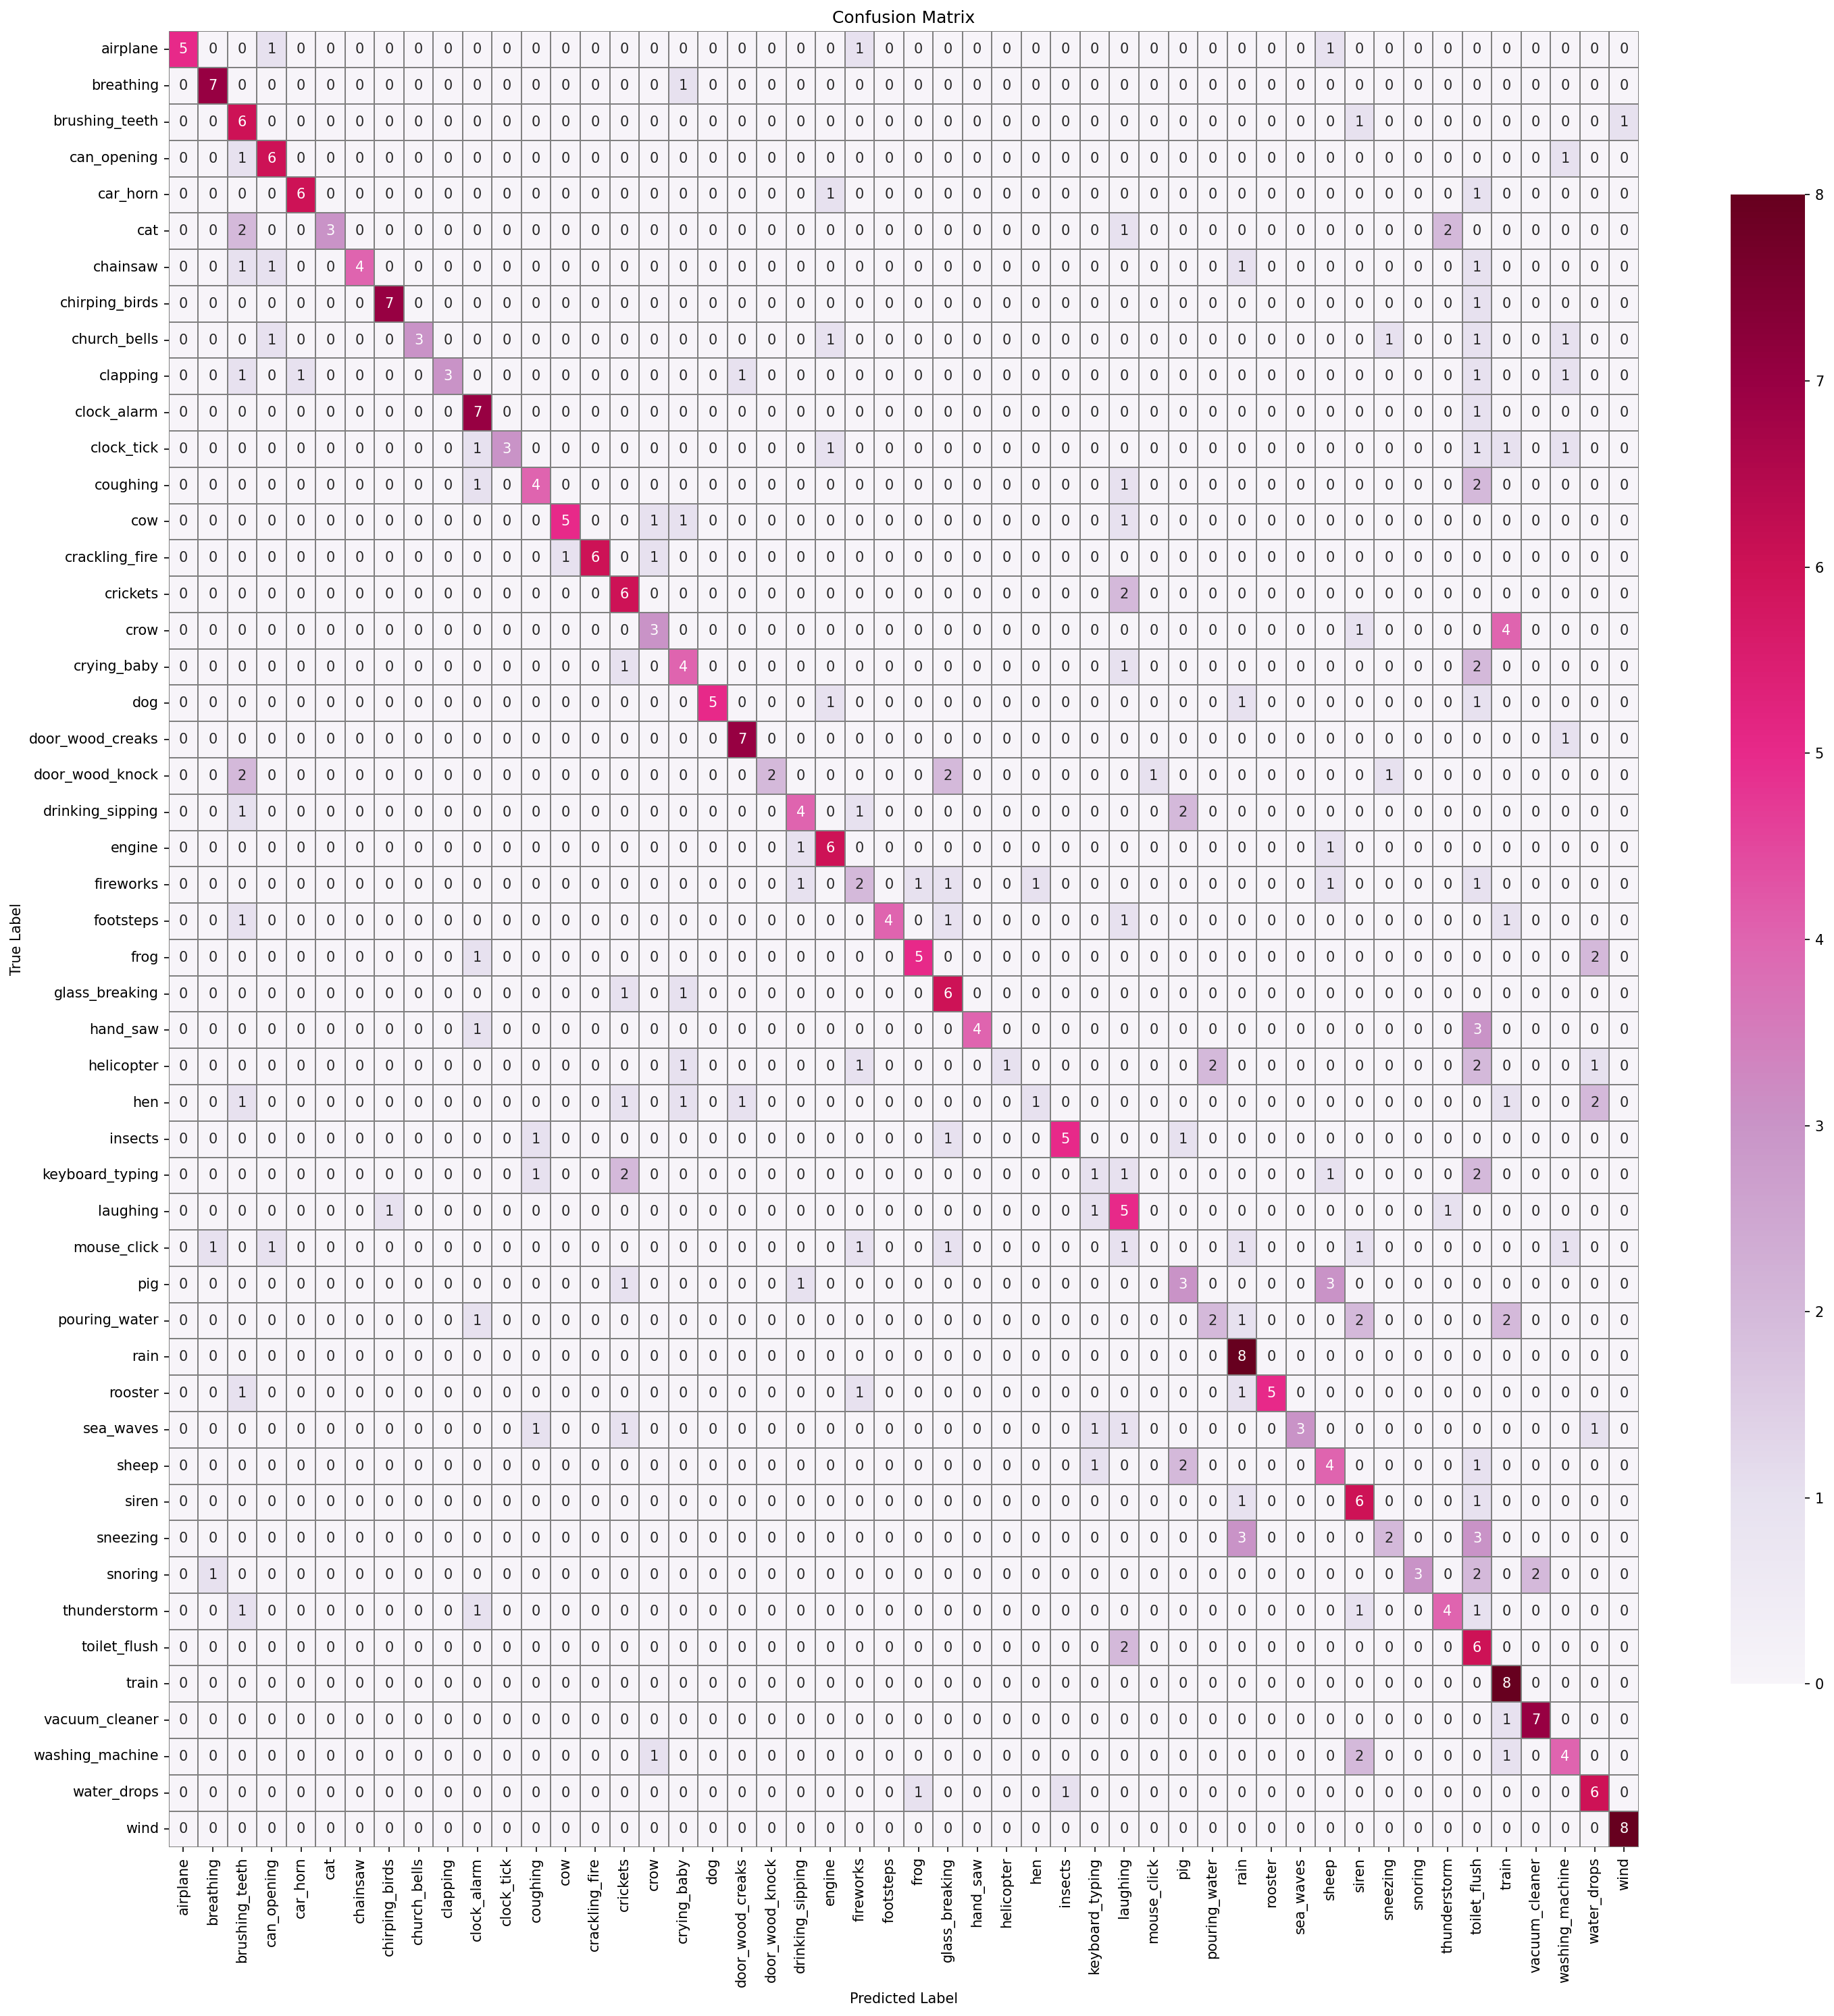

In [140]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(test_spectrograms, test_labels, verbose=0)
print(f"\n📊 Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}\n")

# Plot training & validation loss/accuracy curves
plot_loss_acc(history, 'Task 1: Data Augmentation Method 2')

# Predict class probabilities on the test set
predicted_probabilities = model.predict(test_spectrograms)

# Convert predicted probabilities to class indices
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Extract class names from metadata
class_names = np.unique(meta['category'])

# Plot confusion matrix
plot_confusion_matrix(test_labels, predicted_classes, class_names)

This optimised CNN model, trained with time stretched data, achieves a decent test accuracy of ~56.3%. However, the widening gap between training and testing curves suggests that overfitting is still present. While the confusion matrix indicates reasonable class-wise performance, further regularisation may help enhance performance (as shown in the previous method).

So now let's try to train the further optimised CNN model on the same (time stretched) data

### Reattempt Method 2 with the Further Optimised CNN Model

In [20]:
# Train the further optimised CNN model
model, lr_scheduler = FurtherOptimisedCNN((128, 500, 1))

history = model.fit(train_spectrograms, train_labels,
                    validation_data=(test_spectrograms, test_labels), epochs=50, batch_size=32, 
                    callbacks=[lr_scheduler], verbose=1)

print("🎉 Model trained successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 128, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 62, 126, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 62, 126, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 62, 126, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 61, 64)        1

2025-04-02 01:37:36.213573: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
50/50 [==============================] - 9s 158ms/step - loss: 4.5101 - accuracy: 0.0475 - val_loss: 8.6331 - val_accuracy: 0.0375 - lr: 0.0020
Epoch 2/50
50/50 [==============================] - 8s 155ms/step - loss: 3.7735 - accuracy: 0.0844 - val_loss: 4.3536 - val_accuracy: 0.0525 - lr: 0.0020
Epoch 3/50
50/50 [==============================] - 8s 164ms/step - loss: 3.4111 - accuracy: 0.1163 - val_loss: 3.2753 - val_accuracy: 0.1225 - lr: 0.0020
Epoch 4/50
50/50 [==============================] - 8s 163ms/step - loss: 3.1386 - accuracy: 0.1663 - val_loss: 2.7563 - val_accuracy: 0.2375 - lr: 0.0020
Epoch 5/50
50/50 [==============================] - 8s 165ms/step - loss: 2.8761 - accuracy: 0.1963 - val_loss: 2.7099 - val_accuracy: 0.2300 - lr: 0.0020
Epoch 6/50
50/50 [==============================] - 8s 162ms/step - loss: 2.7221 - accuracy: 0.2444 - val_loss: 2.5843 - val_accuracy: 0.2800 - lr: 0.0020
Epoch 7/50
50/50 [==============================] - 8s 168ms/step - lo


📊 Test Loss: 1.2874
✅ Test Accuracy: 0.6150



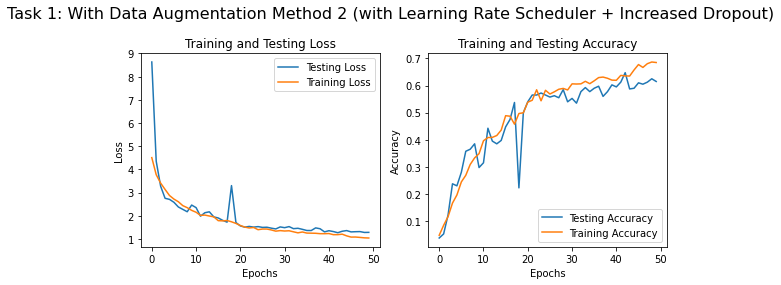

13/13 [==============================] - 1s 40ms/step


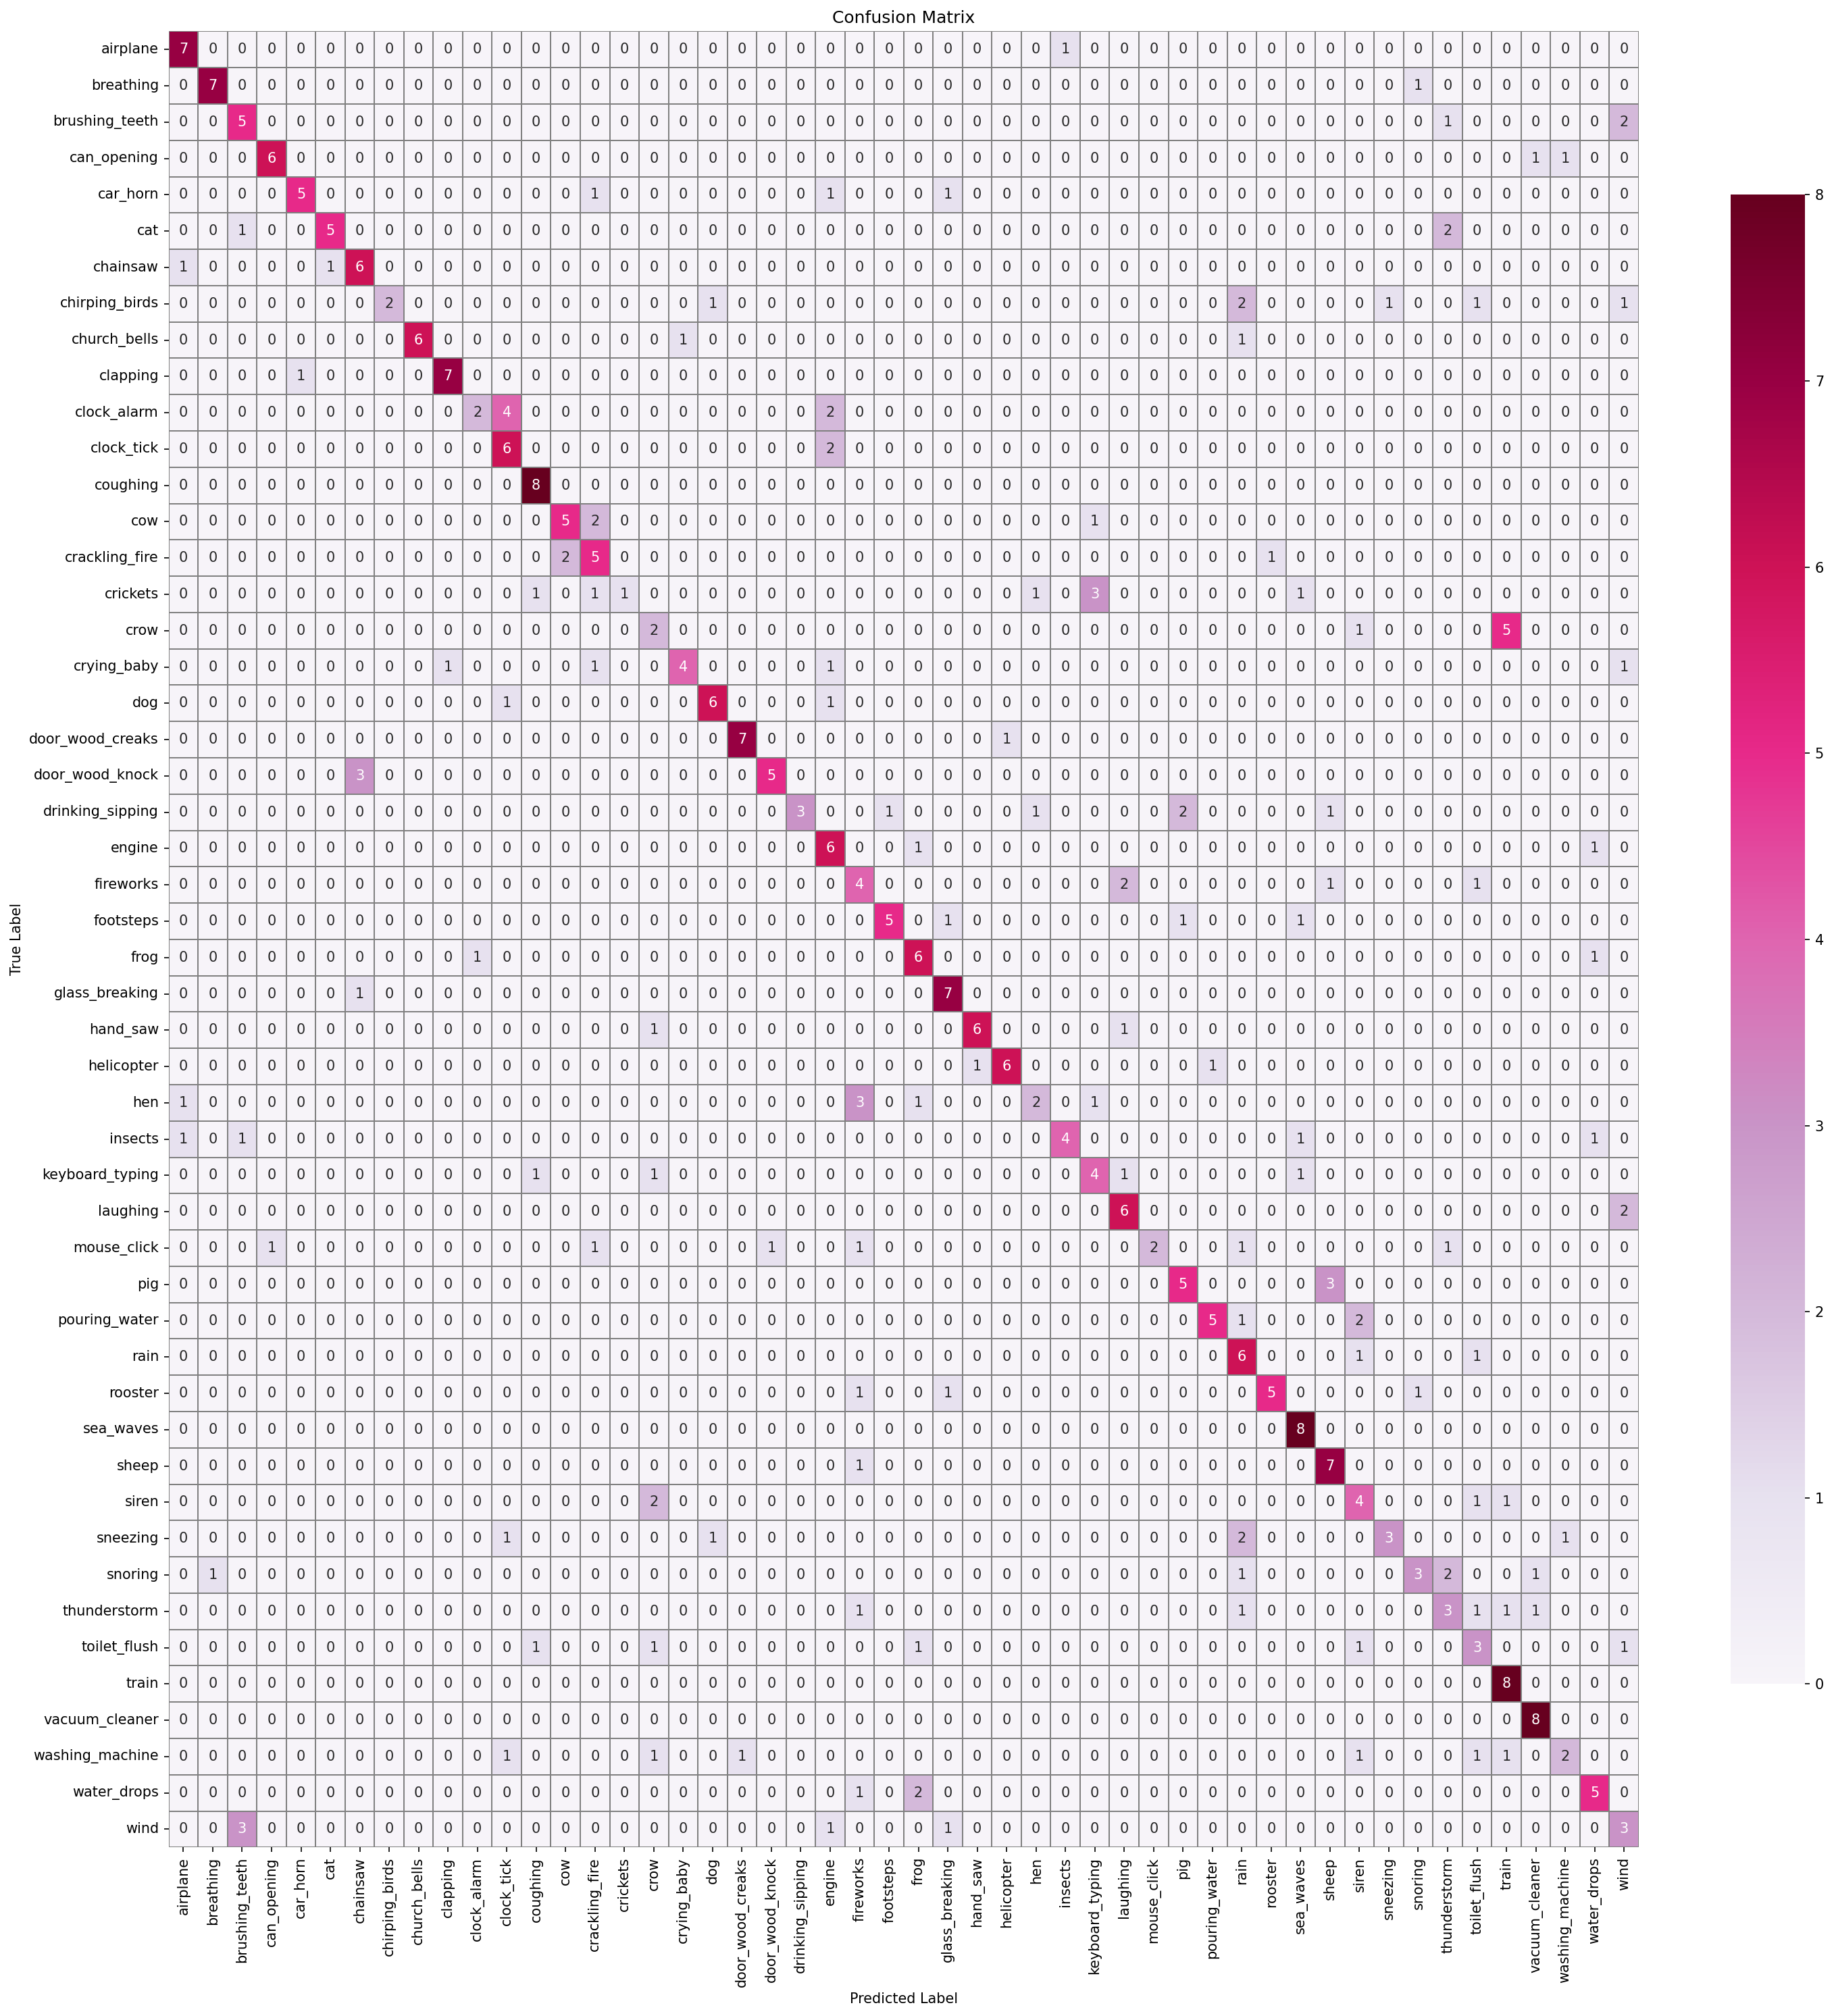

In [25]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(test_spectrograms, test_labels, verbose=0)
print(f"\n📊 Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}\n")

# Plot training & validation loss/accuracy curves
plot_loss_acc(history, 'Task 1: With Data Augmentation Method 2 (with Learning Rate Scheduler + Increased Dropout)')

# Predict class probabilities on the test set
predicted_probabilities = model.predict(test_spectrograms)

# Convert predicted probabilities to class indices
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Extract class names from metadata
class_names = np.unique(meta['category'])

# Plot confusion matrix
plot_confusion_matrix(test_labels, predicted_classes, class_names)

Transitioning from the optimised CNN to the further optimised version leads to a notable performance improvement. Test accuracy increases from ~56% to ~62%, while test loss decreases from 1.74 to 1.29, indicating enhanced generalisation. 

The training and validation curves in the updated model are smoother and more stable, with significsntly less overfitting. Additionally, the confusion matrix also appears denser along the diagonal, suggesting better class discrimination overall.

## Method 3: Apply White Noise

In [210]:
def adjust_SNR(signal, noise, snr=[10,17]):
    '''
    Parameters:
        signal (ndarray): The input signal to which noise is added.
        noise (ndarray): The noise to be added to the signal
        snr (float): range of Possible signal to noise ratios

    Returns:
        ndarray: The signal with pink noise added.
    '''
    snr = np.random.uniform(*snr)

    # Ensure SNR does not lead to overflow
    snr_val = 10**(snr / 20)
    if np.isinf(snr_val) or np.isnan(snr_val):
        # Handle extreme SNR values or set to a default
        snr_val = 10**(10.5 / 20)  # Example: default to 7 dB

    rms_signal = np.sqrt(np.mean(signal**2))
    rms_noise = rms_signal / (10**(snr_val / 20))

    noise *= rms_noise / np.sqrt(np.mean(noise**2))
    return noise

def apply_white_noise(signal, sr):
    """
    Add white noise to the input signal.

    Parameters:
        signal (ndarray): The input signal to which white noise will be added.
        snr (float): The desired Signal-to-Noise Ratio.

    Returns:
        ndarray: The signal with white noise added.
    """
    # Generate white noise array from Gaussian distribution
    white_noise = np.random.normal(0, 1, len(signal))

    # Adjust the amplitude in time domain for desired SNR
    white_noise = adjust_SNR(signal,white_noise)

    return signal + white_noise

In [125]:
train_spectrograms, train_labels, test_spectrograms, test_labels = process_data(meta, audio_file_path, 
                                        augmentation_function=apply_white_noise, spect_height=128, 
                                        spect_width=500, test_size=0.2, random_state=42)

Processing training data: original and with an augmentation...

✓ Train 596/1600: 2-173607-A-39.wav (original + augmented)
✓ Train 881/1600: 3-123086-A-28.wav (original + augmented)
✓ Train 1800/1600: 5-212181-A-38.wav (original + augmented)
✓ Train 699/1600: 2-70367-A-33.wav (original + augmented)
✓ Train 672/1600: 2-60794-A-26.wav (original + augmented)
✓ Train 1915/1600: 5-242932-B-26.wav (original + augmented)
✓ Train 81/1600: 1-18755-B-4.wav (original + augmented)
✓ Train 1808/1600: 5-213836-A-9.wav (original + augmented)
✓ Train 326/1600: 1-69165-A-34.wav (original + augmented)
✓ Train 1098/1600: 3-170015-A-0.wav (original + augmented)
✓ Train 1238/1600: 4-132383-B-2.wav (original + augmented)
✓ Train 514/1600: 2-120586-A-6.wav (original + augmented)
✓ Train 1496/1600: 4-195451-A-44.wav (original + augmented)
✓ Train 1876/1600: 5-233019-A-31.wav (original + augmented)
✓ Train 320/1600: 1-67152-A-17.wav (original + augmented)
✓ Train 659/1600: 2-54086-A-43.wav (original + augmente

In [135]:
# Train the further optimised CNN model
model, lr_scheduler = FurtherOptimisedCNN((128, 500, 1))

history = model.fit(train_spectrograms, train_labels, validation_data=(test_spectrograms, test_labels),
                    epochs=30, batch_size=64, callbacks=[lr_scheduler], verbose=1)

print("🎉 Model trained successfully!")

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_54 (Resizing)      (None, 64, 128, 1)        0         
                                                                 
 conv2d_183 (Conv2D)         (None, 62, 126, 32)       320       
                                                                 
 batch_normalization_132 (Ba  (None, 62, 126, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_99 (Activation)  (None, 62, 126, 32)       0         
                                                                 
 max_pooling2d_183 (MaxPooli  (None, 31, 63, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_184 (Conv2D)         (None, 29, 61, 64)      


📊 Test Loss: 1.7155
✅ Test Accuracy: 0.5600



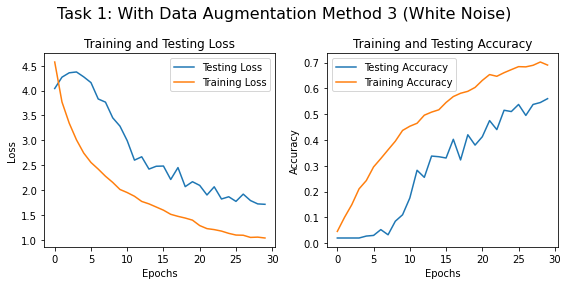

13/13 [==============================] - 1s 62ms/step


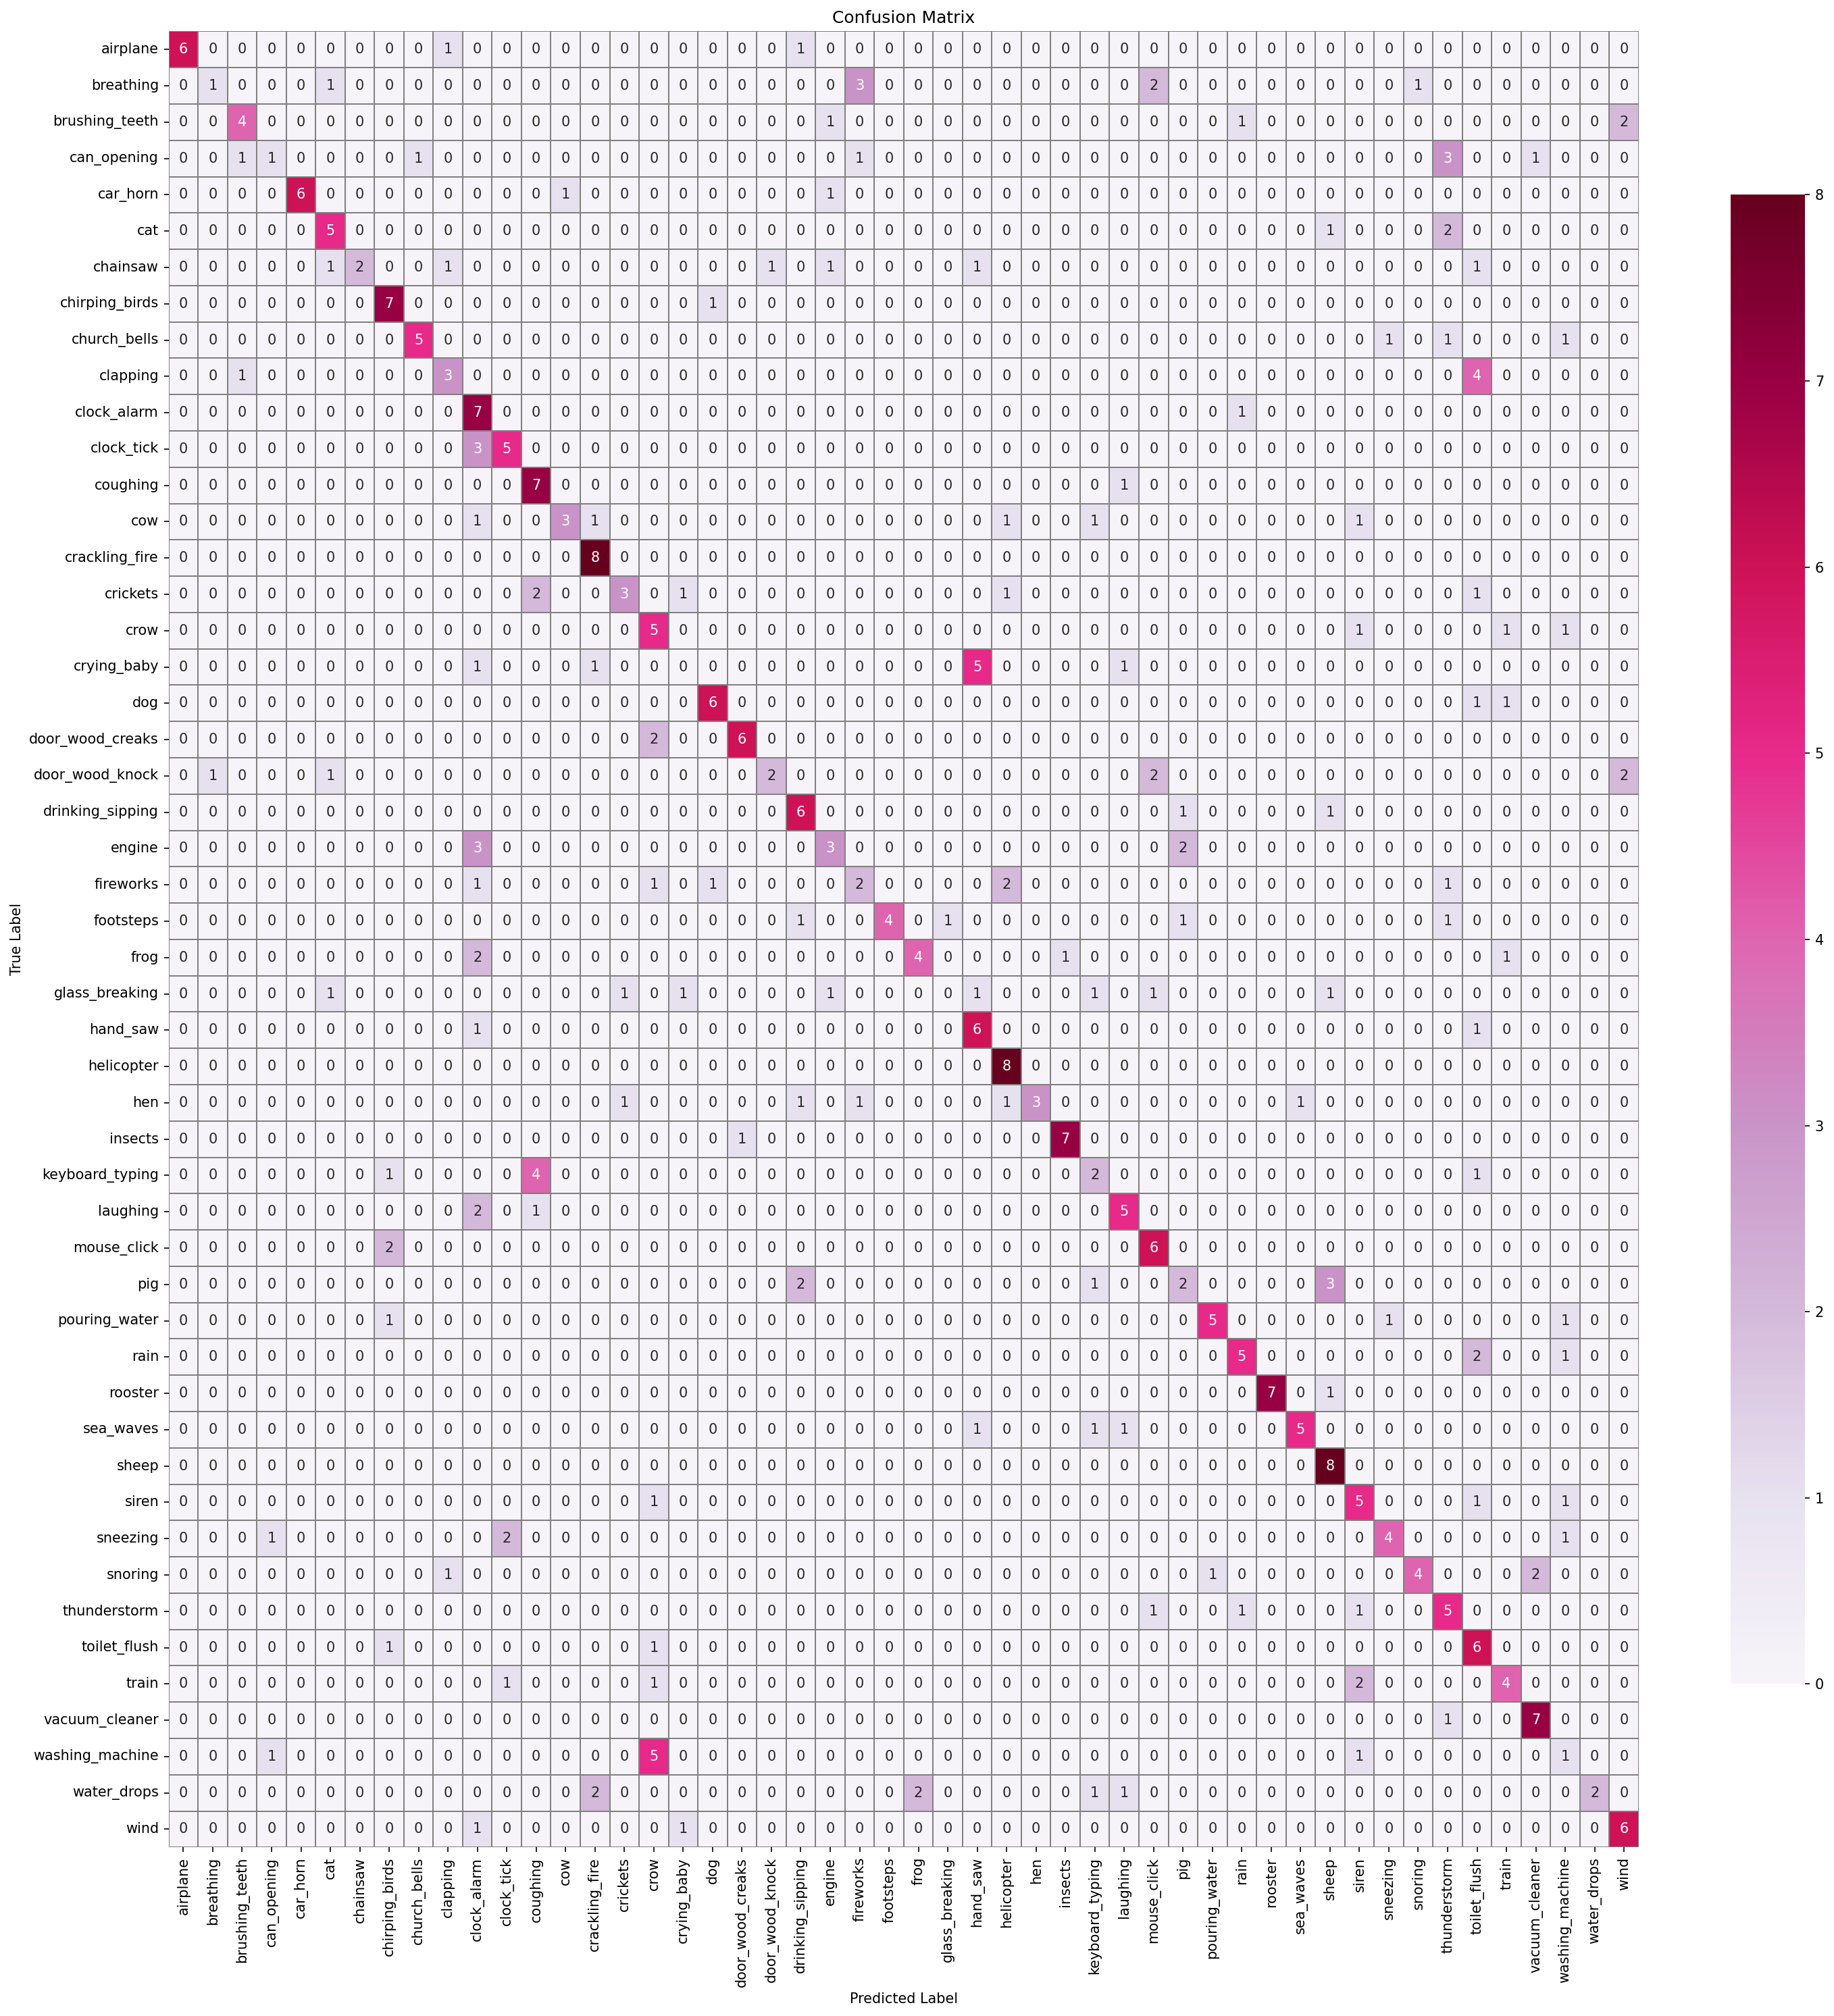

In [136]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(test_spectrograms, test_labels, verbose=0)
print(f"\n📊 Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}\n")

# Plot training & validation loss/accuracy curves
plot_loss_acc(history, 'Task 1: With Data Augmentation Method 3 (White Noise)')

# Predict class probabilities on the test set
predicted_probabilities = model.predict(test_spectrograms)

# Convert predicted probabilities to class indices
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Extract class names from metadata
class_names = np.unique(meta['category'])

# Plot confusion matrix
plot_confusion_matrix(test_labels, predicted_classes, class_names)

The model trained with white noise augmentation performs well, reaching a test accuracy of 56% and test loss of 1.72, suggesting that injecting controlled noise can effectively boost robustness. While pitch shift and time stretch achieved higher accuracies (61.8% and 61.5%, respectively) with the same CNN architecture, white noise remains a strong augmentation strategy. Its effectiveness lies in helping the model learn to focus on signal features while ignoring irrelevant background variation.

Let's try pink noise now!

## Method 4: Apply Pink Noise

In [211]:
def apply_pink_noise(signal, sr):
    """
    Add pink noise to the input signal.

    Parameters:
        signal (ndarray): The input signal to which pink noise will be added.
        snr (float): The desired Signal-to-Noise Ratio (SNR) in decibels.

    Returns:
        ndarray: The signal with pink noise added.
    """

    # Generate white noise as an array of size=signal
    white_noise = np.random.normal(0, 1, len(signal))

    # Transform white noise into fourier domain
    white_noise_fft = np.fft.fft(white_noise)

    # Create frequency bins
    freqs = np.fft.fftfreq(len(white_noise))

    # Adjust amplitude in frequency domain for pink noise
    white_noise_fft[freqs != 0] /= np.abs(freqs[freqs != 0])**0.5 # the ratio between larger freqs and their denominators is larger
    white_noise_fft[freqs == 0] = 0

    # Convert back to the time domain and taking the real components
    pink_noise = np.fft.ifft(white_noise_fft).real

    # Adjust amplitude in time domain for desired SNR
    pink_noise = adjust_SNR(signal, pink_noise)
    return signal + pink_noise

In [138]:
train_spectrograms, train_labels, test_spectrograms, test_labels = process_data(meta, audio_file_path, 
                                        augmentation_function=apply_pink_noise, spect_height=128, 
                                        spect_width=500, test_size=0.2, random_state=42)

Processing training data: original and with an augmentation...

✓ Train 596/1600: 2-173607-A-39.wav (original + augmented)
✓ Train 881/1600: 3-123086-A-28.wav (original + augmented)
✓ Train 1800/1600: 5-212181-A-38.wav (original + augmented)
✓ Train 699/1600: 2-70367-A-33.wav (original + augmented)
✓ Train 672/1600: 2-60794-A-26.wav (original + augmented)
✓ Train 1915/1600: 5-242932-B-26.wav (original + augmented)
✓ Train 81/1600: 1-18755-B-4.wav (original + augmented)
✓ Train 1808/1600: 5-213836-A-9.wav (original + augmented)
✓ Train 326/1600: 1-69165-A-34.wav (original + augmented)
✓ Train 1098/1600: 3-170015-A-0.wav (original + augmented)
✓ Train 1238/1600: 4-132383-B-2.wav (original + augmented)
✓ Train 514/1600: 2-120586-A-6.wav (original + augmented)
✓ Train 1496/1600: 4-195451-A-44.wav (original + augmented)
✓ Train 1876/1600: 5-233019-A-31.wav (original + augmented)
✓ Train 320/1600: 1-67152-A-17.wav (original + augmented)
✓ Train 659/1600: 2-54086-A-43.wav (original + augmente

In [139]:
# Train the further optimised CNN model
model, lr_scheduler = FurtherOptimisedCNN((128, 500, 1))

history = model.fit(train_spectrograms, train_labels, validation_data=(test_spectrograms, test_labels),
                    epochs=30, batch_size=64, callbacks=[lr_scheduler], verbose=1)

print("🎉 Model trained successfully!")

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_55 (Resizing)      (None, 64, 128, 1)        0         
                                                                 
 conv2d_186 (Conv2D)         (None, 62, 126, 32)       320       
                                                                 
 batch_normalization_136 (Ba  (None, 62, 126, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_102 (Activation)  (None, 62, 126, 32)      0         
                                                                 
 max_pooling2d_186 (MaxPooli  (None, 31, 63, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_187 (Conv2D)         (None, 29, 61, 64)      


📊 Test Loss: 1.7547
✅ Test Accuracy: 0.5250



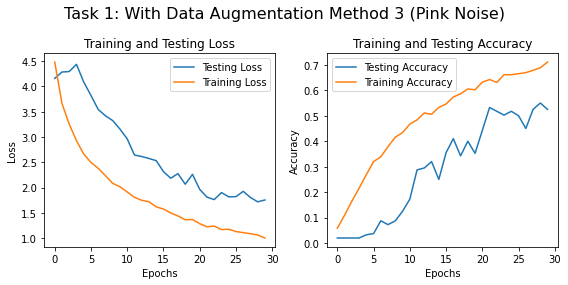

13/13 [==============================] - 1s 55ms/step


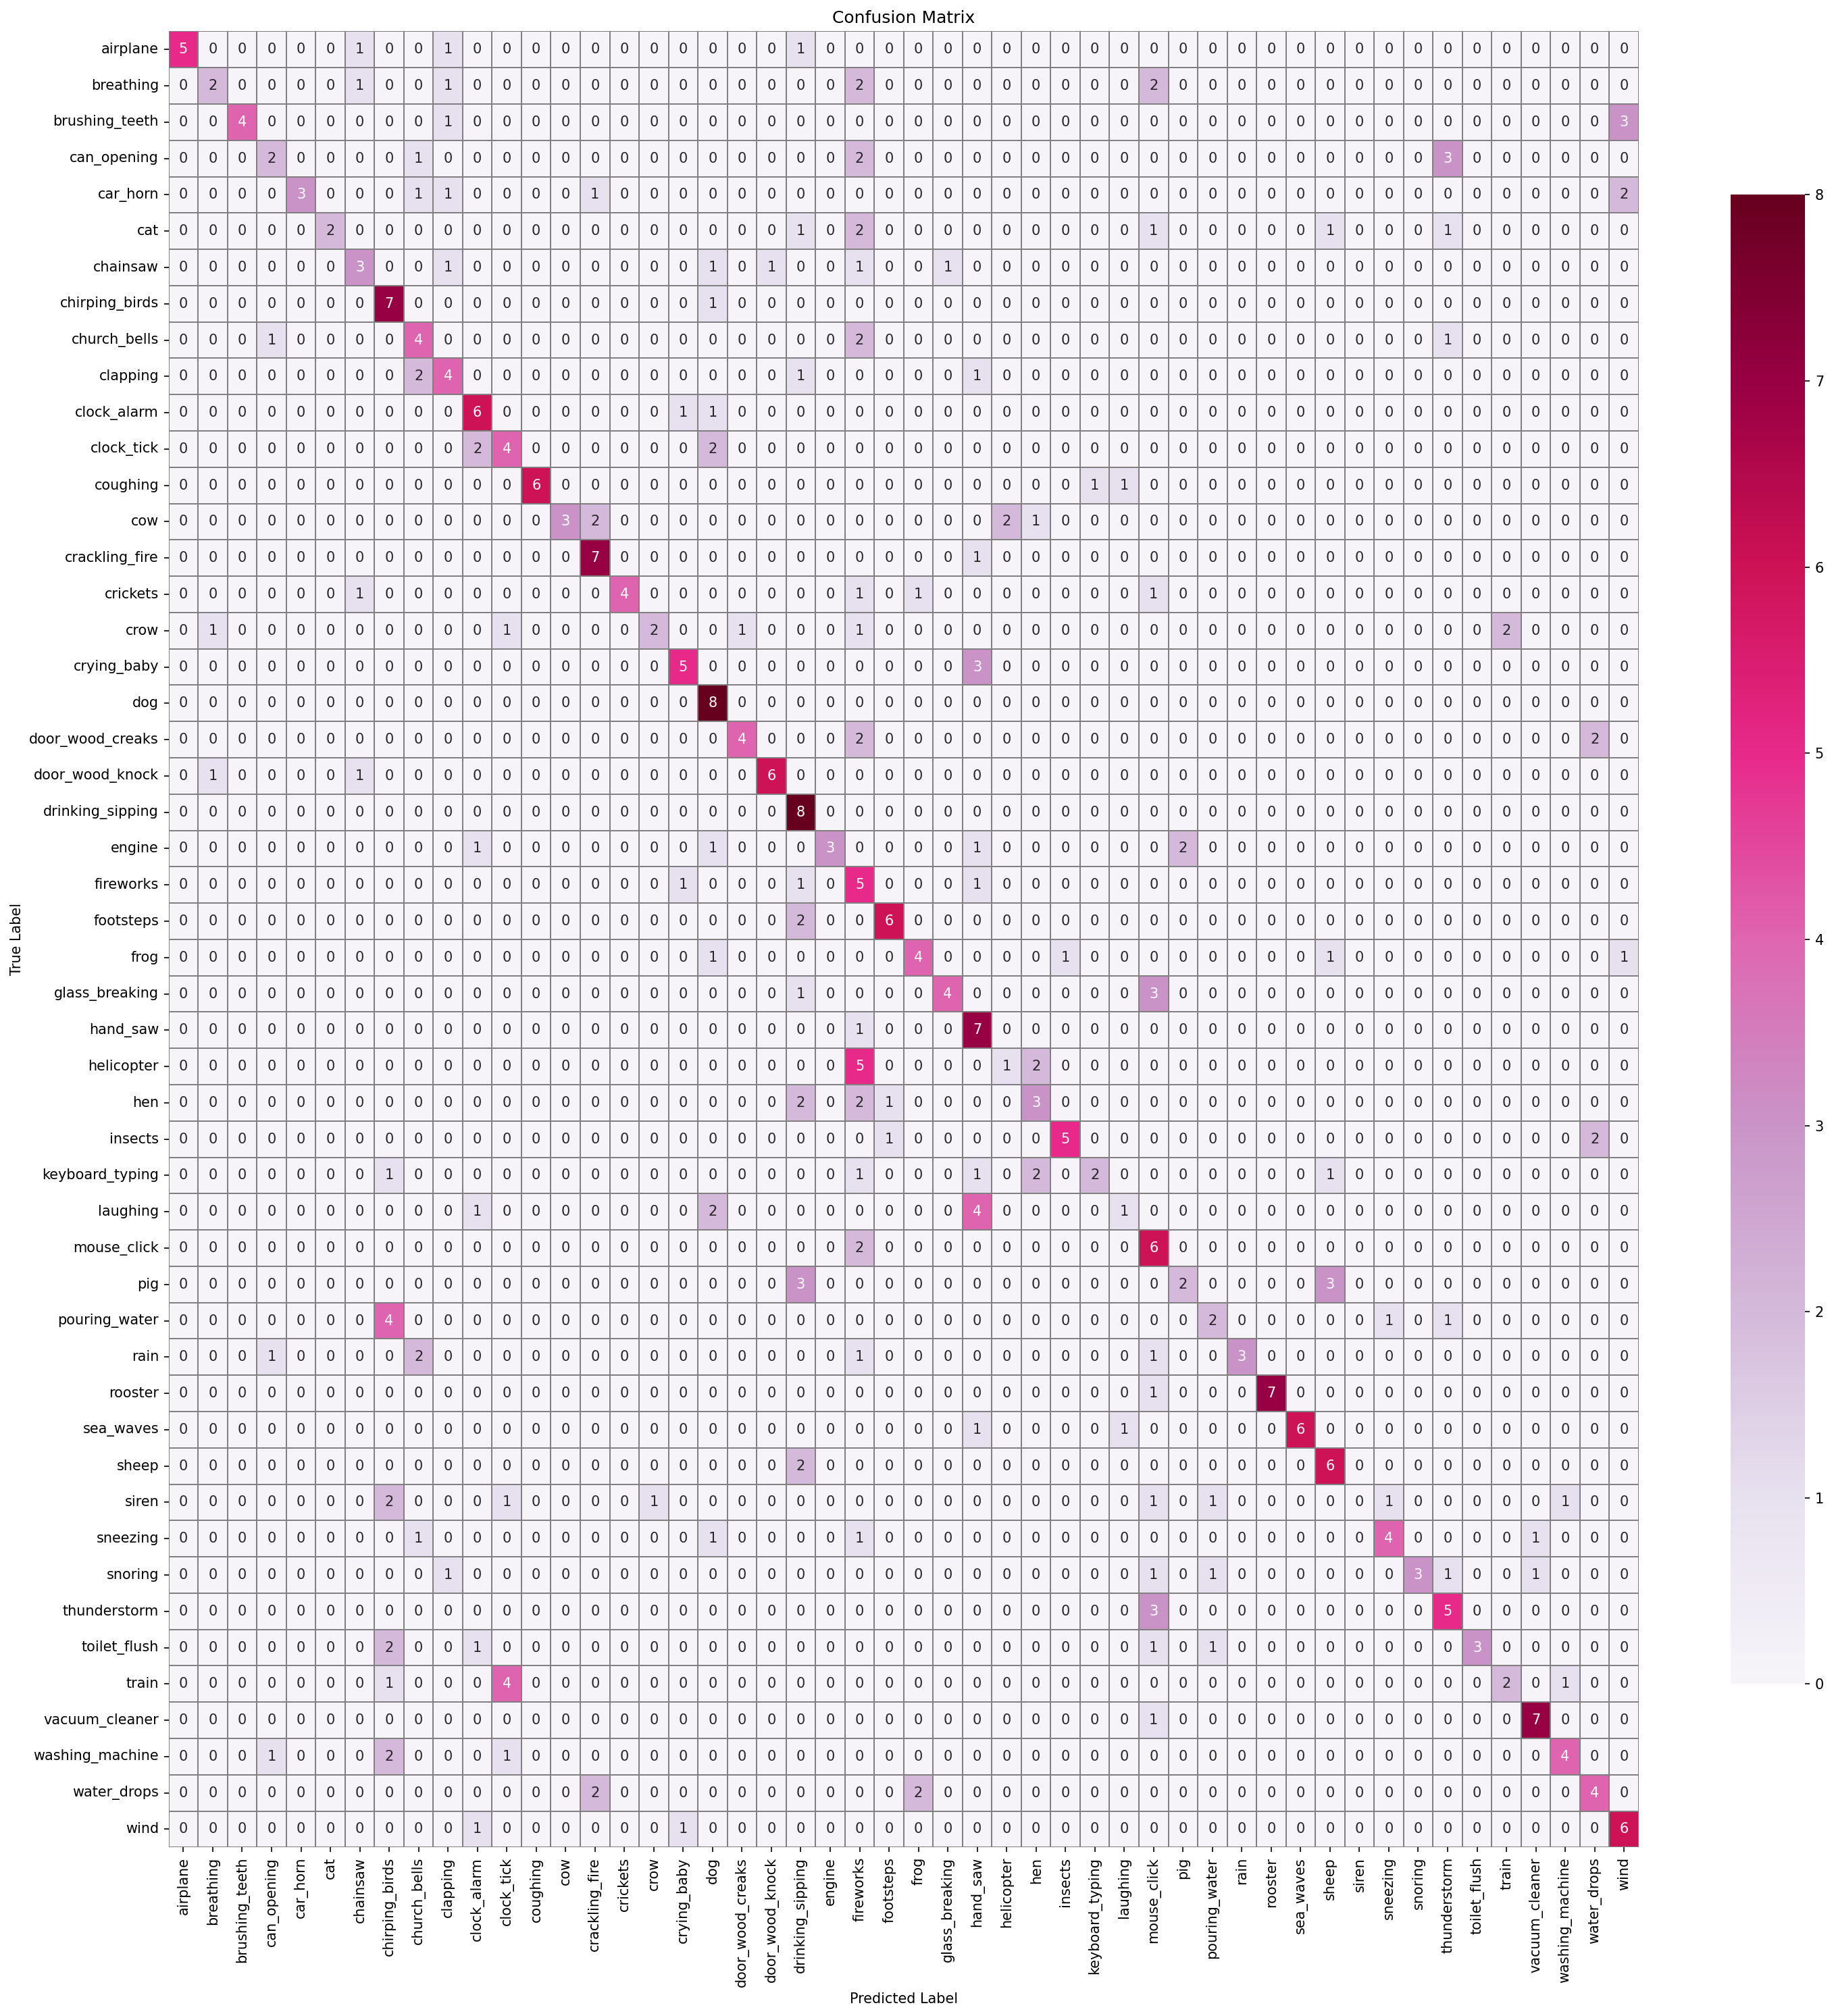

In [140]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(test_spectrograms, test_labels, verbose=0)
print(f"\n📊 Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}\n")

# Plot training & validation loss/accuracy curves
plot_loss_acc(history, 'Task 1: With Data Augmentation Method 3 (Pink Noise)')

# Predict class probabilities on the test set
predicted_probabilities = model.predict(test_spectrograms)

# Convert predicted probabilities to class indices
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Extract class names from metadata
class_names = np.unique(meta['category'])

# Plot confusion matrix
plot_confusion_matrix(test_labels, predicted_classes, class_names)

Training on pink noise–augmented data yields a test accuracy of 52.5%, which is slightly lower than white noise (56.0%) and notably below pitch shift (61.8%) and time stretch (61.5%). However, the model still demonstrates solid generalisation, with consistent improvements in accuracy and a stable test loss curve. 

While not the most effective individually, pink noise may present itself as a valuable augmentation strategy when used in combination with others - whihch we will test now.. Let's try combining all 4 augmentation strategies together to see if we can further enhance our model's performance!!!

## Method 5: Apply All 4 Augmentations

In [212]:
def super_process_data(meta, audio_file_path, augmentation_functions,
                 spect_height=128, spect_width=500, test_size=0.2, random_state=42):
    """
    Splits metadata, applies the given augmentation functions to training data only
    (each applied independently to the original), and converts all audio files into
    mel spectrograms of fixed size.

    Parameters:
        meta (DataFrame): Metadata with 'filename' and 'target' columns.
        audio_file_path (str): Path to the folder with original audio files.
        augmentation_functions (list): List of functions(y, sr) or functions(y) to augment audio.
        spect_height (int): Height of spectrogram (default 128).
        spect_width (int): Width of spectrogram (default 500).
        test_size (float): Proportion of test samples.
        random_state (int): Seed for reproducibility.

    Returns:
        train_spectrograms, train_labels, test_spectrograms, test_labels: Preprocessed datasets.
    """

    # Define the local path to the folder containing the original audio files
    audio_file_path = '/Users/xeniaodintsova/Desktop/ML_Project/audio'

    # Split metadata
    meta_train, meta_test = train_test_split(meta, test_size=test_size, random_state=random_state,
                                             stratify=meta['target'])
    
    
    # Process TRAINING DATA WITH ALL AUGMENTATIONS:
    train_spectrograms = []
    train_labels = []

    print("Processing training data: original and with multiple augmentations...\n")

    for index, row in meta_train[['filename', 'target']].iterrows():
        filename = row['filename']
        label = row['target']
        audio_path = os.path.join(audio_file_path, filename)
    
        try:
            y, sr = librosa.load(audio_path, sr=44100)
    
            # ORIGINAL VERSION OF THE DATA
            spect_orig = getSpect(y)
            if spect_orig.shape[1] < spect_width:
                pad = spect_width - spect_orig.shape[1]
                spect_orig = np.pad(spect_orig, ((0, 0), (0, pad)), mode='constant')
            else:
                spect_orig = spect_orig[:, :spect_width]

            train_spectrograms.append(spect_orig)
            train_labels.append(label)

            # AUGMENTED VERSIONS OF THE DATA
            for aug_func in augmentation_functions:
                try:
                    y_aug = aug_func(y, sr) if aug_func.__code__.co_argcount == 2 else aug_func(y)

                    spect_aug = getSpect(y_aug)
                    if spect_aug.shape[1] < spect_width:
                        pad = spect_width - spect_aug.shape[1]
                        spect_aug = np.pad(spect_aug, ((0, 0), (0, pad)), mode='constant')
                    else:
                        spect_aug = spect_aug[:, :spect_width]

                    train_spectrograms.append(spect_aug)
                    train_labels.append(label)
                except Exception as aug_error:
                    print(f"  → Augmentation error ({aug_func.__name__}) on file {filename}: {aug_error}")

            print(f"✓ Train {index + 1}/{len(meta_train)}: {filename} (original + {len(augmentation_functions)} augmentations)")

        except Exception as e:
            print(f"Error in train file {filename}: {e}")
    
    # TESTING DATA: ORIGINAL ONLY
    test_spectrograms = []
    test_labels = []

    print("\nProcessing testing data (original only)...\n")

    for index, row in meta_test[['filename', 'target']].iterrows():
        filename = row['filename']
        label = row['target']
        path = os.path.join(audio_file_path, filename)

        try:
            y, sr = librosa.load(path, sr=44100)

            spect = getSpect(y)
            if spect.shape[1] < spect_width:
                pad = spect_width - spect.shape[1]
                spect = np.pad(spect, ((0, 0), (0, pad)), mode='constant')
            else:
                spect = spect[:, :spect_width]

            test_spectrograms.append(spect)
            test_labels.append(label)

            print(f"✓ Test {index + 1}/{len(meta_test)}: {filename}")

        except Exception as e:
            print(f"Error in test file {filename}: {e}")

    # Convert to arrays and expand dimensions
    train_spectrograms = np.array(train_spectrograms, dtype=np.float32)[..., np.newaxis]
    train_labels = np.array(train_labels)

    test_spectrograms = np.array(test_spectrograms, dtype=np.float32)[..., np.newaxis]
    test_labels = np.array(test_labels)

    # Normalise the spectrograms
    train_spectrograms = train_spectrograms / np.max(np.abs(train_spectrograms), axis=(1,2,3), keepdims=True)
    test_spectrograms = test_spectrograms / np.max(np.abs(test_spectrograms), axis=(1,2,3), keepdims=True)

    print("\n✅ Data processing complete!")
    print(f"Train set shape: {train_spectrograms.shape} (should be 5x original train size)")
    print(f"Test set shape: {test_spectrograms.shape} (unchanged)")
    
    return train_spectrograms, train_labels, test_spectrograms, test_labels

In [213]:
train_spectrograms, train_labels, test_spectrograms, test_labels = super_process_data(meta, 
                                audio_file_path, augmentation_functions = [random_pitch_shift, 
                                            random_time_stretch, apply_white_noise, apply_pink_noise],
                                            spect_height=128, spect_width=500, test_size=0.2, random_state=42)

Processing training data: original and with multiple augmentations...

✓ Train 596/1600: 2-173607-A-39.wav (original + 4 augmentations)
✓ Train 881/1600: 3-123086-A-28.wav (original + 4 augmentations)
✓ Train 1800/1600: 5-212181-A-38.wav (original + 4 augmentations)
✓ Train 699/1600: 2-70367-A-33.wav (original + 4 augmentations)
✓ Train 672/1600: 2-60794-A-26.wav (original + 4 augmentations)
✓ Train 1915/1600: 5-242932-B-26.wav (original + 4 augmentations)
✓ Train 81/1600: 1-18755-B-4.wav (original + 4 augmentations)
✓ Train 1808/1600: 5-213836-A-9.wav (original + 4 augmentations)
✓ Train 326/1600: 1-69165-A-34.wav (original + 4 augmentations)
✓ Train 1098/1600: 3-170015-A-0.wav (original + 4 augmentations)
✓ Train 1238/1600: 4-132383-B-2.wav (original + 4 augmentations)
✓ Train 514/1600: 2-120586-A-6.wav (original + 4 augmentations)
✓ Train 1496/1600: 4-195451-A-44.wav (original + 4 augmentations)
✓ Train 1876/1600: 5-233019-A-31.wav (original + 4 augmentations)
✓ Train 320/1600: 1-67

In [230]:
# Train the further optimised CNN model
model, lr_scheduler = FurtherOptimisedCNN((128, 500, 1))

history = model.fit(train_spectrograms, train_labels, validation_data=(test_spectrograms, test_labels),
                    epochs=30, batch_size=64, callbacks=[lr_scheduler], verbose=1)

print("🎉 Model trained successfully!")

Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_70 (Resizing)      (None, 64, 128, 1)        0         
                                                                 
 conv2d_231 (Conv2D)         (None, 62, 126, 32)       320       
                                                                 
 batch_normalization_280 (Ba  (None, 62, 126, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_210 (Activation)  (None, 62, 126, 32)      0         
                                                                 
 max_pooling2d_231 (MaxPooli  (None, 31, 63, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_232 (Conv2D)         (None, 29, 61, 64)      


📊 Test Loss: 0.9271
✅ Test Accuracy: 0.7225



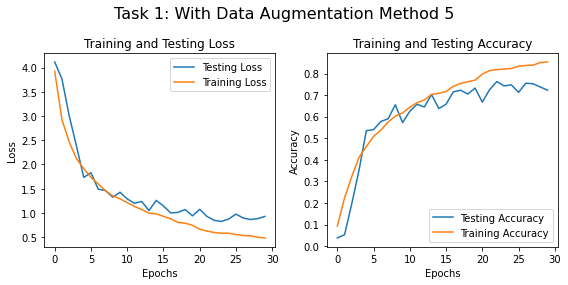

13/13 [==============================] - 1s 49ms/step


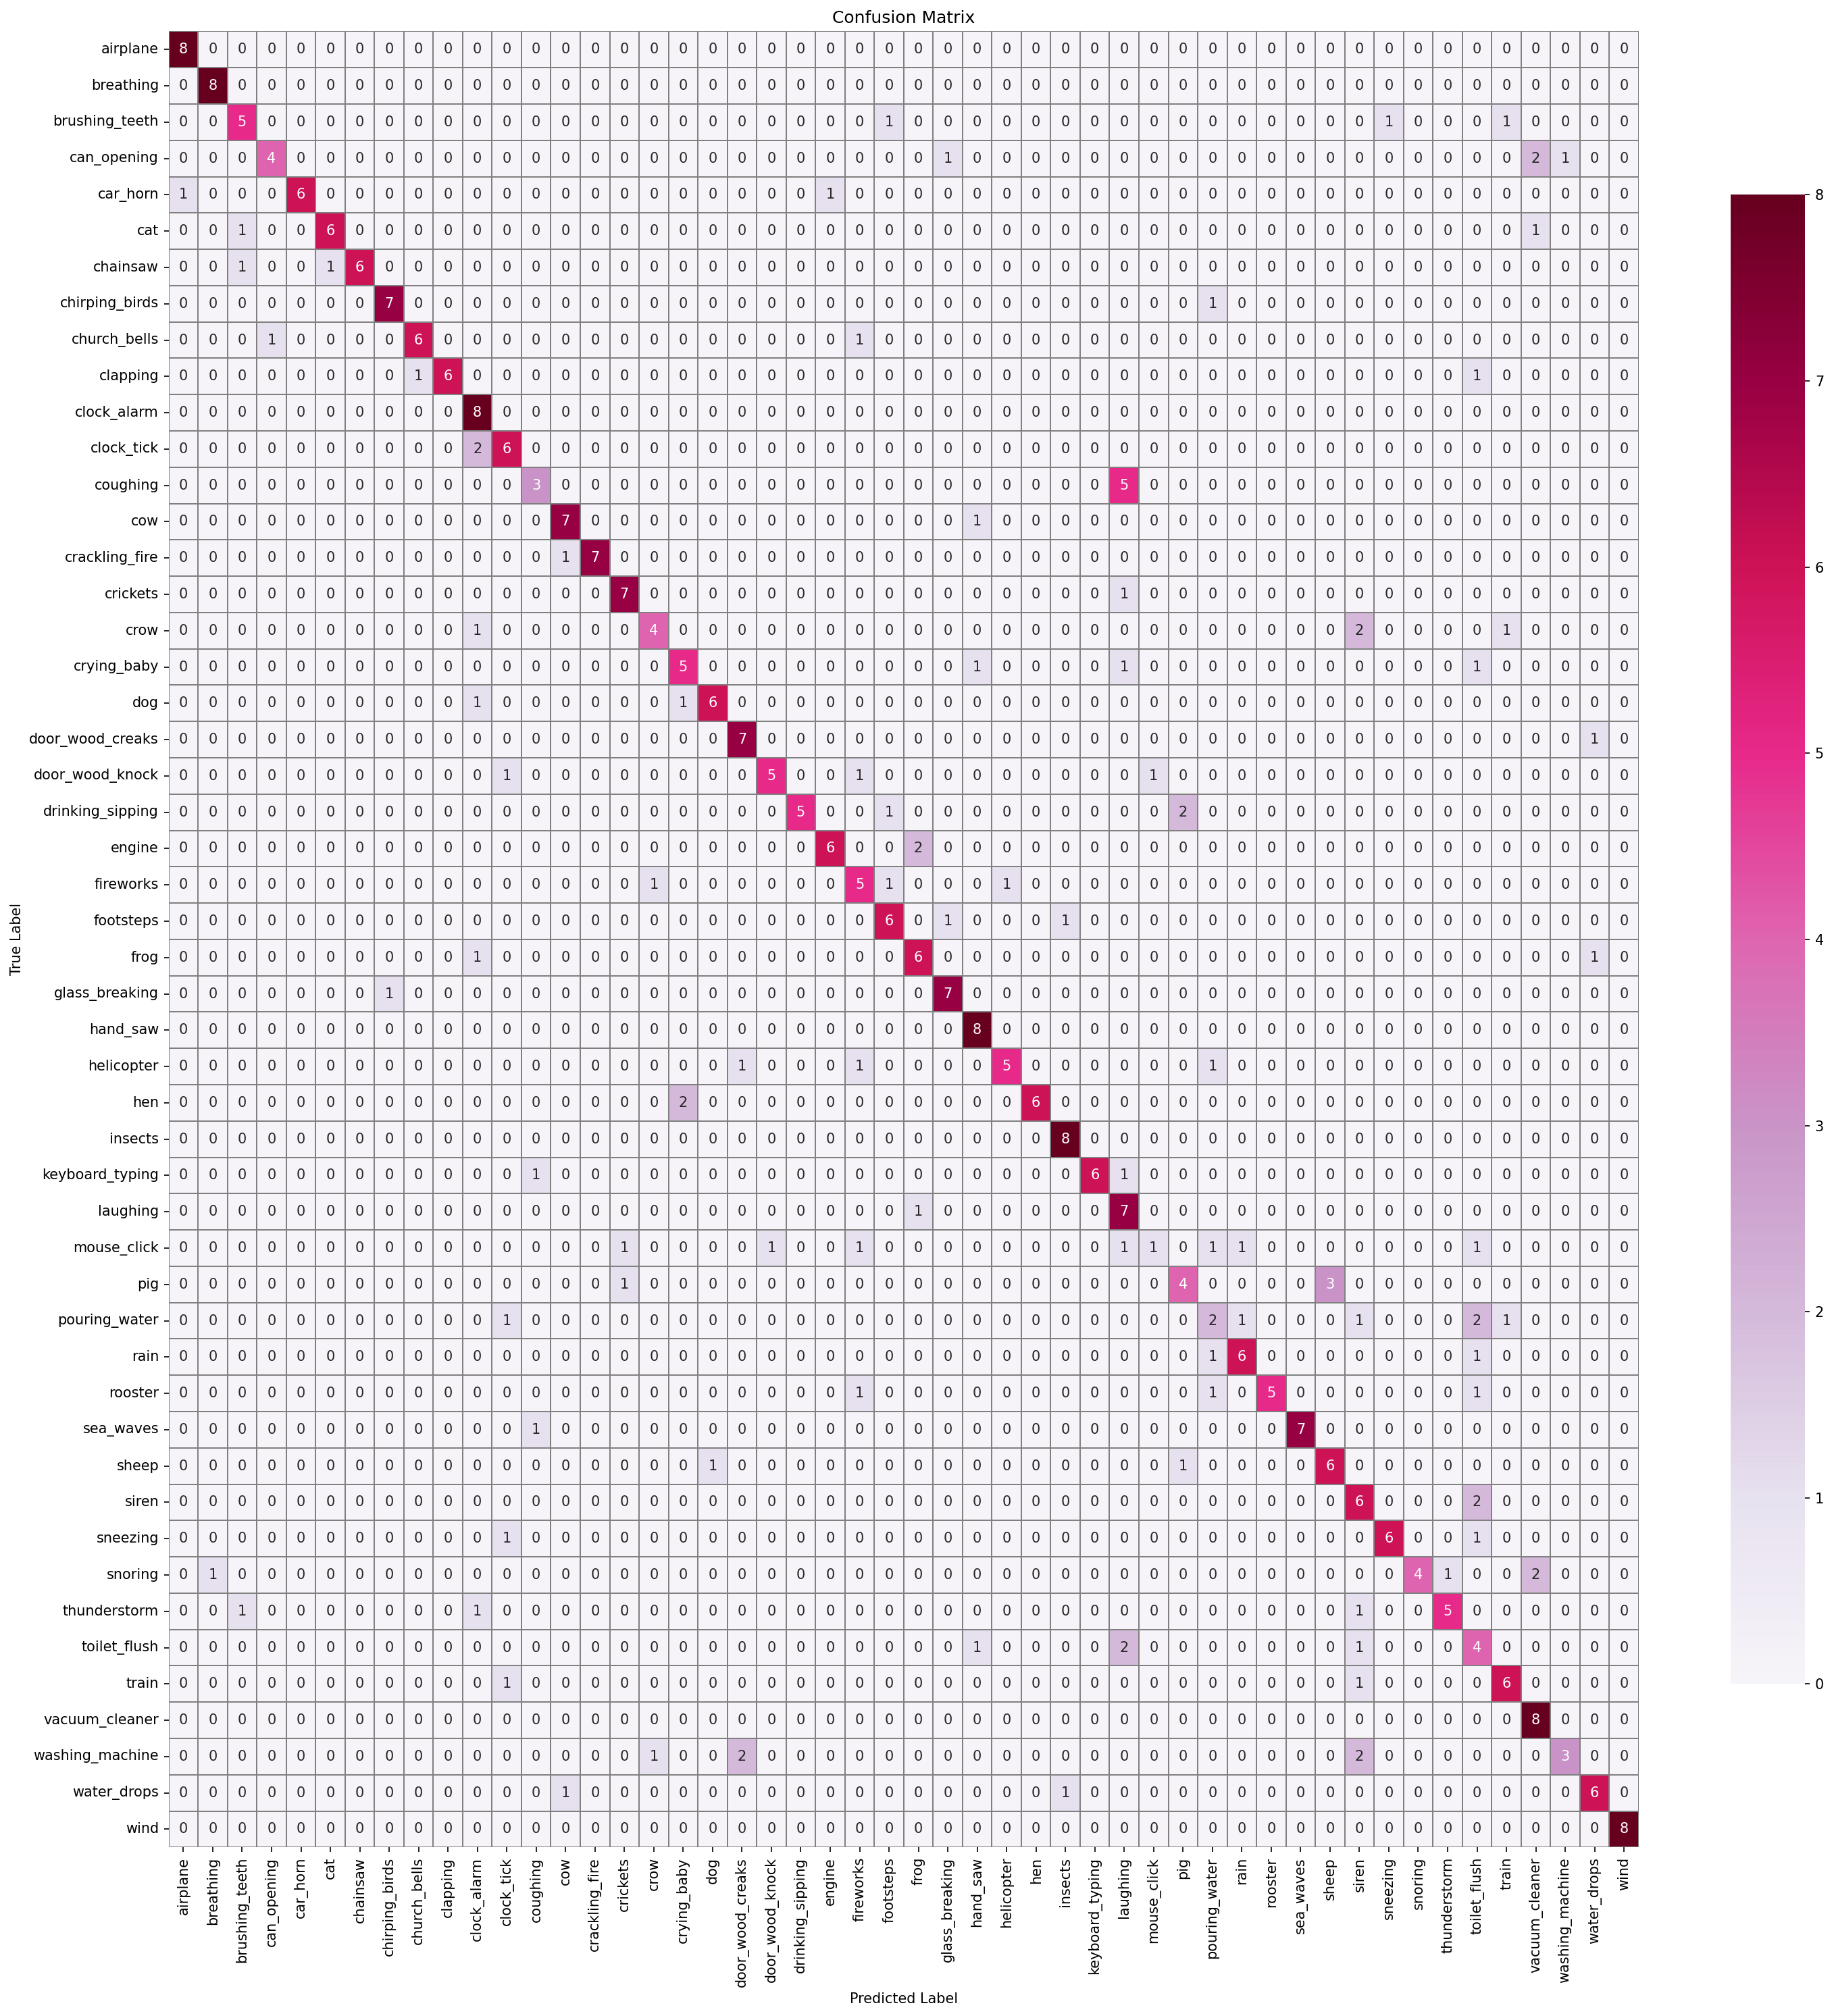

In [231]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(test_spectrograms, test_labels, verbose=0)
print(f"\n📊 Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}\n")

# Plot training & validation loss/accuracy curves
plot_loss_acc(history, 'Task 1: With Data Augmentation Method 5')

# Predict class probabilities on the test set
predicted_probabilities = model.predict(test_spectrograms)

# Convert predicted probabilities to class indices
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Extract class names from metadata
class_names = np.unique(meta['category'])

# Plot confusion matrix
plot_confusion_matrix(test_labels, predicted_classes, class_names)

The CNN trained using all four augmentation methods performed really well, reaching 72% test accuracy — its best so far in Task 1. The model clearly benefited from the extra variety in the training set, showing strong generalisation, minimal overfitting, and smooth learning curves throughout.

# Task 2: Develop a machine learning algorithm that can classify the sounds in terms of the 50 original categories using only the waveforms.

## This is quite similar to Task 1: we will mostly be repeating the process outlined above, but keeping the audio files as raw waveforms, without converting them into spectrograms

###  To reflect this, let's redefine the function that processes our data before we input it into the CNN

In [177]:
def process_data_waveform(meta, audio_file_path, augmentation_function,
                          sr=44100, test_size=0.2, random_state=42):
    """
    Splits metadata, applies the given augmentation function to training data only,
    and loads raw audio waveforms.

    Parameters:
        meta (DataFrame): Metadata with 'filename' and 'target' columns.
        audio_file_path (str): Path to the folder with original audio files.
        augmentation_function (function): Function(y, sr) → augmented y (applied to training data).
        sr (int): Sampling rate (default 44100).
        test_size (float): Proportion of test samples.
        random_state (int): Seed for reproducibility.

    Returns:
        train_waveforms, train_labels, test_waveforms, test_labels: Preprocessed datasets.
    """

    # Define the local path to the folder containing the original audio files
    audio_file_path = '/Users/xeniaodintsova/Desktop/ML_Project/audio'
    
    # FIRST split the metadata into training and testing sets!!!
    # We want to augment only the training data, then test our model on the original data!
    meta_train, meta_test = train_test_split(meta, test_size=test_size, random_state=random_state,
                                             stratify=meta['target'])

    # Process TRAINING DATA WITH AUGMENTATION:
    train_waveforms = []
    train_labels = []

    print("Processing training data: original and with an augmentation...\n")

    for index, row in meta_train[['filename', 'target']].iterrows():
        filename = row['filename']
        label = row['target']
        audio_path = os.path.join(audio_file_path, filename)

        try:
            y, _ = librosa.load(audio_path, sr=sr)

            # --- 1. ORIGINAL VERSION ---
            train_waveforms.append(y)
            train_labels.append(label)

            # --- 2. AUGMENTED VERSION ---
            y_aug = augmentation_function(y, sr)

            train_waveforms.append(y_aug)
            train_labels.append(label)

            print(f"✓ Train {index + 1}/{len(meta_train)}: {filename} (original + augmented)")

        except Exception as e:
            print(f"Error in train file {filename}: {e}")

    # TESTING DATA: ORIGINAL ONLY
    test_waveforms = []
    test_labels = []

    print("\nProcessing testing data (original only)...\n")

    for index, row in meta_test[['filename', 'target']].iterrows():
        filename = row['filename']
        label = row['target']
        path = os.path.join(audio_file_path, filename)

        try:
            y, _ = librosa.load(path, sr=sr)

            test_waveforms.append(y)
            test_labels.append(label)

            print(f"✓ Test {index + 1}/{len(meta_test)}: {filename}")

        except Exception as e:
            print(f"Error in test file {filename}: {e}")

    # Fix waveform length (e.g. 2.5 seconds = 110250 samples)
    fixed_length = 110250
    
    # Pad or trim waveforms to fixed length
    train_waveforms = np.array([
        np.pad(w, (0, fixed_length - len(w)), mode='constant') if len(w) < fixed_length else w[:fixed_length]
        for w in train_waveforms], dtype=np.float32)

    test_waveforms = np.array([
        np.pad(w, (0, fixed_length - len(w)), mode='constant') if len(w) < fixed_length else w[:fixed_length]
        for w in test_waveforms], dtype=np.float32)

    # Safe normalisation to avoid NaNs in CNN training
    train_waveforms = np.array([
        w / np.max(np.abs(w)) if np.max(np.abs(w)) > 0 else w
        for w in train_waveforms
    ], dtype=np.float32)

    test_waveforms = np.array([
        w / np.max(np.abs(w)) if np.max(np.abs(w)) > 0 else w
        for w in test_waveforms
    ], dtype=np.float32)

    # Add channel dimension for Conv1D
    train_waveforms = train_waveforms[..., np.newaxis]
    test_waveforms = test_waveforms[..., np.newaxis]

    print("\n✅ Data processing complete!")
    print(f"Train set shape: {train_waveforms.shape} (should be 2x original train size)")
    print(f"Test set shape: {test_waveforms.shape} (unchanged)")

    return train_waveforms, train_labels, test_waveforms, test_labels

### We also need to redefine our FurtherOptimised CNN to accept raw waveforms as input

In [178]:
def RawAudio_FurtherOptimisedCNN(input_shape):
    model = keras.Sequential()

    model.add(Input(shape=input_shape))

    # Block 1
    model.add(Conv1D(16, kernel_size=9))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=4))

    # Block 2
    model.add(Conv1D(32, kernel_size=9))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Dropout(0.3))

    # Block 3
    model.add(Conv1D(64, kernel_size=9))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=4))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dropout(0.6))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.7))
    model.add(Dense(50, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model

## So... Task 2 Method 1 (Pitch Stretching)

In [179]:
train_waveforms, train_labels, test_waveforms, test_labels = process_data_waveform(meta, audio_file_path, 
                                        augmentation_function=random_pitch_shift, test_size=0.2, random_state=42)

Processing training data: original and with an augmentation...

✓ Train 596/1600: 2-173607-A-39.wav (original + augmented)
✓ Train 881/1600: 3-123086-A-28.wav (original + augmented)
✓ Train 1800/1600: 5-212181-A-38.wav (original + augmented)
✓ Train 699/1600: 2-70367-A-33.wav (original + augmented)
✓ Train 672/1600: 2-60794-A-26.wav (original + augmented)
✓ Train 1915/1600: 5-242932-B-26.wav (original + augmented)
✓ Train 81/1600: 1-18755-B-4.wav (original + augmented)
✓ Train 1808/1600: 5-213836-A-9.wav (original + augmented)
✓ Train 326/1600: 1-69165-A-34.wav (original + augmented)
✓ Train 1098/1600: 3-170015-A-0.wav (original + augmented)
✓ Train 1238/1600: 4-132383-B-2.wav (original + augmented)
✓ Train 514/1600: 2-120586-A-6.wav (original + augmented)
✓ Train 1496/1600: 4-195451-A-44.wav (original + augmented)
✓ Train 1876/1600: 5-233019-A-31.wav (original + augmented)
✓ Train 320/1600: 1-67152-A-17.wav (original + augmented)
✓ Train 659/1600: 2-54086-A-43.wav (original + augmente

In [180]:
# Train the further optimised CNN model
model = RawAudio_FurtherOptimisedCNN((110250, 1))

history = model.fit(train_waveforms, train_labels, validation_data=(test_waveforms, test_labels),
                    epochs=30, batch_size=64, callbacks=[lr_scheduler], verbose=1)

print("🎉 Model trained successfully!") # it actually wasn't... 6 minutes per training epoch is
                                        # very unnecessary for this task

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_46 (Conv1D)          (None, 110242, 16)        160       
                                                                 
 batch_normalization_196 (Ba  (None, 110242, 16)       64        
 tchNormalization)                                               
                                                                 
 activation_147 (Activation)  (None, 110242, 16)       0         
                                                                 
 max_pooling1d_46 (MaxPoolin  (None, 27560, 16)        0         
 g1D)                                                            
                                                                 
 conv1d_47 (Conv1D)          (None, 27552, 32)         4640      
                                                                 
 batch_normalization_197 (Ba  (None, 27552, 32)      

KeyboardInterrupt: 

### We ran into a problem: RawAudio_FurtherOptimisedCNN has an excessive 6-minute training time per epoch.

### Several optimisations were made to address this issue: shortening the input length from 110,250 to 44,100 samples, lowering the batch size from 64 to 32, reducing the number of convolutional filters, and casting inputs to float16 precision.

### These changes in the CNN architecture and in the data processing function are reflected in the two code cells below. Together, they brought training time down to under 1 minute per epoch without a major drop in performance.

In [185]:
def RawAudio_VeryFurtherOptimisedCNN(input_shape):
    model = keras.Sequential()

    model.add(Input(shape=input_shape))

    # Block 1
    model.add(Conv1D(8, kernel_size=9))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=4))

    # Block 2
    model.add(Conv1D(16, kernel_size=9))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Dropout(0.3))

    # Block 3
    model.add(Conv1D(32, kernel_size=9))
    model.add(BatchN#ormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=4))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dropout(0.6))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.7))
    model.add(Dense(50, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model

In [186]:
def process_data_waveform(meta, audio_file_path, augmentation_function,
                          sr=44100, test_size=0.2, random_state=42):
    """
    Splits metadata, applies the given augmentation function to training data only,
    and loads raw audio waveforms. Same function as before, but with several optimisations that
    help reduce CNN training time without significantly compromising performance.

    Parameters:
        meta (DataFrame): Metadata with 'filename' and 'target' columns.
        audio_file_path (str): Path to the folder with original audio files.
        augmentation_function (function): Function(y, sr) → augmented y (applied to training data).
        sr (int): Sampling rate (default 44100).
        test_size (float): Proportion of test samples.
        random_state (int): Seed for reproducibility.

    Returns:
        train_waveforms, train_labels, test_waveforms, test_labels: Preprocessed datasets.
    """

    # Define the local path to the folder containing the original audio files
    audio_file_path = '/Users/xeniaodintsova/Desktop/ML_Project/audio'
    
    # FIRST split the metadata into training and testing sets!!!
    # We want to augment only the training data, then test our model on the original data!
    meta_train, meta_test = train_test_split(meta, test_size=test_size, random_state=random_state,
                                             stratify=meta['target'])

    # Process TRAINING DATA WITH AUGMENTATION:
    train_waveforms = []
    train_labels = []

    print("Processing training data: original and with an augmentation...\n")

    for index, row in meta_train[['filename', 'target']].iterrows():
        filename = row['filename']
        label = row['target']
        audio_path = os.path.join(audio_file_path, filename)

        try:
            y, _ = librosa.load(audio_path, sr=sr)

            # --- 1. ORIGINAL VERSION ---
            train_waveforms.append(y)
            train_labels.append(label)

            # --- 2. AUGMENTED VERSION ---
            y_aug = augmentation_function(y, sr)

            train_waveforms.append(y_aug)
            train_labels.append(label)

            print(f"✓ Train {index + 1}/{len(meta_train)}: {filename} (original + augmented)")

        except Exception as e:
            print(f"Error in train file {filename}: {e}")

    # TESTING DATA: ORIGINAL ONLY
    test_waveforms = []
    test_labels = []

    print("\nProcessing testing data (original only)...\n")

    for index, row in meta_test[['filename', 'target']].iterrows():
        filename = row['filename']
        label = row['target']
        path = os.path.join(audio_file_path, filename)

        try:
            y, _ = librosa.load(path, sr=sr)

            test_waveforms.append(y)
            test_labels.append(label)

            print(f"✓ Test {index + 1}/{len(meta_test)}: {filename}")

        except Exception as e:
            print(f"Error in test file {filename}: {e}")

    # Fix waveform length (e.g. 2.5 seconds = 110250 samples)
    fixed_length = 44100 # 1 second instead
    
    # Pad or trim waveforms to fixed length
    train_waveforms = np.array([
        np.pad(w, (0, fixed_length - len(w)), mode='constant') if len(w) < fixed_length else w[:fixed_length]
        for w in train_waveforms], dtype=np.float16)

    test_waveforms = np.array([
        np.pad(w, (0, fixed_length - len(w)), mode='constant') if len(w) < fixed_length else w[:fixed_length]
        for w in test_waveforms], dtype=np.float16)

    # Safe normalisation to avoid NaNs in CNN training
    train_waveforms = np.array([
        w / np.max(np.abs(w)) if np.max(np.abs(w)) > 0 else w
        for w in train_waveforms
    ], dtype=np.float16)

    test_waveforms = np.array([
        w / np.max(np.abs(w)) if np.max(np.abs(w)) > 0 else w
        for w in test_waveforms
    ], dtype=np.float16)

    # Add channel dimension for Conv1D
    train_waveforms = train_waveforms[..., np.newaxis]
    test_waveforms = test_waveforms[..., np.newaxis]

    print("\n✅ Data processing complete!")
    print(f"Train set shape: {train_waveforms.shape} (should be 2x original train size)")
    print(f"Test set shape: {test_waveforms.shape} (unchanged)")

    return train_waveforms, train_labels, test_waveforms, test_labels

## Reattempting Task 2 Method 1 (Pitch Stretching) now

In [187]:
train_waveforms, train_labels, test_waveforms, test_labels = process_data_waveform(meta, audio_file_path, 
                                        augmentation_function=random_pitch_shift, test_size=0.2, random_state=42)

Processing training data: original and with an augmentation...

✓ Train 596/1600: 2-173607-A-39.wav (original + augmented)
✓ Train 881/1600: 3-123086-A-28.wav (original + augmented)
✓ Train 1800/1600: 5-212181-A-38.wav (original + augmented)
✓ Train 699/1600: 2-70367-A-33.wav (original + augmented)
✓ Train 672/1600: 2-60794-A-26.wav (original + augmented)
✓ Train 1915/1600: 5-242932-B-26.wav (original + augmented)
✓ Train 81/1600: 1-18755-B-4.wav (original + augmented)
✓ Train 1808/1600: 5-213836-A-9.wav (original + augmented)
✓ Train 326/1600: 1-69165-A-34.wav (original + augmented)
✓ Train 1098/1600: 3-170015-A-0.wav (original + augmented)
✓ Train 1238/1600: 4-132383-B-2.wav (original + augmented)
✓ Train 514/1600: 2-120586-A-6.wav (original + augmented)
✓ Train 1496/1600: 4-195451-A-44.wav (original + augmented)
✓ Train 1876/1600: 5-233019-A-31.wav (original + augmented)
✓ Train 320/1600: 1-67152-A-17.wav (original + augmented)
✓ Train 659/1600: 2-54086-A-43.wav (original + augmente

In [188]:
# Train the further optimised CNN model
model = RawAudio_VeryFurtherOptimisedCNN((44100, 1))

history = model.fit(train_waveforms, train_labels, validation_data=(test_waveforms, test_labels),
                    epochs=30, batch_size=32, callbacks=[lr_scheduler], verbose=1)

print("🎉 Model trained successfully!")

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_52 (Conv1D)          (None, 44092, 8)          80        
                                                                 
 batch_normalization_204 (Ba  (None, 44092, 8)         32        
 tchNormalization)                                               
                                                                 
 activation_153 (Activation)  (None, 44092, 8)         0         
                                                                 
 max_pooling1d_52 (MaxPoolin  (None, 11023, 8)         0         
 g1D)                                                            
                                                                 
 conv1d_53 (Conv1D)          (None, 11015, 16)         1168      
                                                                 
 batch_normalization_205 (Ba  (None, 11015, 16)      


📊 Test Loss: 1.7098
✅ Test Accuracy: 0.5850



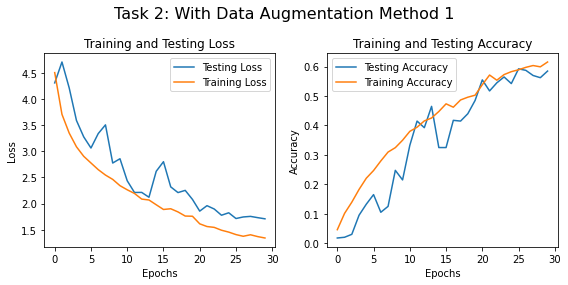

13/13 [==============================] - 1s 51ms/step


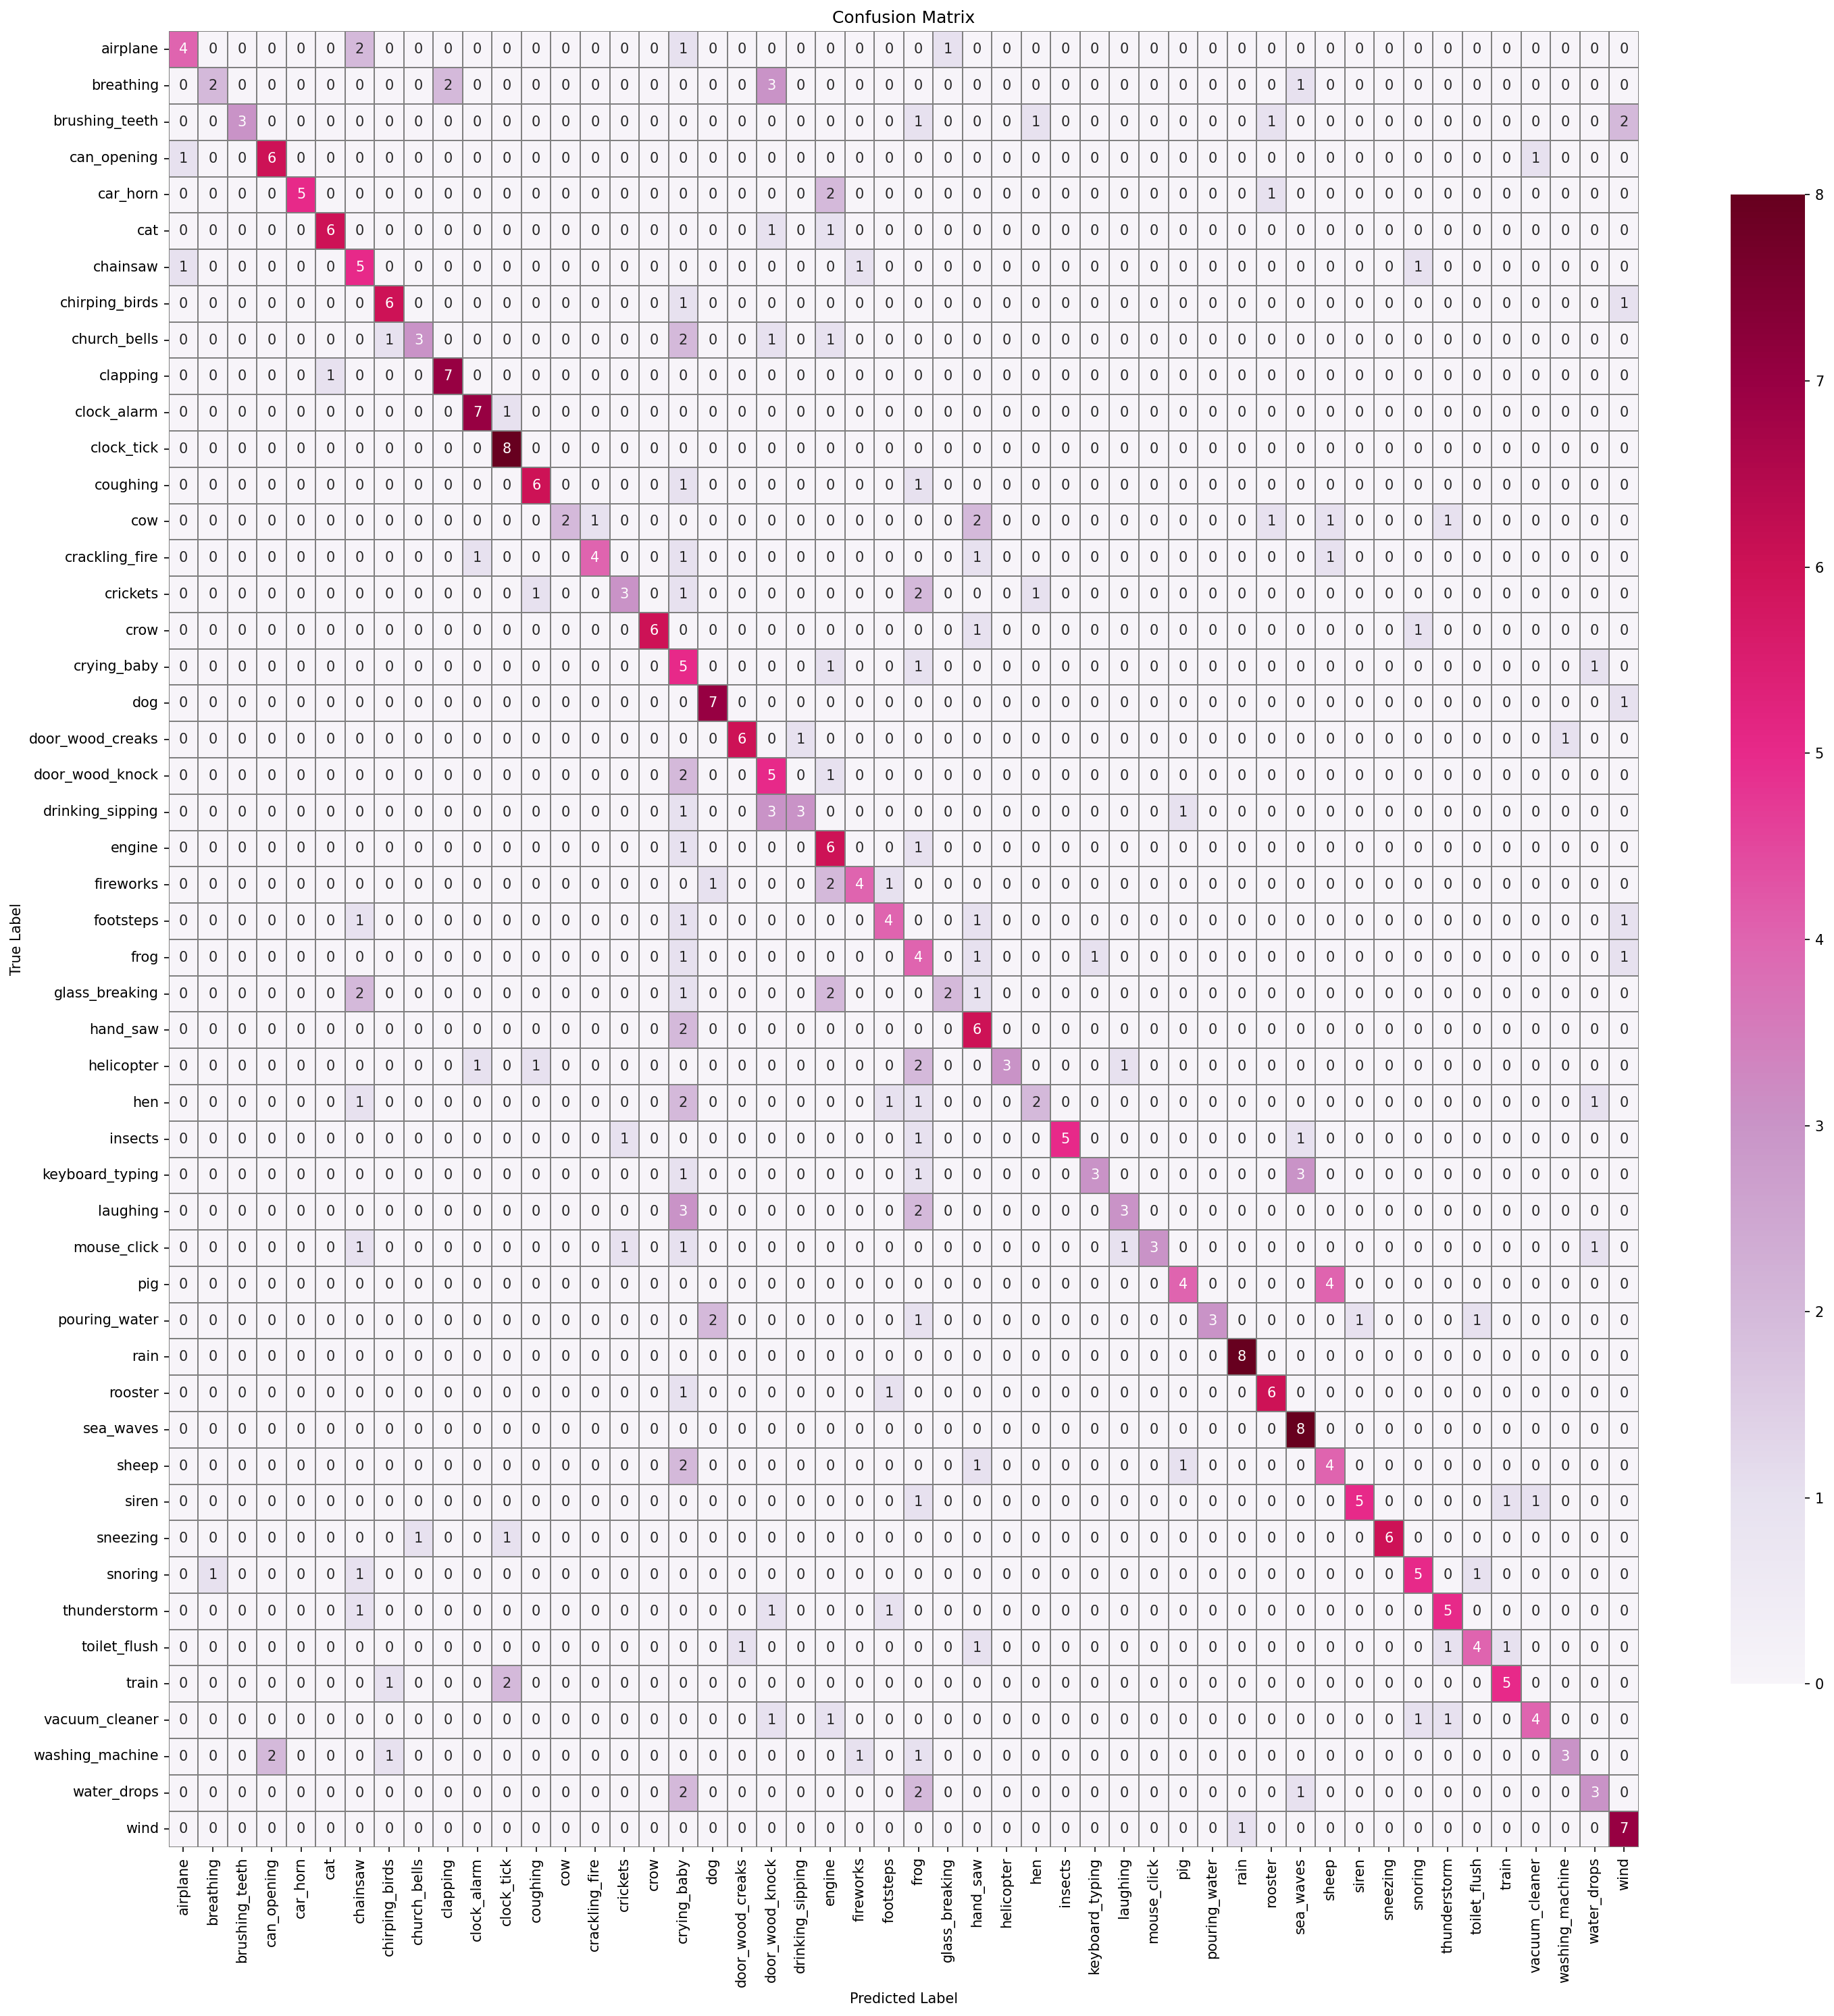

In [189]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(test_waveforms, test_labels, verbose=0)
print(f"\n📊 Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}\n")

# Plot training & validation loss/accuracy curves
plot_loss_acc(history, 'Task 2: With Data Augmentation Method 1')

# Predict class probabilities on the test set
predicted_probabilities = model.predict(test_waveforms)

# Convert predicted probabilities to class indices
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Extract class names from metadata
class_names = np.unique(meta['category'])

# Plot confusion matrix
plot_confusion_matrix(test_labels, predicted_classes, class_names)

The raw-audio CNN trained on pitch-shifted data in Task 2 achieves a solid test accuracy of 58.5%, indicating good overall generalisation. The training and testing curves indicate stable learning in general, though some small fluctuations in validation accuracy suggest mild sensitivity to the pitch-shifted inputs. Despite not outperforming spectrogram-based models, this result shows that a 1D CNN can still extract meaningful features from raw waveforms when combined with effective augmentation. However, further improvements, such as additional data augmentation, may be necessary to improve generalisation.

## Task 2 Method 2 (Time Stretching)

In [200]:
train_waveforms, train_labels, test_waveforms, test_labels = process_data_waveform(meta, audio_file_path, 
                                        augmentation_function=random_time_stretch, test_size=0.2, random_state=42)

Processing training data: original and with an augmentation...

✓ Train 596/1600: 2-173607-A-39.wav (original + augmented)
✓ Train 881/1600: 3-123086-A-28.wav (original + augmented)
✓ Train 1800/1600: 5-212181-A-38.wav (original + augmented)
✓ Train 699/1600: 2-70367-A-33.wav (original + augmented)
✓ Train 672/1600: 2-60794-A-26.wav (original + augmented)
✓ Train 1915/1600: 5-242932-B-26.wav (original + augmented)
✓ Train 81/1600: 1-18755-B-4.wav (original + augmented)
✓ Train 1808/1600: 5-213836-A-9.wav (original + augmented)
✓ Train 326/1600: 1-69165-A-34.wav (original + augmented)
✓ Train 1098/1600: 3-170015-A-0.wav (original + augmented)
✓ Train 1238/1600: 4-132383-B-2.wav (original + augmented)
✓ Train 514/1600: 2-120586-A-6.wav (original + augmented)
✓ Train 1496/1600: 4-195451-A-44.wav (original + augmented)
✓ Train 1876/1600: 5-233019-A-31.wav (original + augmented)
✓ Train 320/1600: 1-67152-A-17.wav (original + augmented)
✓ Train 659/1600: 2-54086-A-43.wav (original + augmente

In [201]:
# Train the further optimised CNN model
model = RawAudio_VeryFurtherOptimisedCNN((44100, 1))

history = model.fit(train_waveforms, train_labels, validation_data=(test_waveforms, test_labels),
                    epochs=30, batch_size=32, callbacks=[lr_scheduler], verbose=1)

print("🎉 Model trained successfully!")

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_67 (Conv1D)          (None, 44092, 8)          80        
                                                                 
 batch_normalization_224 (Ba  (None, 44092, 8)         32        
 tchNormalization)                                               
                                                                 
 activation_168 (Activation)  (None, 44092, 8)         0         
                                                                 
 max_pooling1d_67 (MaxPoolin  (None, 11023, 8)         0         
 g1D)                                                            
                                                                 
 conv1d_68 (Conv1D)          (None, 11015, 16)         1168      
                                                                 
 batch_normalization_225 (Ba  (None, 11015, 16)      


📊 Test Loss: 1.8371
✅ Test Accuracy: 0.5500



13/13 [==============================] - 1s 52ms/step


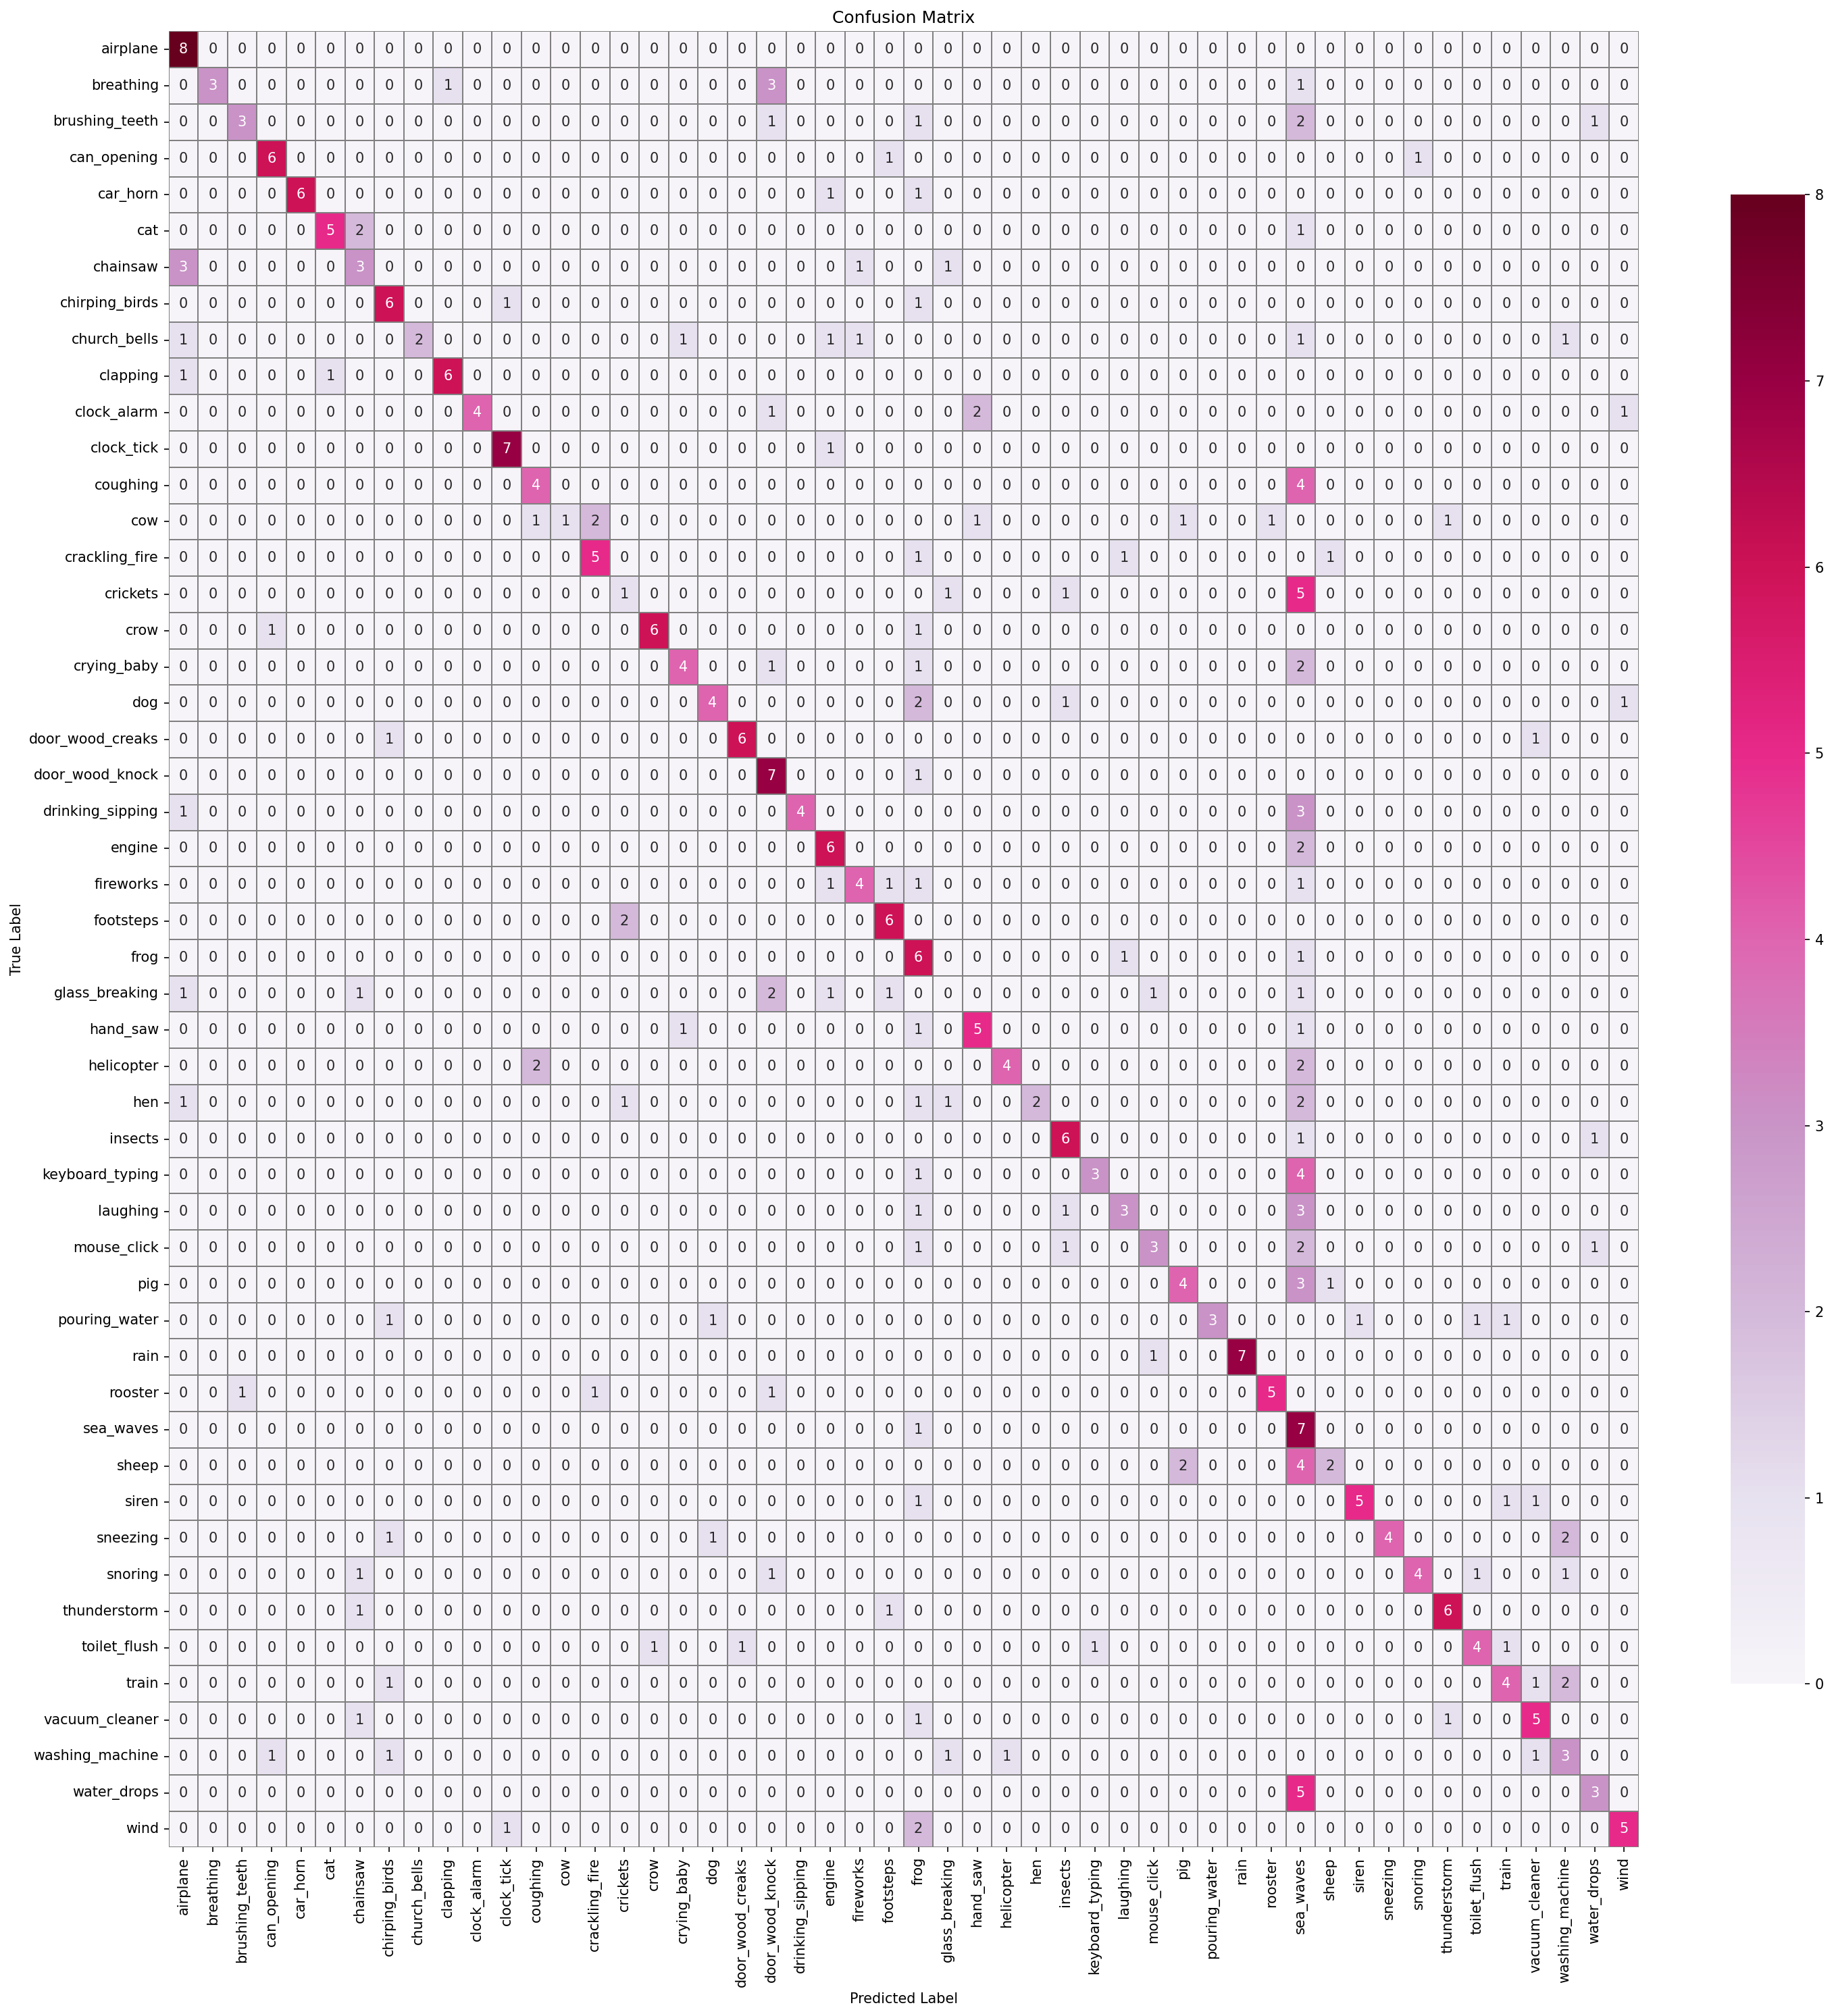

In [202]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(test_waveforms, test_labels, verbose=0)
print(f"\n📊 Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}\n")

# Plot training & validation loss/accuracy curves
plot_loss_acc(history, 'Task 2: With Data Augmentation Method 2')

# Predict class probabilities on the test set
predicted_probabilities = model.predict(test_waveforms)

# Convert predicted probabilities to class indices
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Extract class names from metadata
class_names = np.unique(meta['category'])

# Plot confusion matrix
plot_confusion_matrix(test_labels, predicted_classes, class_names)

Training the CNN on time-stretched raw audio data results in a test accuracy of 55.0%, indicating that this augmentation technique effectively helps the model generalise better. While slightly lower than the 58.5% achieved with pitch shifting, the results still highlight time stretching as a valuable method for enhancing classification performance on raw waveforms.

## Task 2 Method 3 (White Noise Addition)

In [193]:
train_waveforms, train_labels, test_waveforms, test_labels = process_data_waveform(meta, audio_file_path, 
                                        augmentation_function=apply_white_noise, test_size=0.2, random_state=42)

Processing training data: original and with an augmentation...

✓ Train 596/1600: 2-173607-A-39.wav (original + augmented)
✓ Train 881/1600: 3-123086-A-28.wav (original + augmented)
✓ Train 1800/1600: 5-212181-A-38.wav (original + augmented)
✓ Train 699/1600: 2-70367-A-33.wav (original + augmented)
✓ Train 672/1600: 2-60794-A-26.wav (original + augmented)
✓ Train 1915/1600: 5-242932-B-26.wav (original + augmented)
✓ Train 81/1600: 1-18755-B-4.wav (original + augmented)
✓ Train 1808/1600: 5-213836-A-9.wav (original + augmented)
✓ Train 326/1600: 1-69165-A-34.wav (original + augmented)
✓ Train 1098/1600: 3-170015-A-0.wav (original + augmented)
✓ Train 1238/1600: 4-132383-B-2.wav (original + augmented)
✓ Train 514/1600: 2-120586-A-6.wav (original + augmented)
✓ Train 1496/1600: 4-195451-A-44.wav (original + augmented)
✓ Train 1876/1600: 5-233019-A-31.wav (original + augmented)
✓ Train 320/1600: 1-67152-A-17.wav (original + augmented)
✓ Train 659/1600: 2-54086-A-43.wav (original + augmente

In [195]:
# Train the further optimised CNN model
model = RawAudio_VeryFurtherOptimisedCNN((44100, 1))

history = model.fit(train_waveforms, train_labels, validation_data=(test_waveforms, test_labels),
                    epochs=30, batch_size=32, callbacks=[lr_scheduler], verbose=1)

print("🎉 Model trained successfully!")

Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_61 (Conv1D)          (None, 44092, 8)          80        
                                                                 
 batch_normalization_216 (Ba  (None, 44092, 8)         32        
 tchNormalization)                                               
                                                                 
 activation_162 (Activation)  (None, 44092, 8)         0         
                                                                 
 max_pooling1d_61 (MaxPoolin  (None, 11023, 8)         0         
 g1D)                                                            
                                                                 
 conv1d_62 (Conv1D)          (None, 11015, 16)         1168      
                                                                 
 batch_normalization_217 (Ba  (None, 11015, 16)      


📊 Test Loss: 1.7747
✅ Test Accuracy: 0.5975



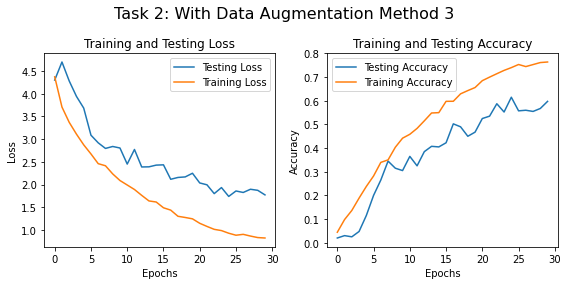

13/13 [==============================] - 1s 53ms/step


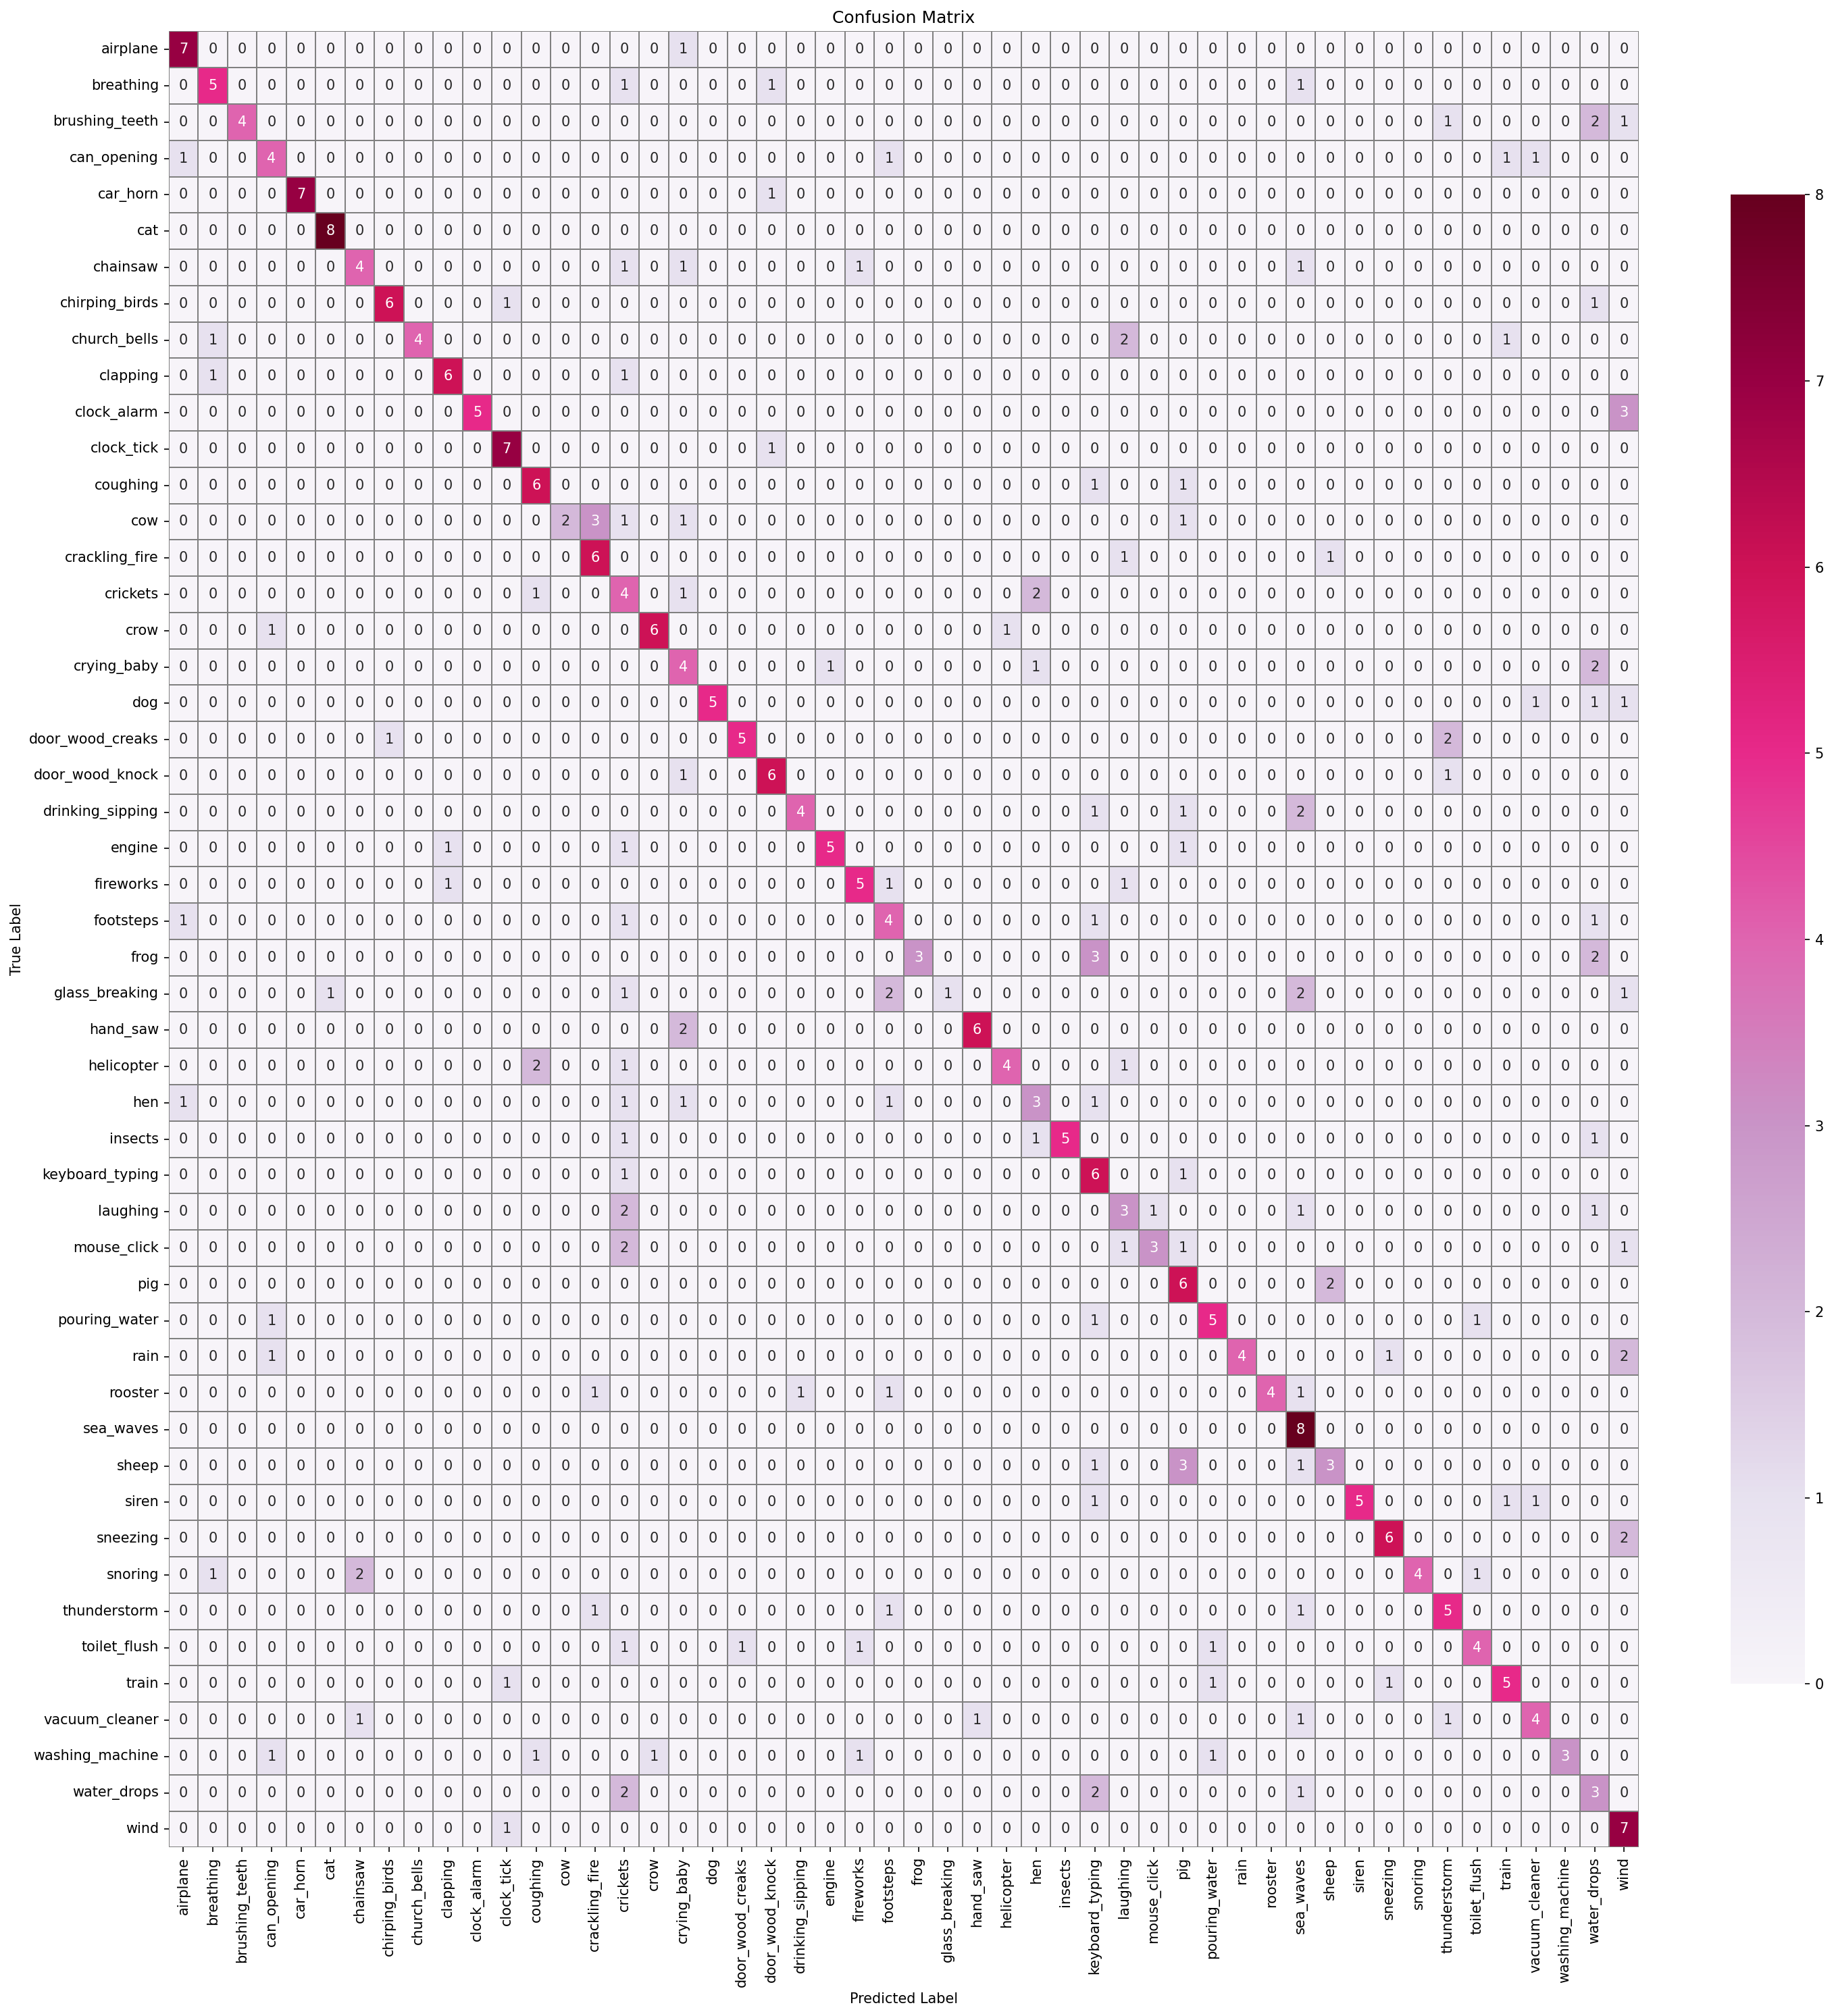

In [196]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(test_waveforms, test_labels, verbose=0)
print(f"\n📊 Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}\n")

# Plot training & validation loss/accuracy curves
plot_loss_acc(history, 'Task 2: With Data Augmentation Method 3')

# Predict class probabilities on the test set
predicted_probabilities = model.predict(test_waveforms)

# Convert predicted probabilities to class indices
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Extract class names from metadata
class_names = np.unique(meta['category'])

# Plot confusion matrix
plot_confusion_matrix(test_labels, predicted_classes, class_names)

The model trained on white noise–augmented raw audio achieves a test accuracy of 59.75%, outperforming both the time stretch-augmented data (55%) and the pitch shift-augmneted data (58.5%). Both loss and accuracy curves are quite smooth and stable, indicating consistent training without major instability. Overall, white noise proves to be an effective augmentation method that improves generalisation while maintaining reliable model behaviour.

## Task 2 Method 4 (Pink Noise Addition)

In [197]:
train_waveforms, train_labels, test_waveforms, test_labels = process_data_waveform(meta, audio_file_path, 
                                        augmentation_function=apply_pink_noise, test_size=0.2, random_state=42)

Processing training data: original and with an augmentation...

✓ Train 596/1600: 2-173607-A-39.wav (original + augmented)
✓ Train 881/1600: 3-123086-A-28.wav (original + augmented)
✓ Train 1800/1600: 5-212181-A-38.wav (original + augmented)
✓ Train 699/1600: 2-70367-A-33.wav (original + augmented)
✓ Train 672/1600: 2-60794-A-26.wav (original + augmented)
✓ Train 1915/1600: 5-242932-B-26.wav (original + augmented)
✓ Train 81/1600: 1-18755-B-4.wav (original + augmented)
✓ Train 1808/1600: 5-213836-A-9.wav (original + augmented)
✓ Train 326/1600: 1-69165-A-34.wav (original + augmented)
✓ Train 1098/1600: 3-170015-A-0.wav (original + augmented)
✓ Train 1238/1600: 4-132383-B-2.wav (original + augmented)
✓ Train 514/1600: 2-120586-A-6.wav (original + augmented)
✓ Train 1496/1600: 4-195451-A-44.wav (original + augmented)
✓ Train 1876/1600: 5-233019-A-31.wav (original + augmented)
✓ Train 320/1600: 1-67152-A-17.wav (original + augmented)
✓ Train 659/1600: 2-54086-A-43.wav (original + augmente

In [198]:
# Train the further optimised CNN model
model = RawAudio_VeryFurtherOptimisedCNN((44100, 1))

history = model.fit(train_waveforms, train_labels, validation_data=(test_waveforms, test_labels),
                    epochs=30, batch_size=32, callbacks=[lr_scheduler], verbose=1)

print("🎉 Model trained successfully!")

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_64 (Conv1D)          (None, 44092, 8)          80        
                                                                 
 batch_normalization_220 (Ba  (None, 44092, 8)         32        
 tchNormalization)                                               
                                                                 
 activation_165 (Activation)  (None, 44092, 8)         0         
                                                                 
 max_pooling1d_64 (MaxPoolin  (None, 11023, 8)         0         
 g1D)                                                            
                                                                 
 conv1d_65 (Conv1D)          (None, 11015, 16)         1168      
                                                                 
 batch_normalization_221 (Ba  (None, 11015, 16)      


📊 Test Loss: 1.6848
✅ Test Accuracy: 0.6025



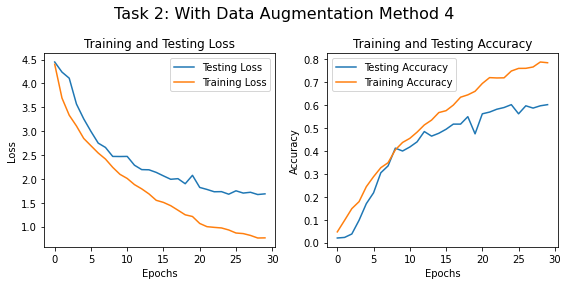

13/13 [==============================] - 1s 54ms/step


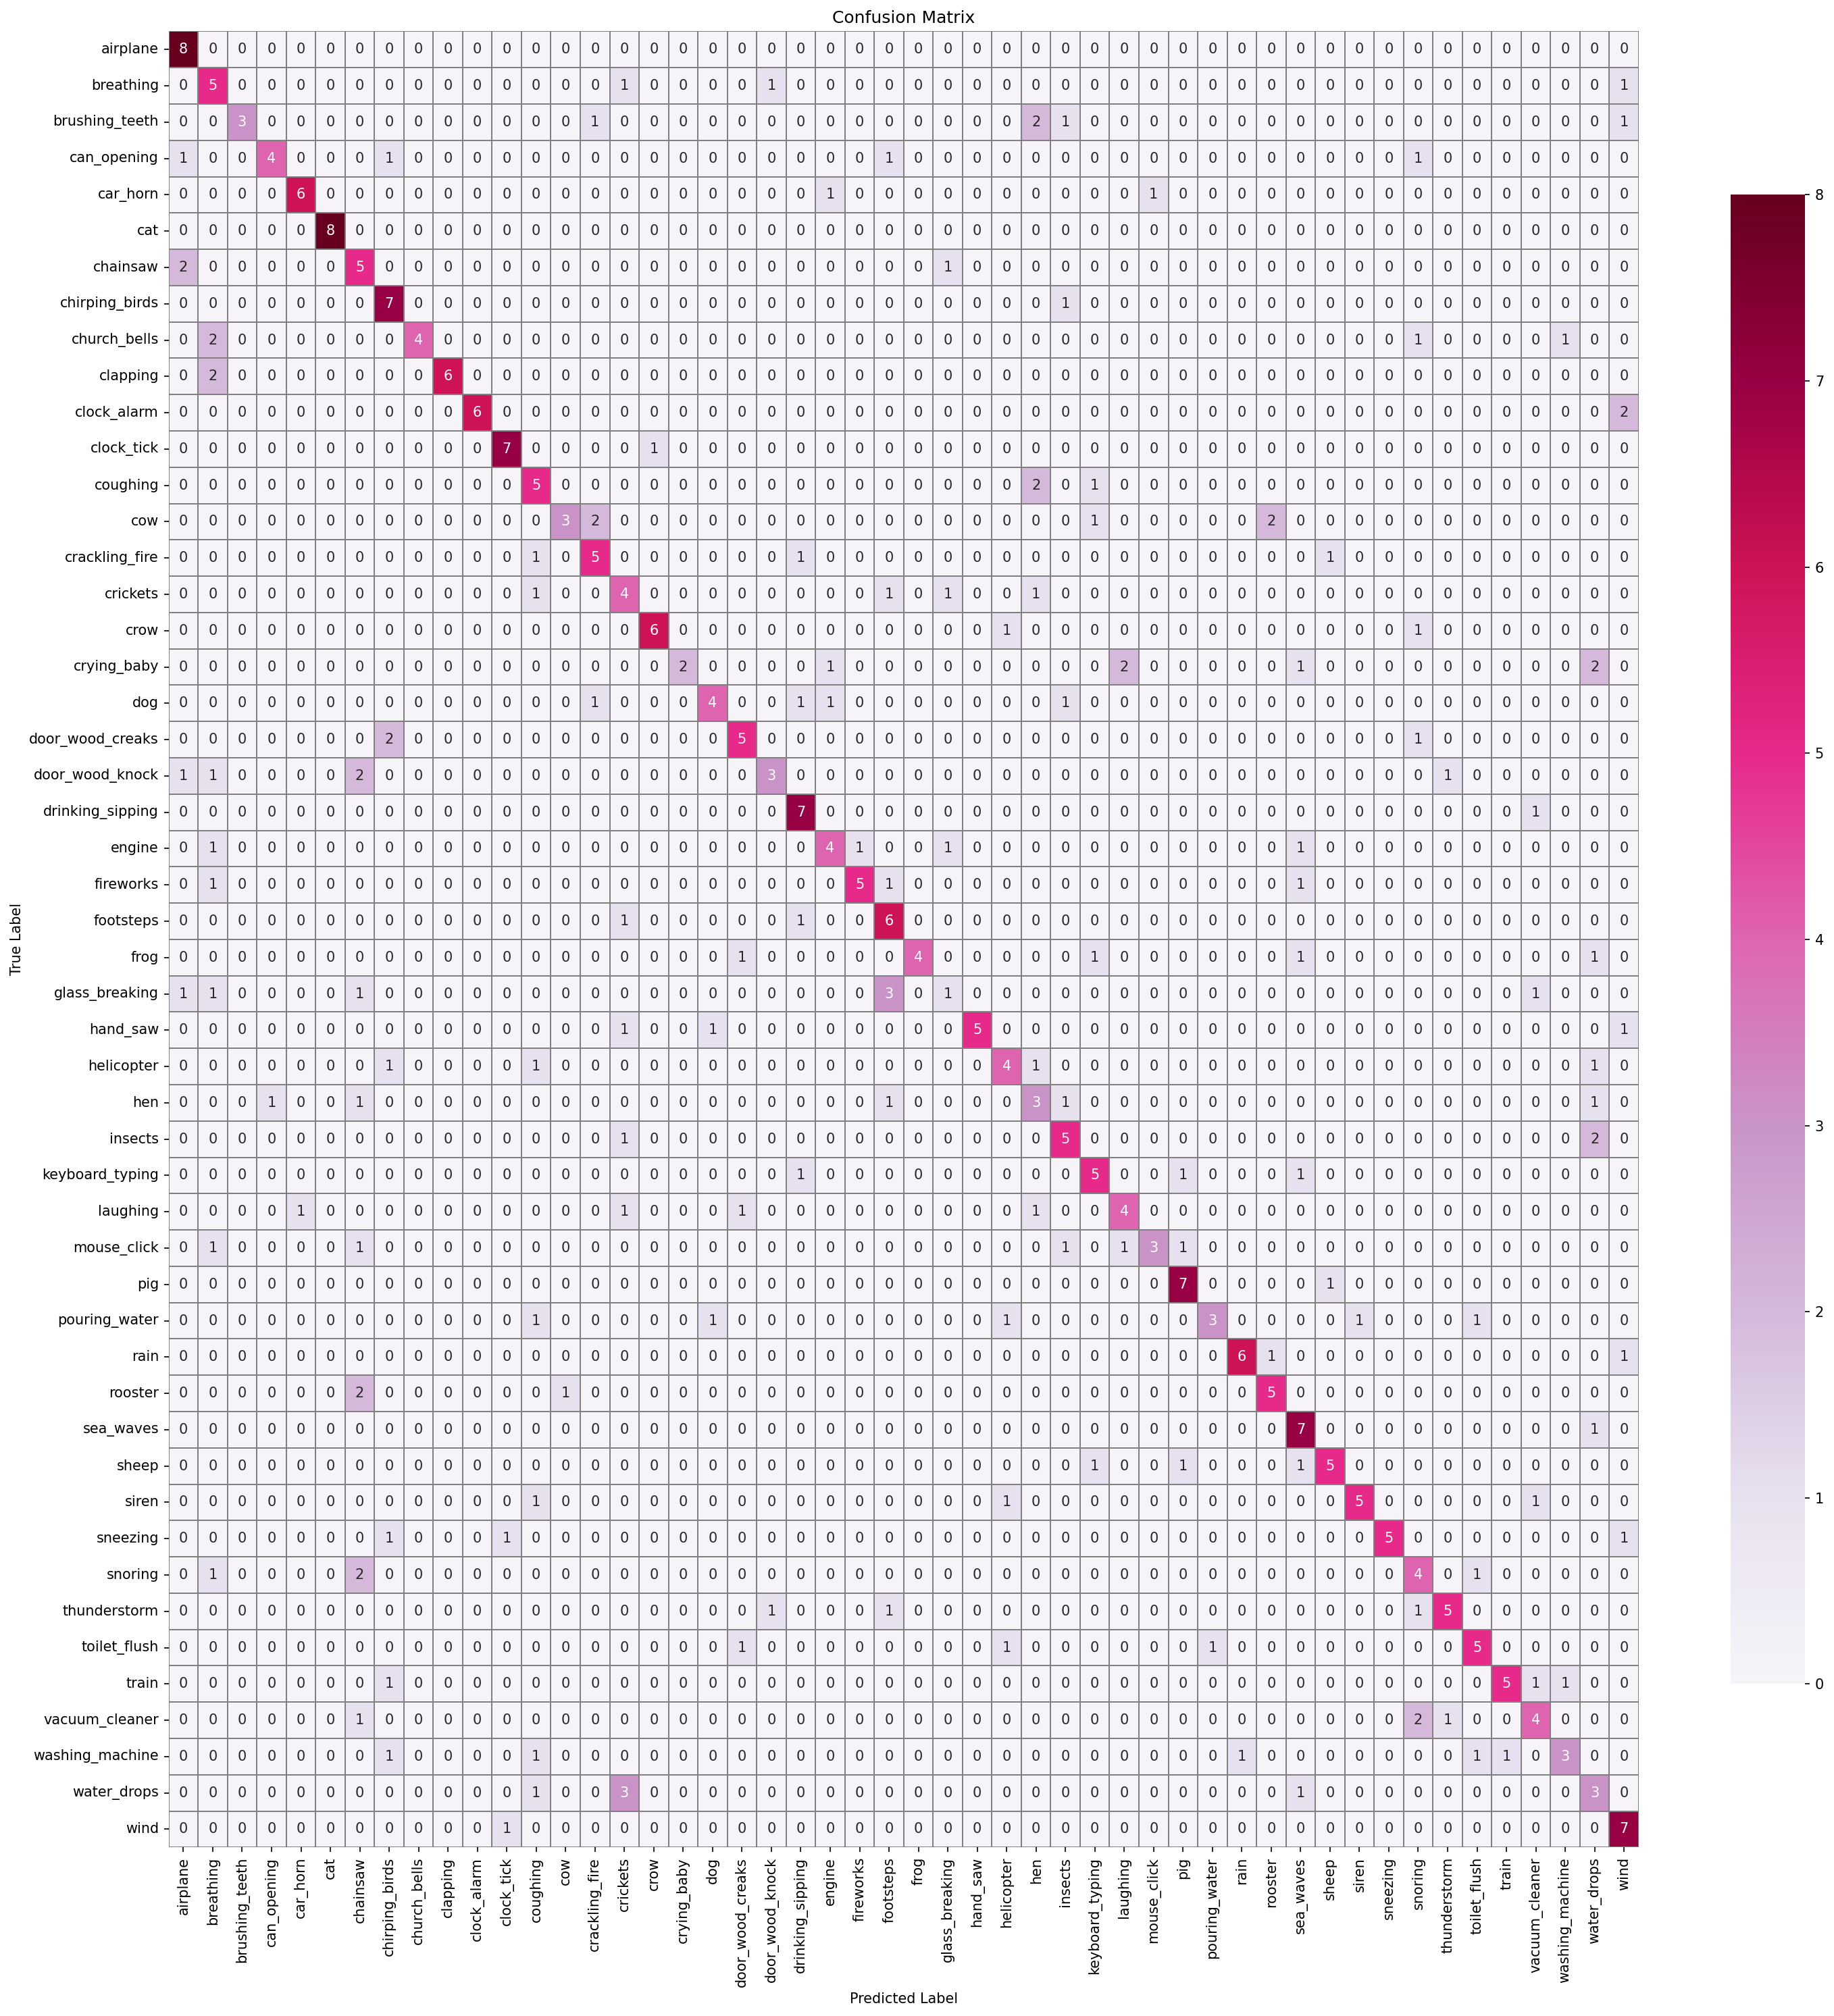

In [199]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(test_waveforms, test_labels, verbose=0)
print(f"\n📊 Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}\n")

# Plot training & validation loss/accuracy curves
plot_loss_acc(history, 'Task 2: With Data Augmentation Method 4')

# Predict class probabilities on the test set
predicted_probabilities = model.predict(test_waveforms)

# Convert predicted probabilities to class indices
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Extract class names from metadata
class_names = np.unique(meta['category'])

# Plot confusion matrix
plot_confusion_matrix(test_labels, predicted_classes, class_names)

The model trained on pink noise–augmented raw waveforms achieves a test accuracy of 60.25%, slightly outperforming white noise (59.75%) and surpassing all previous augmentation methods. The training and validation curves are smooth and consistent, indicating effective learning with minimal overfitting. This suggests pink noise may be the most robust augmentation strategy for raw audio in this task.

## Task 2 Method 5 (Apply All 4 Augmentations)

In [239]:
def super_process_data_waveform(meta, audio_file_path, augmentation_functions,
                                sr=44100, test_size=0.2, random_state=42):
    """
    Splits metadata, applies multiple augmentation functions to training data only,
    and loads raw audio waveforms. Returns all audio as fixed-length arrays.

    Parameters:
        meta (DataFrame): Metadata with 'filename' and 'target' columns.
        audio_file_path (str): Path to the folder with original audio files.
        augmentation_functions (list): List of functions(y, sr) → y_aug (applied to training data).
        sr (int): Sampling rate (default 44100).
        test_size (float): Proportion of test samples.
        random_state (int): Seed for reproducibility.

    Returns:
        train_waveforms, train_labels, test_waveforms, test_labels: Preprocessed datasets.
    """

    # Define the local path to the folder containing the original audio files
    audio_file_path = '/Users/xeniaodintsova/Desktop/ML_Project/audio'

    # Split metadata
    meta_train, meta_test = train_test_split(meta, test_size=test_size, random_state=random_state,
                                             stratify=meta['target'])

    # TRAINING DATA
    train_waveforms = []
    train_labels = []

    print("Processing training data: original and with multiple augmentations...\n")

    for index, row in meta_train[['filename', 'target']].iterrows():
        filename = row['filename']
        label = row['target']
        audio_path = os.path.join(audio_file_path, filename)

        try:
            y, _ = librosa.load(audio_path, sr=sr)

            # --- ORIGINAL ---
            train_waveforms.append(y)
            train_labels.append(label)

            # --- AUGMENTATIONS (apply all to original only) ---
            for aug in augmentation_functions:
                try:
                    y_aug = aug(y, sr)
                    train_waveforms.append(y_aug)
                    train_labels.append(label)
                except Exception as aug_error:
                    print(f"  → Augmentation error ({aug_func.__name__}) on {filename}: {aug_error}")

            print(f"✓ Train {index + 1}/{len(meta_train)}: {filename} (original + {len(augmentation_functions)} augmentations)")

        except Exception as e:
            print(f"Error in train file {filename}: {e}")

    # TESTING DATA (original only)
    test_waveforms = []
    test_labels = []

    print("\nProcessing testing data (original only)...\n")

    for index, row in meta_test[['filename', 'target']].iterrows():
        filename = row['filename']
        label = row['target']
        path = os.path.join(audio_file_path, filename)

        try:
            y, _ = librosa.load(path, sr=sr)
            test_waveforms.append(y)
            test_labels.append(label)
            print(f"✓ Test {index + 1}/{len(meta_test)}: {filename}")

        except Exception as e:
            print(f"Error in test file {filename}: {e}")

    # Fix waveform length (e.g. 1 second = 44100 samples)
    fixed_length = 44100

    train_waveforms = np.array([
        np.pad(w, (0, fixed_length - len(w)), mode='constant') if len(w) < fixed_length else w[:fixed_length]
        for w in train_waveforms
    ], dtype=np.float16)

    test_waveforms = np.array([
        np.pad(w, (0, fixed_length - len(w)), mode='constant') if len(w) < fixed_length else w[:fixed_length]
        for w in test_waveforms
    ], dtype=np.float16)

    # Safe normalization to avoid NaNs
    train_waveforms = np.array([
        w / np.max(np.abs(w)) if np.max(np.abs(w)) > 0 else w
        for w in train_waveforms
    ], dtype=np.float16)

    test_waveforms = np.array([
        w / np.max(np.abs(w)) if np.max(np.abs(w)) > 0 else w
        for w in test_waveforms
    ], dtype=np.float16)

    # Add channel dimension for Conv1D
    train_waveforms = train_waveforms[..., np.newaxis]
    test_waveforms = test_waveforms[..., np.newaxis]
    
    # To prevent training errors:
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)

    print("\n✅ Data processing complete!")
    print(f"Train set shape: {train_waveforms.shape} (should be 5x original train size)")
    print(f"Test set shape: {test_waveforms.shape} (unchanged)")

    return train_waveforms, train_labels, test_waveforms, test_labels

In [240]:
train_waveforms, train_labels, test_waveforms, test_labels = super_process_data_waveform(meta, 
                        audio_file_path, augmentation_functions = [random_pitch_shift, random_time_stretch, 
                            apply_white_noise, apply_pink_noise], sr=44100, test_size=0.2, random_state=42)

Processing training data: original and with multiple augmentations...

✓ Train 596/1600: 2-173607-A-39.wav (original + 4 augmentations)
✓ Train 881/1600: 3-123086-A-28.wav (original + 4 augmentations)
✓ Train 1800/1600: 5-212181-A-38.wav (original + 4 augmentations)
✓ Train 699/1600: 2-70367-A-33.wav (original + 4 augmentations)
✓ Train 672/1600: 2-60794-A-26.wav (original + 4 augmentations)
✓ Train 1915/1600: 5-242932-B-26.wav (original + 4 augmentations)
✓ Train 81/1600: 1-18755-B-4.wav (original + 4 augmentations)
✓ Train 1808/1600: 5-213836-A-9.wav (original + 4 augmentations)
✓ Train 326/1600: 1-69165-A-34.wav (original + 4 augmentations)
✓ Train 1098/1600: 3-170015-A-0.wav (original + 4 augmentations)
✓ Train 1238/1600: 4-132383-B-2.wav (original + 4 augmentations)
✓ Train 514/1600: 2-120586-A-6.wav (original + 4 augmentations)
✓ Train 1496/1600: 4-195451-A-44.wav (original + 4 augmentations)
✓ Train 1876/1600: 5-233019-A-31.wav (original + 4 augmentations)
✓ Train 320/1600: 1-67

In [245]:
# Train the further optimised CNN model
model = RawAudio_VeryFurtherOptimisedCNN((44100, 1))

history = model.fit(train_waveforms, train_labels, validation_data=(test_waveforms, test_labels),
                    epochs=32, batch_size=81, callbacks=[lr_scheduler], verbose=1)

print("🎉 Model trained successfully!")

Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_85 (Conv1D)          (None, 44092, 8)          80        
                                                                 
 batch_normalization_304 (Ba  (None, 44092, 8)         32        
 tchNormalization)                                               
                                                                 
 activation_228 (Activation)  (None, 44092, 8)         0         
                                                                 
 max_pooling1d_85 (MaxPoolin  (None, 11023, 8)         0         
 g1D)                                                            
                                                                 
 conv1d_86 (Conv1D)          (None, 11015, 16)         1168      
                                                                 
 batch_normalization_305 (Ba  (None, 11015, 16)     


📊 Test Loss: 1.6009
✅ Test Accuracy: 0.6325



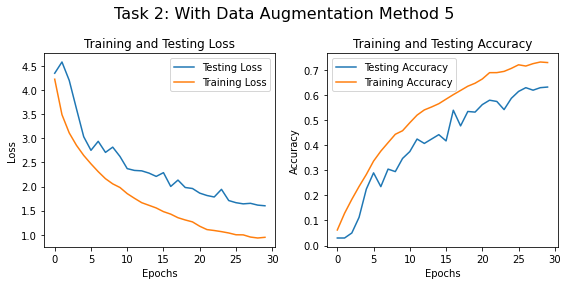

13/13 [==============================] - 1s 94ms/step


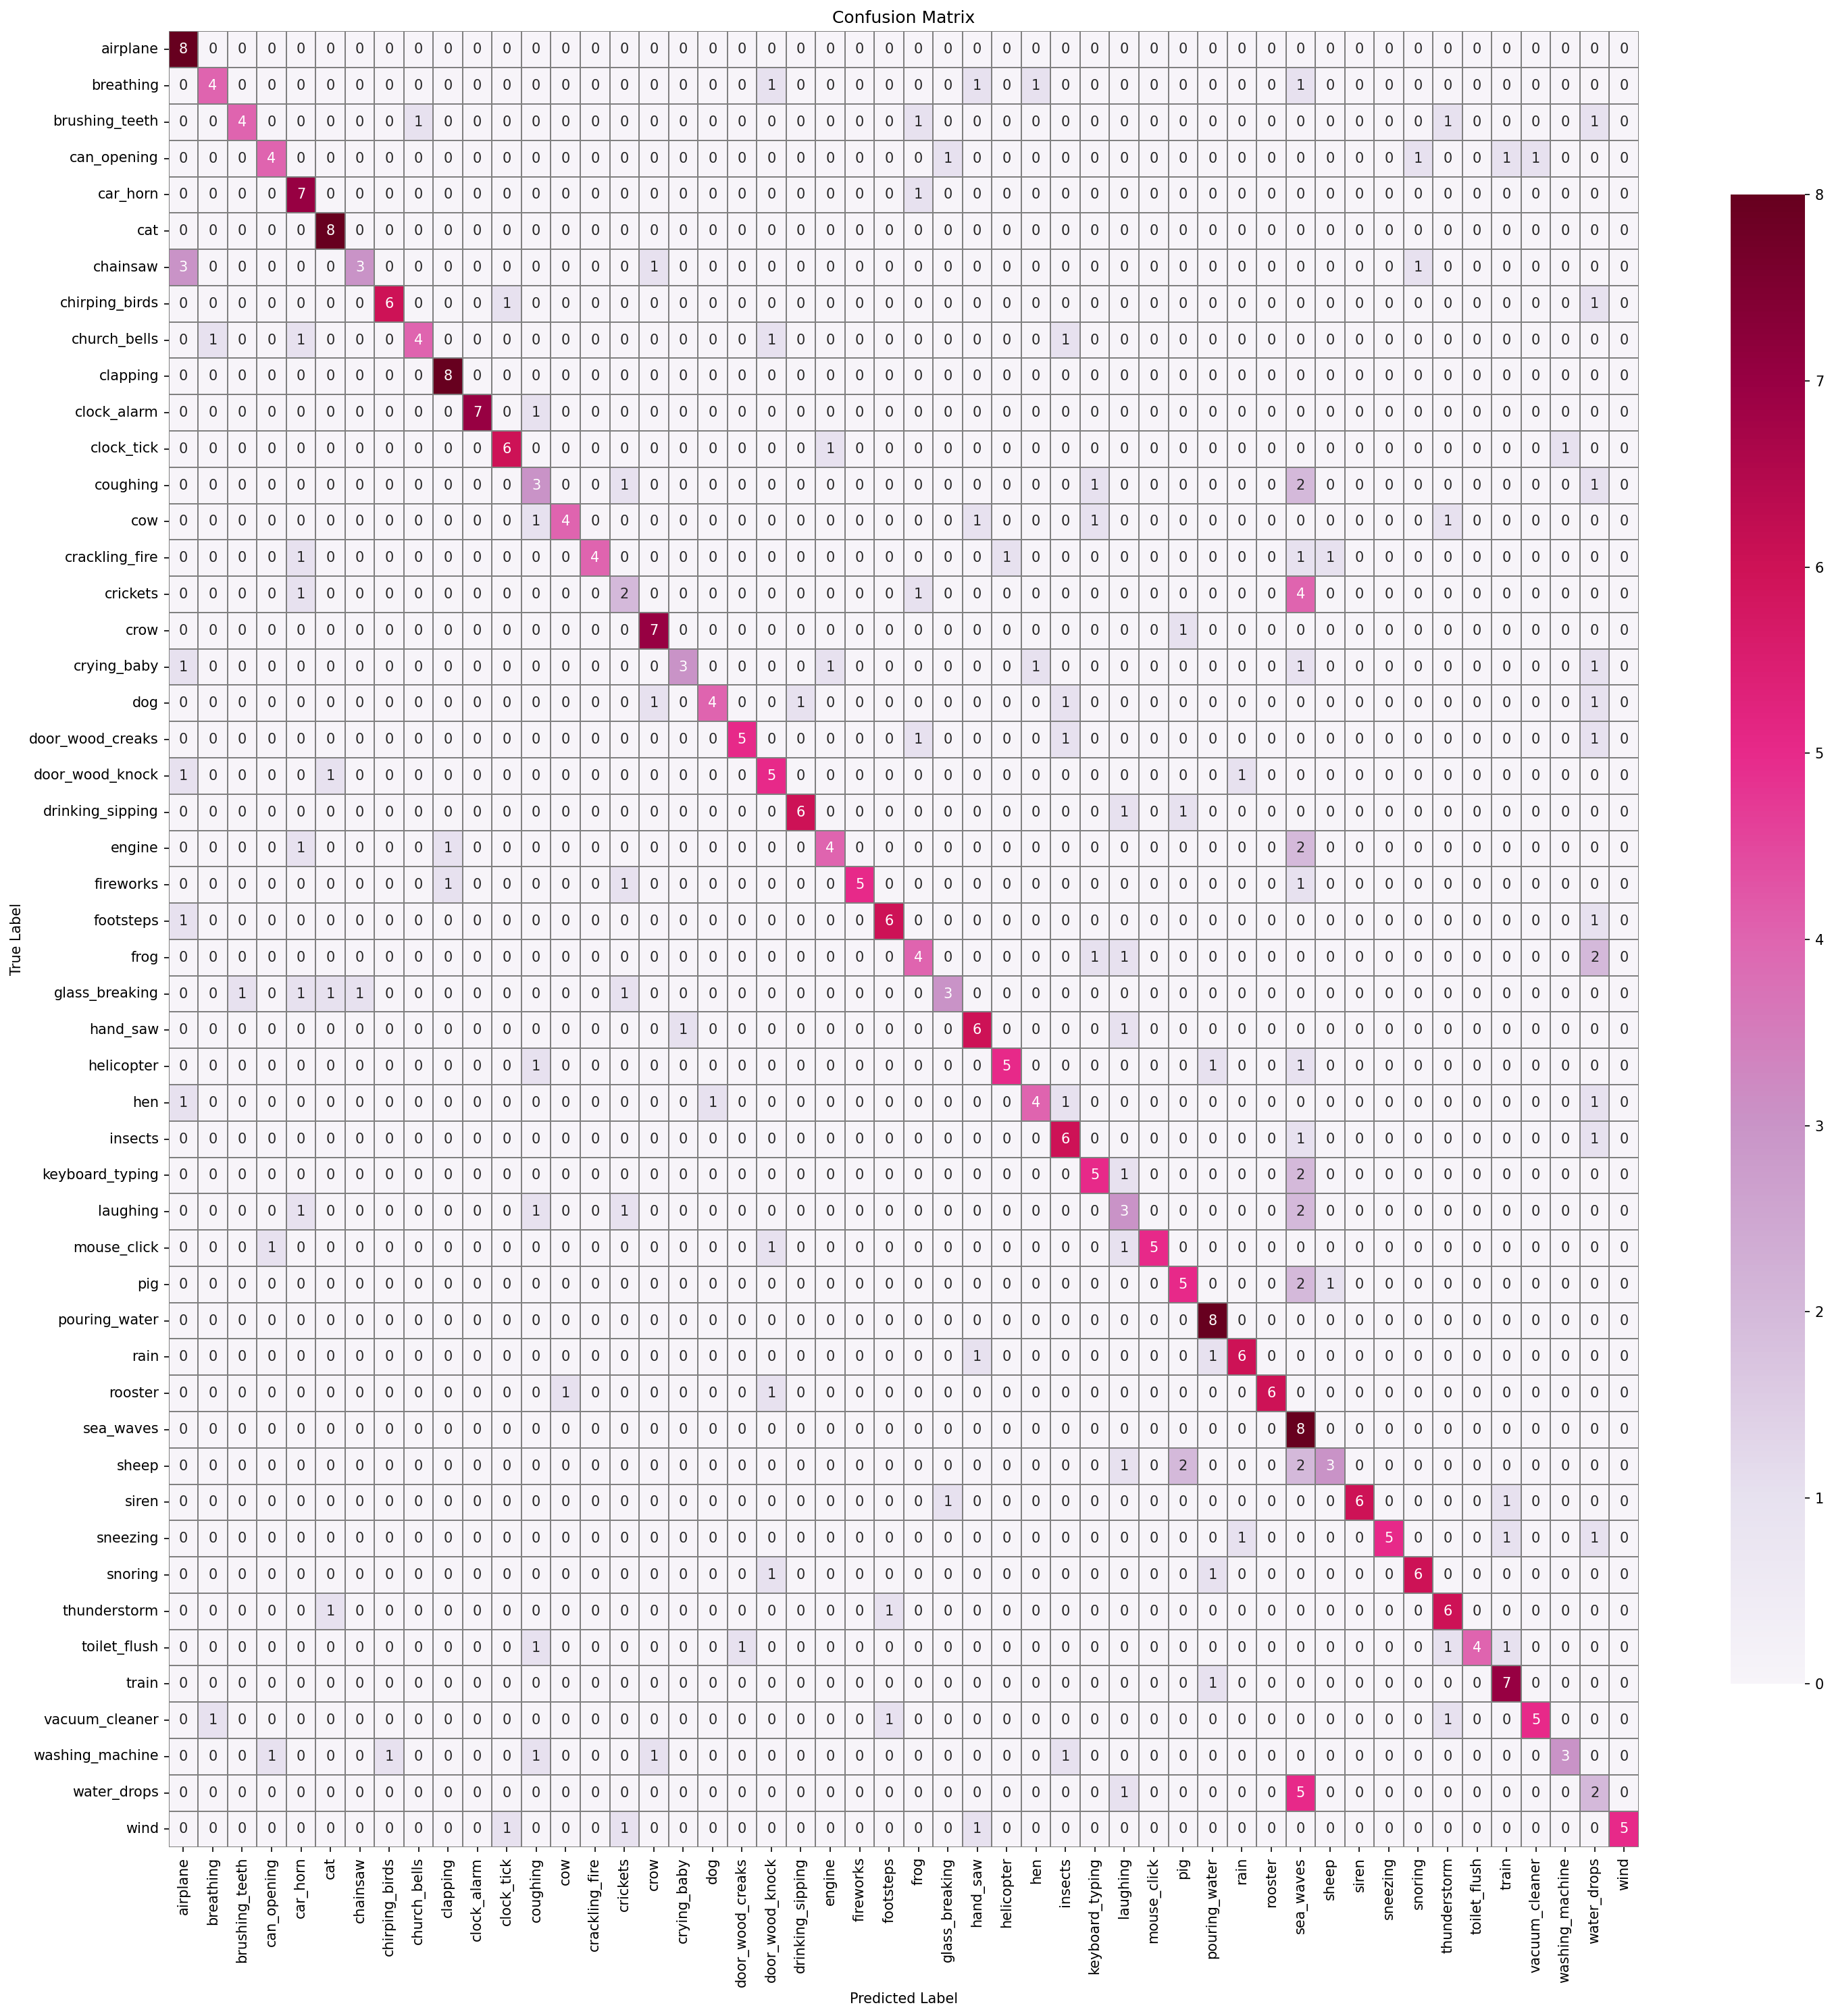

({0: 1.0,
  1: 0.5,
  2: 0.5,
  3: 0.5,
  4: 0.875,
  5: 1.0,
  6: 0.375,
  7: 0.75,
  8: 0.5,
  9: 1.0,
  10: 0.875,
  11: 0.75,
  12: 0.375,
  13: 0.5,
  14: 0.5,
  15: 0.25,
  16: 0.875,
  17: 0.375,
  18: 0.5,
  19: 0.625,
  20: 0.625,
  21: 0.75,
  22: 0.5,
  23: 0.625,
  24: 0.75,
  25: 0.5,
  26: 0.375,
  27: 0.75,
  28: 0.625,
  29: 0.5,
  30: 0.75,
  31: 0.625,
  32: 0.375,
  33: 0.625,
  34: 0.625,
  35: 1.0,
  36: 0.75,
  37: 0.75,
  38: 1.0,
  39: 0.375,
  40: 0.75,
  41: 0.625,
  42: 0.75,
  43: 0.75,
  44: 0.5,
  45: 0.875,
  46: 0.625,
  47: 0.375,
  48: 0.25,
  49: 0.625},
 {0: 1.0,
  1: 0.5,
  2: 0.5,
  3: 0.5,
  4: 0.875,
  5: 1.0,
  6: 0.375,
  7: 0.75,
  8: 0.5,
  9: 1.0,
  10: 0.875,
  11: 0.75,
  12: 0.375,
  13: 0.5,
  14: 0.5,
  15: 0.25,
  16: 0.875,
  17: 0.375,
  18: 0.5,
  19: 0.625,
  20: 0.625,
  21: 0.75,
  22: 0.5,
  23: 0.625,
  24: 0.75,
  25: 0.5,
  26: 0.375,
  27: 0.75,
  28: 0.625,
  29: 0.5,
  30: 0.75,
  31: 0.625,
  32: 0.375,
  33: 0.625,
  34:

In [254]:
### Evaluate model on the test set
loss, accuracy = model.evaluate(test_waveforms, test_labels, verbose=0)
print(f"\n📊 Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}\n")

# Plot training & validation loss/accuracy curves
plot_loss_acc(history, 'Task 2: With Data Augmentation Method 5')

# Predict class probabilities on the test set
predicted_probabilities = model.predict(test_waveforms)

# Convert predicted probabilities to class indices
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Extract class names from metadata
class_names = np.unique(meta['category'])

# Plot confusion matrix
plot_confusion_matrix(test_labels, predicted_classes, class_names, metrics = 'true')

# Task 3: Determine which of the categories are easiest and hardest to separate - is completed in the report

# Extension Task 1: Use an appropriate technique to determine how to group the 50 categories into a smaller number of super-categories

We group the 50 ESC-50 sound classes into five broader super-categories based on the structure proposed by Karol J. Piczak, the author of the dataset.

This grouping (shown in the cell below) reflects a semantically meaningful hierarchy and simplifies the classification task by enabling models to learn higher-level environmental sound patterns.

In [275]:
super_category_map = {
    # Animals
    'dog': 'animals', 'rooster': 'animals', 'pig': 'animals', 'cow': 'animals', 'frog': 'animals',
    'cat': 'animals', 'hen': 'animals', 'insects': 'animals', 'sheep': 'animals', 'crow': 'animals',

    # Natural sounds
    'rain': 'natural', 'sea_waves': 'natural', 'crackling_fire': 'natural', 'crickets': 'natural',
    'chirping_birds': 'natural', 'water_drops': 'natural', 'wind': 'natural', 'thunderstorm': 'natural',
    'crying_baby': 'natural', 'snoring': 'natural', 'pouring_water': 'natural',

    # Human sounds
    'sneezing': 'human', 'clapping': 'human', 'breathing': 'human', 'coughing': 'human', 'footsteps': 'human',
    'laughing': 'human', 'brushing_teeth': 'human', 'snapping_fingers': 'human', 'drinking_sipping': 'human', 'yawning': 'human',

    # Exterior/urban sounds
    'helicopter': 'mechanical', 'chainsaw': 'mechanical', 'siren': 'mechanical', 'car_horn': 'mechanical',
    'engine': 'mechanical', 'train': 'mechanical', 'church_bells': 'mechanical', 'airplane': 'mechanical',
    'fireworks': 'mechanical', 'hand_saw': 'mechanical', 'can_opening': 'mechanical',

    # Interior/household sounds
    'keyboard_typing': 'interior', 'door_wood_knock': 'interior', 'washing_machine': 'interior',
    'vacuum_cleaner': 'interior', 'clock_alarm': 'interior', 'toilet_flush': 'interior',
    'glass_breaking': 'interior', 'mouse_click': 'interior', 'microwave_oven': 'interior',
    'door_wood_creaks': 'interior', 'clock_tick': 'interior'
}

# Extension Task 2: Develop a machine learning algorithm that can classify the sounds in terms of the super categories

So, we need to add super-categories to our metdata, and then adjust our data processing function to incorporate 5 super categories instead of the 50 categories used before. We also need to adjust our CNN architecture to have only 5 nodes in the final output layer (corresponding to the 5 super categories). These changes are reflected in the code cells below.

We are going to try to classify the sounds into 5 super categories with spectrograms and pitch shift augmentations, as they had one of the best performances up to now (not taking Method 5 into account, as it is too complex for this task!)

### First, adjust the data processing step (not a function anymore, as we will only use it once), and the CNN architecture

In [276]:
# Add super-category to our metadata
meta['super_category'] = meta['category'].map(super_category_map)

# Define the local path to the folder containing the original audio files
audio_file_path = '/Users/xeniaodintsova/Desktop/ML_Project/audio'

# FIRST split the metadata into training and testing sets!!!
# We want to augment only the training data, then test our model on the original data!
meta_train, meta_test = train_test_split(meta, test_size=0.2, random_state=42, stratify=meta['target'])

# Define spectrogram shape
spect_height = 128
spect_width = 500

# Process TRAINING DATA WITH AUGMENTATION:
train_spectrograms = []
train_labels = []

print("Processing training data: original and with an augmentation...\n")

for index, row in meta_train[['filename', 'target', 'super_category']].iterrows():
    filename = row['filename']
    label = row['super_category']
    audio_path = os.path.join(audio_file_path, filename)
    
    try:
        y, sr = librosa.load(audio_path, sr=44100)
    
        # ORIGINAL VERSION OF THE DATA
        spect_orig = getSpect(y)
        if spect_orig.shape[1] < spect_width:
            pad = spect_width - spect_orig.shape[1]
            spect_orig = np.pad(spect_orig, ((0, 0), (0, pad)), mode='constant')
        else:
            spect_orig = spect_orig[:, :spect_width]

        train_spectrograms.append(spect_orig)
        train_labels.append(label)

        # AUGMENTED VERSION OF THE DATA
        y_aug = random_pitch_shift(y, sr)

        spect_aug = getSpect(y_aug)
        if spect_aug.shape[1] < spect_width:
            pad = spect_width - spect_aug.shape[1]
            spect_aug = np.pad(spect_aug, ((0, 0), (0, pad)), mode='constant')
        else:
            spect_aug = spect_aug[:, :spect_width]

        train_spectrograms.append(spect_aug)
        train_labels.append(label)

        print(f"✓ Train {index + 1}/{len(meta_train)}: {filename} (original + augmented)")

    except Exception as e:
        print(f"Error in train file {filename}: {e}")
    
    # TESTING DATA: ORIGINAL ONLY
test_spectrograms = []
test_labels = []

print("\nProcessing testing data (original only)...\n")

for index, row in meta_test[['filename', 'target', 'super_category']].iterrows():
    filename = row['filename']
    label = row['super_category']
    path = os.path.join(audio_file_path, filename)

    try:
        y, sr = librosa.load(path)

        spect = getSpect(y)
        if spect.shape[1] < spect_width:
            pad = spect_width - spect.shape[1]
            spect = np.pad(spect, ((0, 0), (0, pad)), mode='constant')
        else:
            spect = spect[:, :spect_width]

        test_spectrograms.append(spect)
        test_labels.append(label)

        print(f"✓ Test {index + 1}/{len(meta_test)}: {filename}")

    except Exception as e:
        print(f"Error in test file {filename}: {e}")

# Initialise an encoder for labels
encoder = LabelEncoder()

encoder.fit(meta['super_category'])  # Make sure to fit on ALL available labels
train_labels = encoder.transform(train_labels)
test_labels = encoder.transform(test_labels)

# Convert lists to numpy arrays
train_spectrograms = np.array(train_spectrograms, dtype=np.float32)[..., np.newaxis]
test_spectrograms = np.array(test_spectrograms, dtype=np.float32)[..., np.newaxis]

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

print("\n✅ Data processing complete!")
print(f"Train set shape: {train_spectrograms.shape} (should be 2x original train size)")
print(f"Test set shape: {test_spectrograms.shape} (unchanged)")

Processing training data: original and with an augmentation...

✓ Train 596/1600: 2-173607-A-39.wav (original + augmented)
✓ Train 881/1600: 3-123086-A-28.wav (original + augmented)
✓ Train 1800/1600: 5-212181-A-38.wav (original + augmented)
✓ Train 699/1600: 2-70367-A-33.wav (original + augmented)
✓ Train 672/1600: 2-60794-A-26.wav (original + augmented)
✓ Train 1915/1600: 5-242932-B-26.wav (original + augmented)
✓ Train 81/1600: 1-18755-B-4.wav (original + augmented)
✓ Train 1808/1600: 5-213836-A-9.wav (original + augmented)
✓ Train 326/1600: 1-69165-A-34.wav (original + augmented)
✓ Train 1098/1600: 3-170015-A-0.wav (original + augmented)
✓ Train 1238/1600: 4-132383-B-2.wav (original + augmented)
✓ Train 514/1600: 2-120586-A-6.wav (original + augmented)
✓ Train 1496/1600: 4-195451-A-44.wav (original + augmented)
✓ Train 1876/1600: 5-233019-A-31.wav (original + augmented)
✓ Train 320/1600: 1-67152-A-17.wav (original + augmented)
✓ Train 659/1600: 2-54086-A-43.wav (original + augmente

In [277]:
# Further optimised CNN architecture
def FurtherOptimisedCNN_5Categories(input_shape):
    model = keras.Sequential()

    # Input and resizing
    model.add(Input(shape=input_shape))
    model.add(keras.layers.Resizing(64, 128))  # resize to 64x128 (HxW)

    # Block 1: Conv + BN + ReLU + MaxPool + Dropout
    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 2
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Block 3
    model.add(Conv2D(128, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dropout(0.6))
    model.add(Dense(125, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.7))
    model.add(Dense(5, activation='softmax')) # corresponding to 5 super categories

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model

### Train and test the model's performance now

In [288]:
# Train the further optimised CNN model with 5 outputs
model = FurtherOptimisedCNN_5Categories((128, 500, 1))

history = model.fit(train_spectrograms, train_labels, validation_data=(test_spectrograms, test_labels),
                    epochs=30, batch_size=32, callbacks=[lr_scheduler], verbose=1)

print("🎉 Model trained successfully!")

Model: "sequential_115"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_85 (Resizing)      (None, 64, 128, 1)        0         
                                                                 
 conv2d_276 (Conv2D)         (None, 62, 126, 32)       320       
                                                                 
 batch_normalization_364 (Ba  (None, 62, 126, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_273 (Activation)  (None, 62, 126, 32)      0         
                                                                 
 max_pooling2d_276 (MaxPooli  (None, 31, 63, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_277 (Conv2D)         (None, 29, 61, 64)     


📊 Test Loss: 0.9678
✅ Test Accuracy: 0.6125



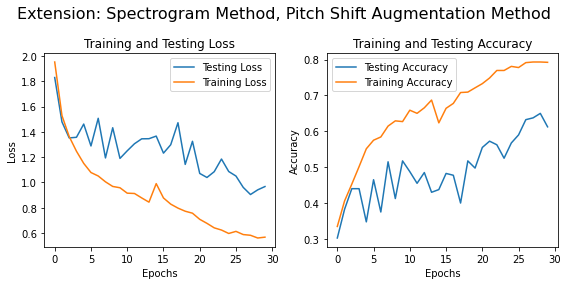

13/13 [==============================] - 2s 135ms/step


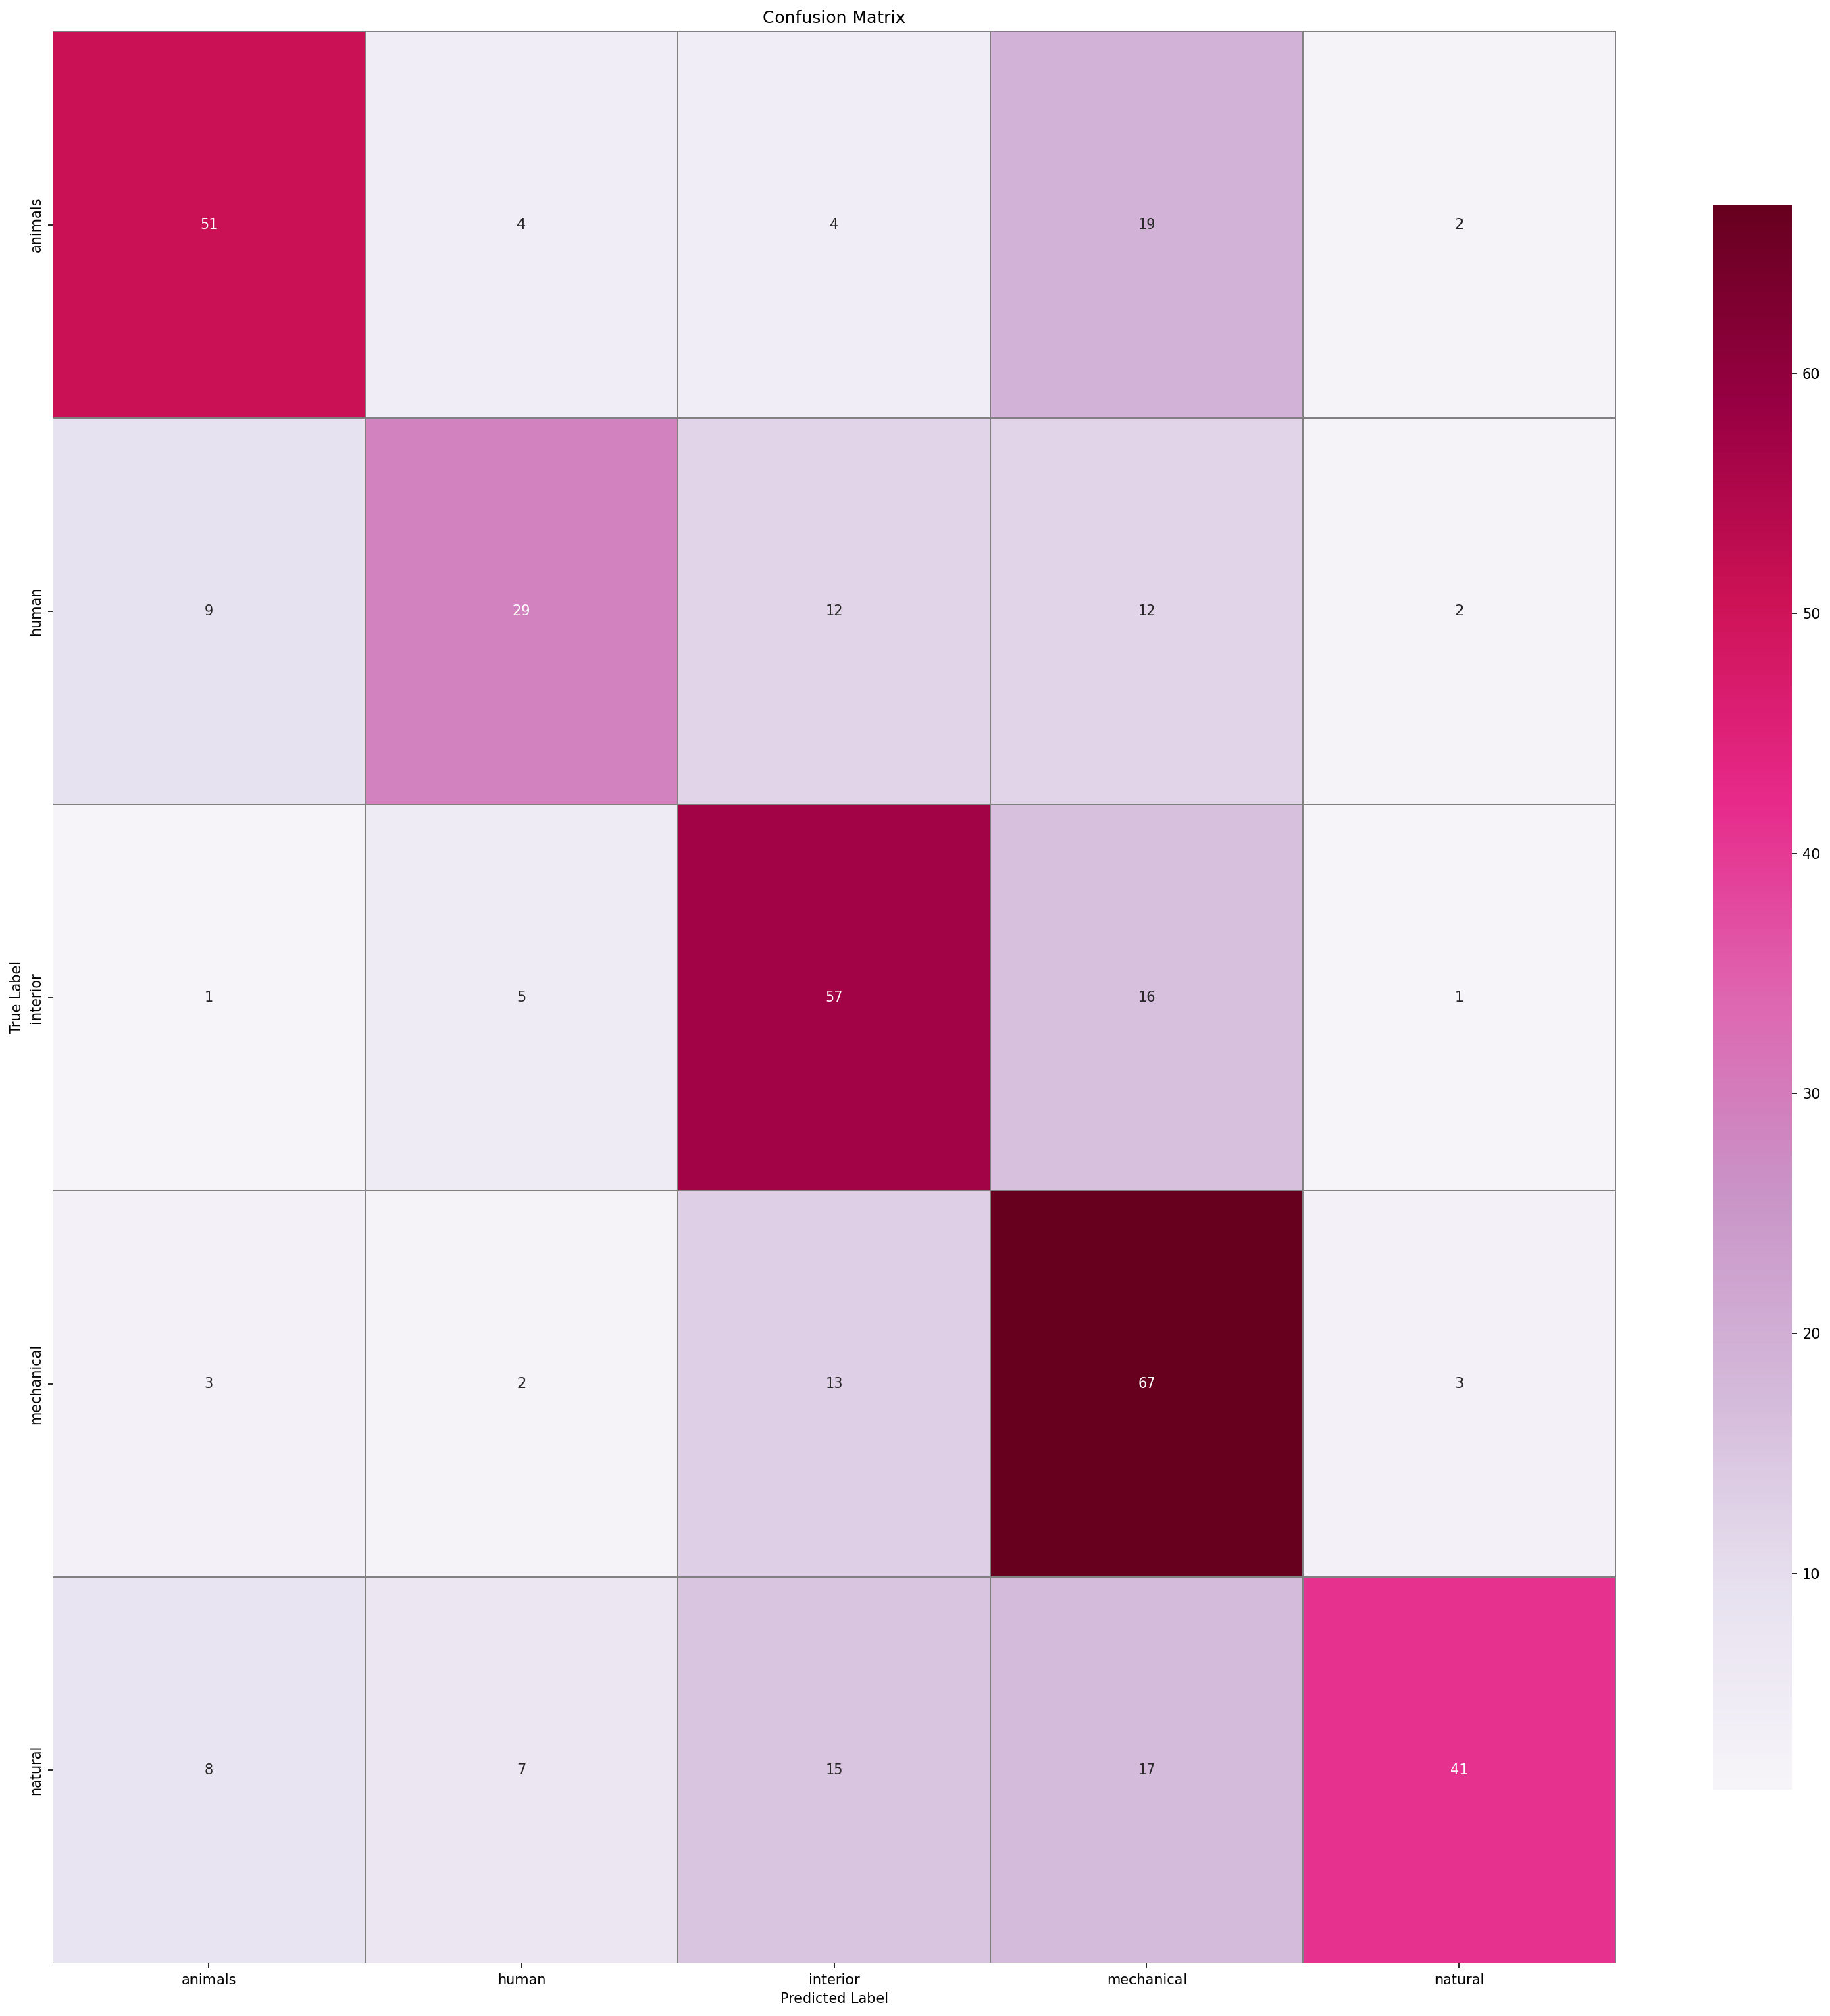

In [290]:
### Evaluate model on the test set
loss, accuracy = model.evaluate(test_spectrograms, test_labels, verbose=0)
print(f"\n📊 Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}\n")

# Plot training & validation loss/accuracy curves
plot_loss_acc(history, 'Extension: Spectrogram Method, Pitch Shift Augmentation Method')

# Predict class probabilities on the test set
predicted_probabilities = model.predict(test_spectrograms)

# Convert predicted probabilities to class indices
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Extract class names from metadata
class_names = np.unique(meta['super_category'])

# Plot confusion matrix
plot_confusion_matrix(test_labels, predicted_classes, class_names)

The accuracy of the model on this simplified dataset is not too different to the performance on the original dataset... So the model is probably overfitting, as suggested by the wide gap between training and testing accuracy. So, let's try a simplified architecture!

In [305]:
# Simplified CNN architecture

# Key improvements:
# - Add kernel regularisation to reduce overfitting
# - Use less Conv2D nodes
# - Use smaller kernel sizes (3x3 -> 2x2 later)
# - Use GlobalAveragePooling instead of Flatten for more stability

def Simple_CNN_5Categories(input_shape):
    model = keras.Sequential()

    # Input and resizing
    model.add(Input(shape=input_shape))
    model.add(keras.layers.Resizing(64, 128))

    # Block 1
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 2
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 3
    model.add(Conv2D(64, (2, 2), padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Global Average Pooling (more stable than Flatten)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.3))

    # Dense + Output layer
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(5, activation='softmax'))

    # Compile
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model

In [306]:
# Train the further optimised CNN model with 5 outputs
model = Simple_CNN_5Categories((128, 500, 1))

history = model.fit(train_spectrograms, train_labels, validation_data=(test_spectrograms, test_labels),
                    epochs=30, batch_size=32, callbacks=[lr_scheduler], verbose=1)

print("🎉 Model trained successfully!")

Model: "sequential_123"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_93 (Resizing)      (None, 64, 128, 1)        0         
                                                                 
 conv2d_300 (Conv2D)         (None, 64, 128, 32)       320       
                                                                 
 batch_normalization_396 (Ba  (None, 64, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_297 (Activation)  (None, 64, 128, 32)      0         
                                                                 
 max_pooling2d_300 (MaxPooli  (None, 32, 64, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_301 (Conv2D)         (None, 32, 64, 64)     


📊 Test Loss: 1.0856
✅ Test Accuracy: 0.5500



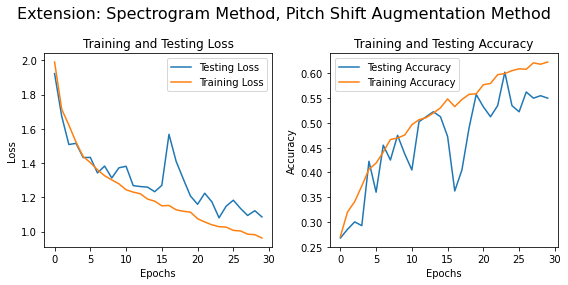

13/13 [==============================] - 1s 52ms/step


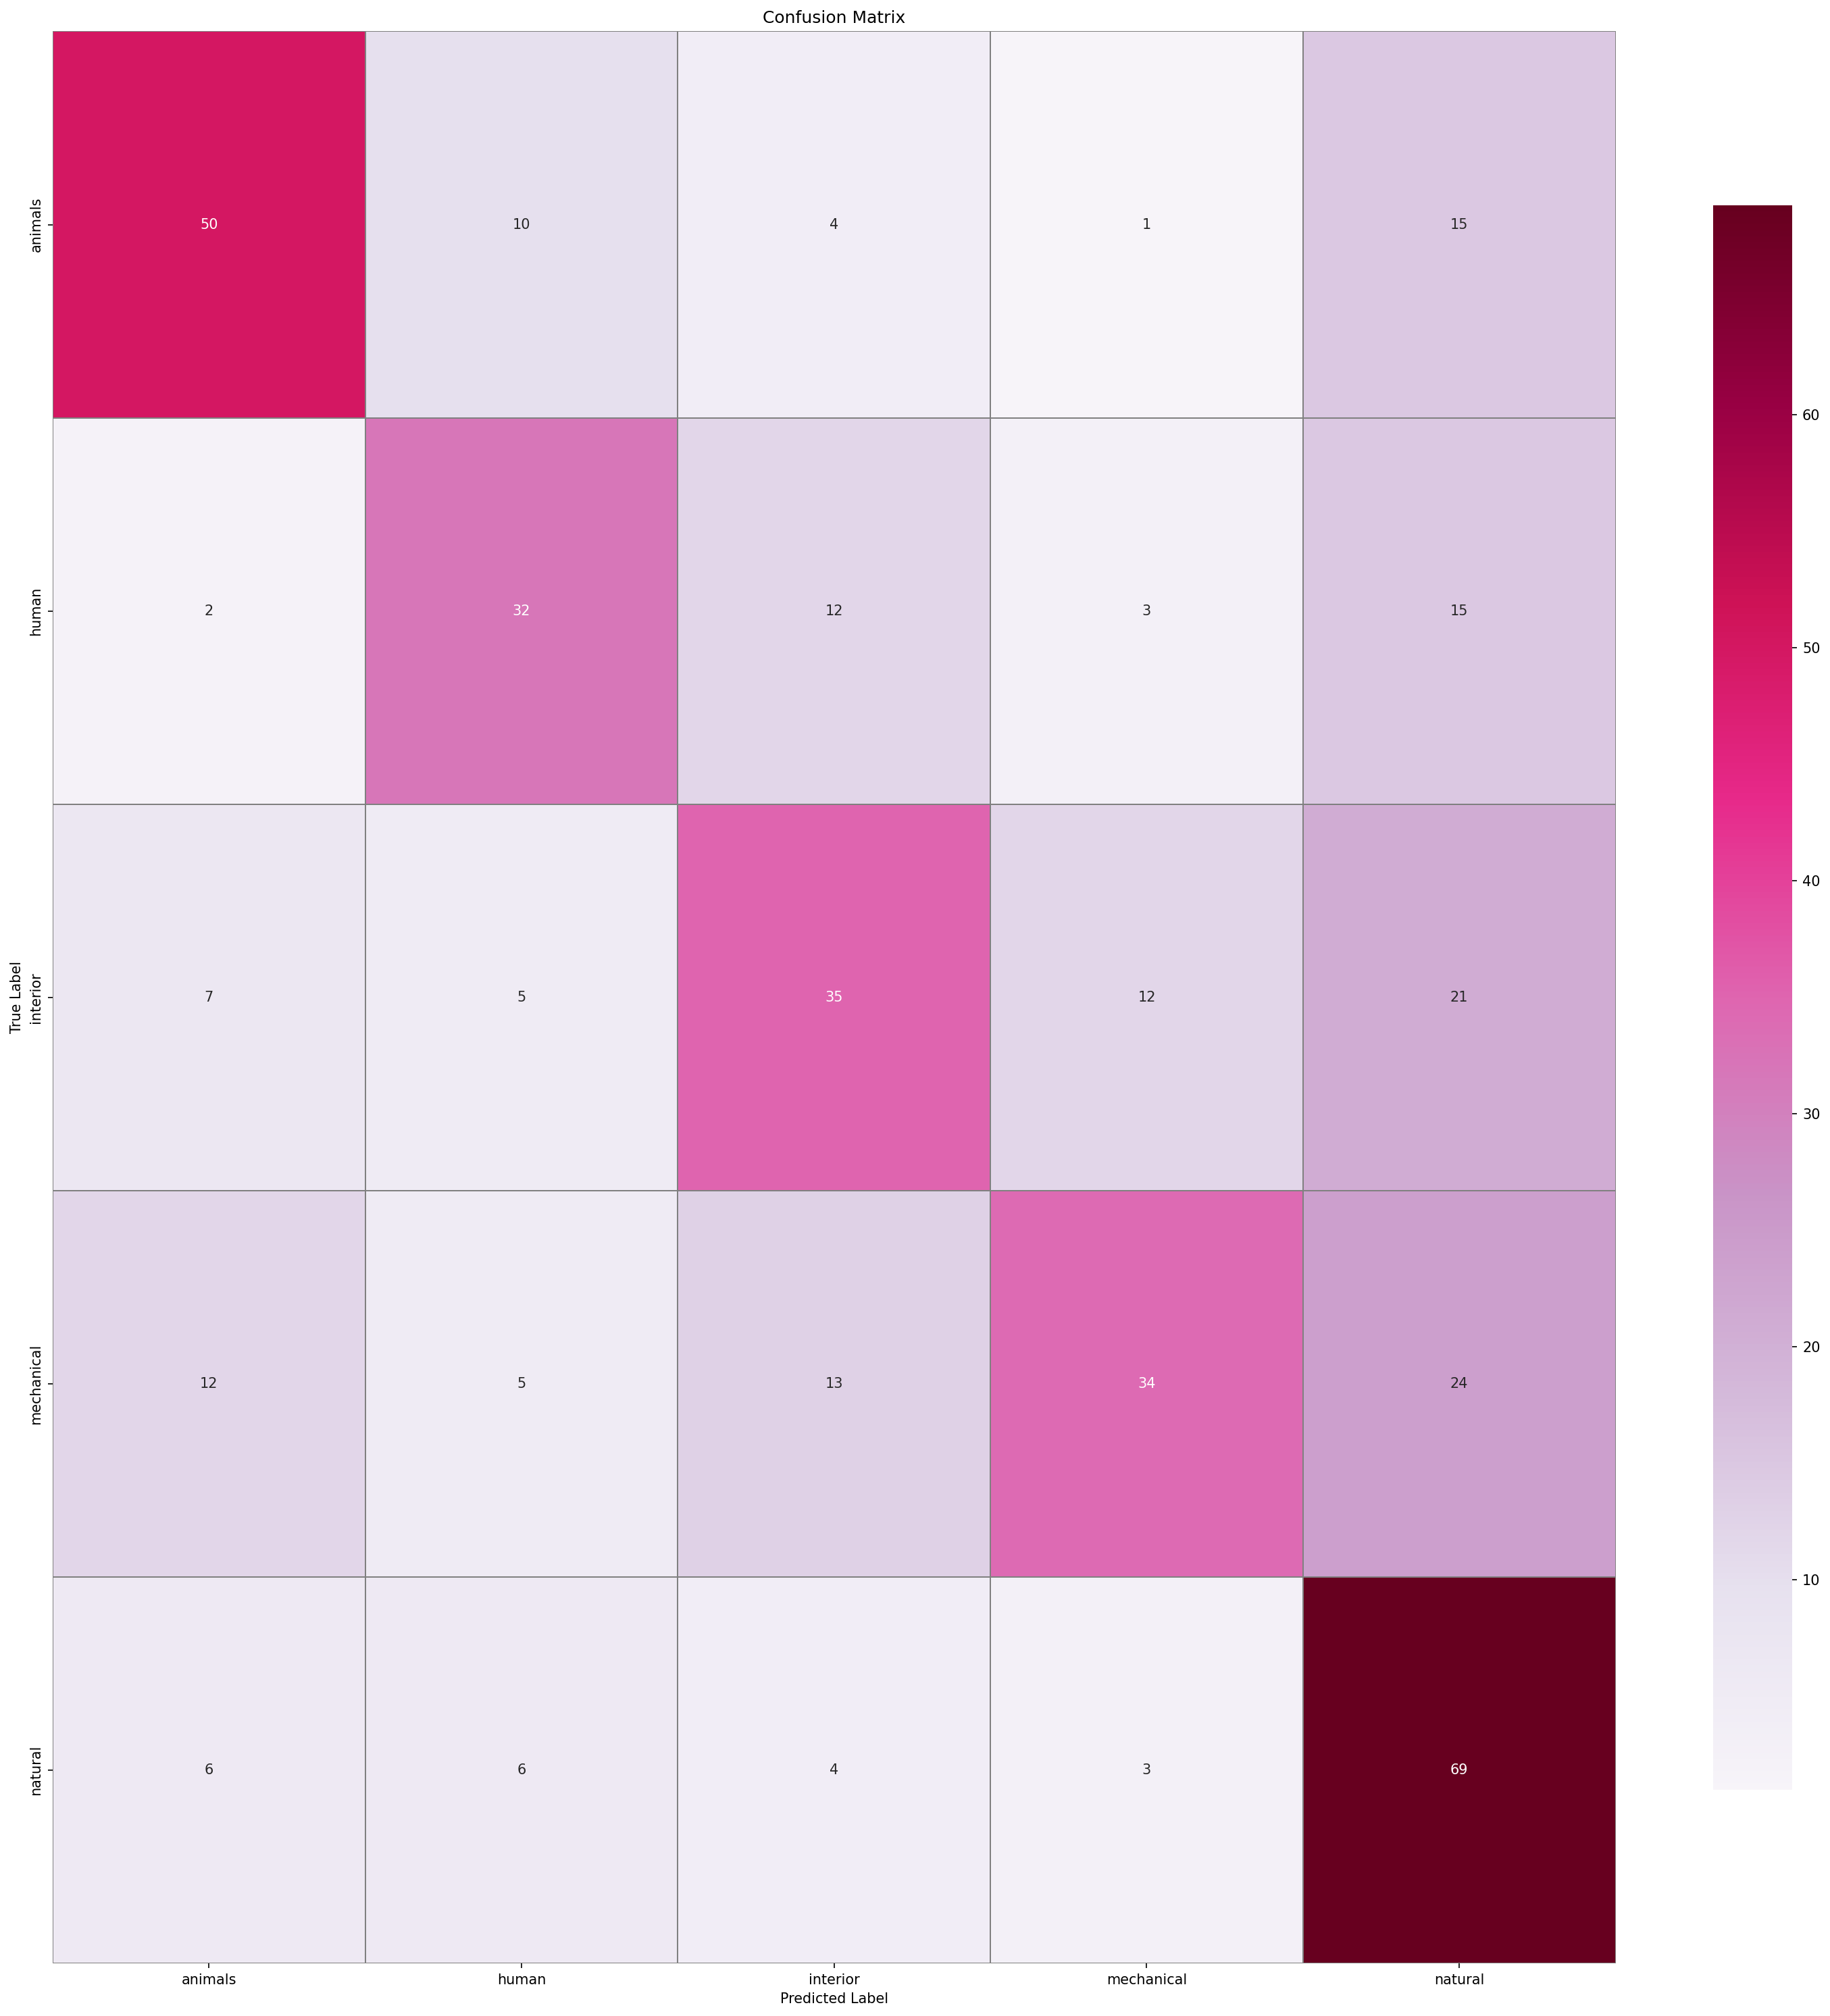

In [307]:
### Evaluate model on the test set
loss, accuracy = model.evaluate(test_spectrograms, test_labels, verbose=0)
print(f"\n📊 Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}\n")

# Plot training & validation loss/accuracy curves
plot_loss_acc(history, 'Extension: Spectrogram Method, Pitch Shift Augmentation Method')

# Predict class probabilities on the test set
predicted_probabilities = model.predict(test_spectrograms)

# Convert predicted probabilities to class indices
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Extract class names from metadata
class_names = np.unique(meta['super_category'])

# Plot confusion matrix
plot_confusion_matrix(test_labels, predicted_classes, class_names)

Accuracy did not change too much, but the model definitely generalises better!